<a href="https://colab.research.google.com/github/HeyVijay5/HeyVijay5-TERRASLIDE---MONITORING-TERRAIN-SHIFTS-USING-DEEP-LEARNING/blob/main/UNET%2B%2B_RESUNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow matplotlib segmentation-models transformers h5py

import os
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab import drive


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/SDP FILES')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Custom metrics and utils
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

In [ ]:
# Data Loading and Preprocessing
def load_data(train_img_path, train_mask_path, val_img_path=None, val_mask_path=None):
    # Load training data
    train_images = sorted(glob.glob(os.path.join(train_img_path, '*.h5')))
    train_masks = sorted(glob.glob(os.path.join(train_mask_path, '*.h5')))

    X_train = np.zeros((len(train_images), 128, 128, 6))
    y_train = np.zeros((len(train_masks), 128, 128, 1))

    for i, (img_path, mask_path) in enumerate(zip(train_images, train_masks)):
        # Load image
        with h5py.File(img_path, 'r') as hdf:
            data = np.array(hdf['img'])
            data[np.isnan(data)] = 0.000001

            # Normalize and calculate NDVI
            mid_rgb = data[:, :, 1:4].max() / 2.0
            mid_slope = data[:, :, 12].max() / 2.0
            mid_elevation = data[:, :, 13].max() / 2.0

            data_red = data[:, :, 3]
            data_nir = data[:, :, 7]
            data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))

            X_train[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  # RED
            X_train[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb  # GREEN
            X_train[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb  # BLUE
            X_train[i, :, :, 3] = data_ndvi  # NDVI
            X_train[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope  # SLOPE
            X_train[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation  # ELEVATION

        # Load mask
        with h5py.File(mask_path, 'r') as hdf:
            y_train[i, :, :, 0] = np.array(hdf['mask'])

    # Load validation data if provided
    if val_img_path and val_mask_path:
        val_images = sorted(glob.glob(os.path.join(val_img_path, '*.h5')))
        val_masks = sorted(glob.glob(os.path.join(val_mask_path, '*.h5')))

        X_val = np.zeros((len(val_images), 128, 128, 6))
        y_val = np.zeros((len(val_masks), 128, 128, 1))

        for i, (img_path, mask_path) in enumerate(zip(val_images, val_masks)):
            with h5py.File(img_path, 'r') as hdf:
                data = np.array(hdf['img'])
                data[np.isnan(data)] = 0.000001

                mid_rgb = data[:, :, 1:4].max() / 2.0
                mid_slope = data[:, :, 12].max() / 2.0
                mid_elevation = data[:, :, 13].max() / 2.0

                data_red = data[:, :, 3]
                data_nir = data[:, :, 7]
                data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))

                X_val[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb
                X_val[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb
                X_val[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb
                X_val[i, :, :, 3] = data_ndvi
                X_val[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope
                X_val[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation

            with h5py.File(mask_path, 'r') as hdf:
                y_val[i, :, :, 0] = np.array(hdf['mask'])

        return X_train, y_train, X_val, y_val

    return X_train, y_train


In [ ]:
# Model Definitions
def unet_model(input_size=(128, 128, 6)):
    inputs = tf.keras.Input(input_size)

    # Contracting Path
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

def attention_block(gate, x, filters):
    gate_conv = layers.Conv2D(filters, (1, 1), padding='same')(gate)
    x_conv = layers.Conv2D(filters, (1, 1), padding='same')(x)
    merged = layers.Add()([gate_conv, x_conv])
    merged = layers.Activation('relu')(merged)
    psi = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(merged)
    return layers.Multiply()([x, psi])

def attention_unet(input_size=(128, 128, 6)):
    inputs = tf.keras.Input(input_size)

    # Contracting Path
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive Path with Attention Gates
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    att6 = attention_block(u6, c4, 128)
    u6 = layers.concatenate([u6, att6])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    att7 = attention_block(u7, c3, 64)
    u7 = layers.concatenate([u7, att7])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    att8 = attention_block(u8, c2, 32)
    u8 = layers.concatenate([u8, att8])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    att9 = attention_block(u9, c1, 16)
    u9 = layers.concatenate([u9, att9])
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

def resunet(input_size=(128, 128, 6)):
    def residual_block(x, filters, dropout_rate=0.1):
        # Shortcut
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

        # Main path
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout_rate)(x)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)

        # Add shortcut
        x = layers.Add()([x, shortcut])
        x = layers.Activation('relu')(x)
        return x

    inputs = tf.keras.Input(input_size)

    # Contracting Path
    c1 = residual_block(inputs, 16)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 32)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 64, 0.2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 128, 0.2)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottom
    c5 = residual_block(p4, 256, 0.3)

    # Expansive Path
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = residual_block(u6, 128, 0.2)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = residual_block(u7, 64, 0.2)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = residual_block(u8, 32)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = residual_block(u9, 16)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

def deeplabv3plus(input_size=(128, 128, 6)):
    import segmentation_models as sm
    model = sm.DeepLabV3Plus(
        backbone='resnet50',
        input_shape=input_size,
        classes=1,
        activation='sigmoid',
        encoder_weights=None
    )
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', f1_m, precision_m, recall_m])
    return model


In [ ]:
import numpy as np
import h5py
import glob
import os
from multiprocessing import Pool
from functools import partial

def load_single_image(img_path, is_mask=False):
    """
    Loads a single HDF5 image or mask file, handles missing values,
    and performs feature engineering for input images.
    """
    with h5py.File(img_path, 'r') as hdf:
        data = np.array(hdf['img'] if not is_mask else hdf['mask'])
        data = np.nan_to_num(data, nan=1e-6)  # Replace NaNs

        if not is_mask:
            # Extract relevant channels
            red = data[:, :, 3]
            green = data[:, :, 2]
            blue = data[:, :, 1]
            nir = data[:, :, 7]
            slope = data[:, :, 12]
            elevation = data[:, :, 13]

            # Normalize constants
            mid_rgb = max(red.max(), green.max(), blue.max()) / 2.0
            mid_slope = slope.max() / 2.0
            mid_elevation = elevation.max() / 2.0

            # NDVI calculation with epsilon
            epsilon = 1e-6
            ndvi = (nir - red) / (nir + red + epsilon)

            # Construct 6-channel input image
            processed = np.zeros((128, 128, 6))
            processed[:, :, 0] = 1 - red / mid_rgb
            processed[:, :, 1] = 1 - green / mid_rgb
            processed[:, :, 2] = 1 - blue / mid_rgb
            processed[:, :, 3] = ndvi
            processed[:, :, 4] = 1 - slope / mid_slope
            processed[:, :, 5] = 1 - elevation / mid_elevation

            return processed
        else:
            # Return mask with channel dimension
            return data[:, :, np.newaxis]

def parallel_load_data(img_paths, mask_paths, num_workers=4):
    """
    Load images and masks in parallel using multiprocessing for efficiency.
    """
    with Pool(num_workers) as pool:
        images = pool.map(partial(load_single_image, is_mask=False), img_paths)
        masks = pool.map(partial(load_single_image, is_mask=True), mask_paths)
    return np.array(images), np.array(masks)

def load_data_optimized(train_img_path, train_mask_path, val_img_path=None, val_mask_path=None):
    """
    Loads and processes training and optionally validation datasets.
    """
    train_images = sorted(glob.glob(os.path.join(train_img_path, '*.h5')))
    train_masks = sorted(glob.glob(os.path.join(train_mask_path, '*.h5')))
    print(f"Found {len(train_images)} training images and {len(train_masks)} masks")

    X_train, y_train = parallel_load_data(train_images, train_masks)

    if val_img_path and val_mask_path:
        val_images = sorted(glob.glob(os.path.join(val_img_path, '*.h5')))
        val_masks = sorted(glob.glob(os.path.join(val_mask_path, '*.h5')))
        print(f"Found {len(val_images)} validation images and {len(val_masks)} masks")

        X_val, y_val = parallel_load_data(val_images, val_masks)
        return X_train, y_train, X_val, y_val

    return X_train, y_train

# === Usage Example ===
train_img_path = 'TrainData/img'
train_mask_path = 'TrainData/mask'
val_img_path = 'ValidData/img'
val_mask_path = 'ValidData/mask'

print("Loading training data...")
X_train, y_train, X_val, y_val = load_data_optimized(train_img_path, train_mask_path, val_img_path, val_mask_path)
print("Data loading complete!")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


Loading training data...
Found 3799 training images and 3799 masks


<ipython-input-11-19a976e8867a>:41: RuntimeWarning: invalid value encountered in divide
  processed[:, :, 4] = 1 - slope / mid_slope
<ipython-input-11-19a976e8867a>:41: RuntimeWarning: invalid value encountered in divide
  processed[:, :, 4] = 1 - slope / mid_slope
<ipython-input-11-19a976e8867a>:41: RuntimeWarning: invalid value encountered in divide
  processed[:, :, 4] = 1 - slope / mid_slope


Found 245 validation images and 245 masks
Data loading complete!
Training data shape: (3799, 128, 128, 6)
Validation data shape: (245, 128, 128, 6)


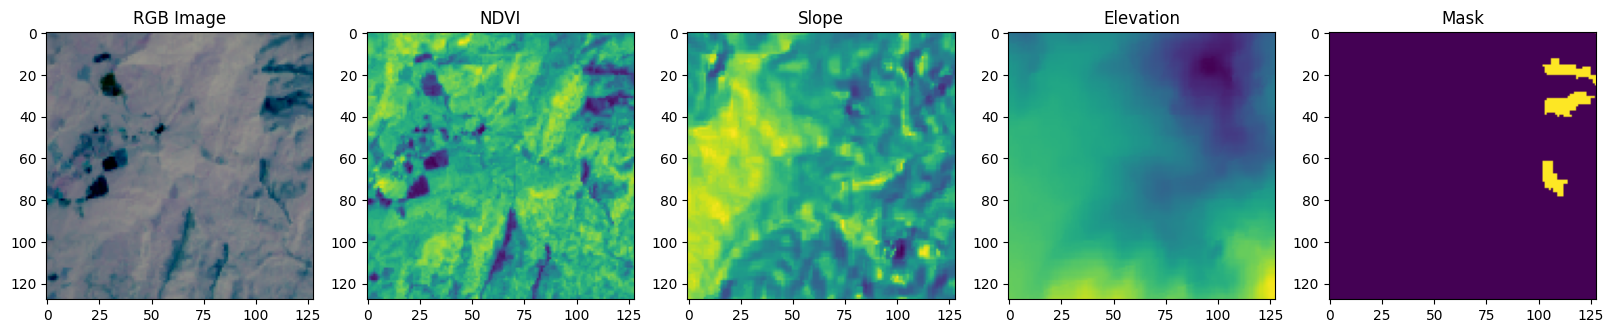

In [ ]:
# Visualize sample data
def visualize_sample(X, y, index):
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    axes[0].imshow(X[index, :, :, 0:3])
    axes[0].set_title("RGB Image")
    axes[1].imshow(X[index, :, :, 3])
    axes[1].set_title("NDVI")
    axes[2].imshow(X[index, :, :, 4])
    axes[2].set_title("Slope")
    axes[3].imshow(X[index, :, :, 5])
    axes[3].set_title("Elevation")
    axes[4].imshow(y[index, :, :, 0])
    axes[4].set_title("Mask")
    plt.show()

visualize_sample(X_train, y_train, 0)

In [ ]:
# Train and evaluate models
def train_evaluate_model(model_func, model_name, X_train, y_train, X_val, y_val, epochs=50, batch_size=16):
    print(f"\nTraining {model_name}...")
    model = model_func()

    callbacks = [
        ModelCheckpoint(f"best_{model_name}.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max"),
        EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    results = model.evaluate(X_val, y_val, verbose=0)
    metrics = {
        'loss': results[0],
        'accuracy': results[1],
        'f1_score': results[2],
        'precision': results[3],
        'recall': results[4]
    }

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_m'], label='Train F1')
    plt.plot(history.history['val_f1_m'], label='Validation F1')
    plt.title(f'{model_name} - F1 Score')
    plt.legend()
    plt.show()

    return model, metrics


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# Assume these are defined elsewhere or define them here
# from utils import dice_loss, f1_m, precision_m, recall_m

# -------------------------
# U-Net
# -------------------------
def unet_model(input_size=(128, 128, 6)):
    inputs = tf.keras.Input(input_size)

    # Encoder
    def conv_block(x, filters, dropout=0.1):
        x = layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64, 0.2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128, 0.2)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 256, 0.3)

    # Decoder
    def up_block(x, skip, filters, dropout=0.1):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters, dropout)
        return x

    c6 = up_block(c5, c4, 128, 0.2)
    c7 = up_block(c6, c3, 64, 0.2)
    c8 = up_block(c7, c2, 32, 0.1)
    c9 = up_block(c8, c1, 16, 0.1)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

# -------------------------
# Attention U-Net
# -------------------------
def attention_unet(input_size=(128, 128, 6)):
    def attention_block(g, x, filters):
        g1 = layers.Conv2D(filters, (1, 1), padding='same')(g)
        x1 = layers.Conv2D(filters, (1, 1), padding='same')(x)
        psi = layers.Activation('relu')(layers.Add()([g1, x1]))
        psi = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(psi)
        return layers.Multiply()([x, psi])

    inputs = tf.keras.Input(input_size)

    def conv_block(x, filters, dropout=0.1):
        x = layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        return x

    c1 = conv_block(inputs, 16)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 32)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 64, 0.2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 128, 0.2)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 256, 0.3)

    def up_attention_block(x, skip, filters, dropout=0.1):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        att = attention_block(x, skip, filters)
        x = layers.concatenate([x, att])
        x = conv_block(x, filters, dropout)
        return x

    c6 = up_attention_block(c5, c4, 128, 0.2)
    c7 = up_attention_block(c6, c3, 64, 0.2)
    c8 = up_attention_block(c7, c2, 32, 0.1)
    c9 = up_attention_block(c8, c1, 16, 0.1)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

# -------------------------
# ResU-Net
# -------------------------
def resunet(input_size=(128, 128, 6)):
    def residual_block(x, filters, dropout=0.1):
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout)(x)

        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)

        x = layers.Add()([shortcut, x])
        x = layers.Activation('relu')(x)
        return x

    inputs = tf.keras.Input(input_size)

    c1 = residual_block(inputs, 16)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 32)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 64, 0.2)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 128, 0.2)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = residual_block(p4, 256, 0.3)

    def up_res_block(x, skip, filters, dropout=0.1):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([x, skip])
        x = residual_block(x, filters, dropout)
        return x

    c6 = up_res_block(c5, c4, 128, 0.2)
    c7 = up_res_block(c6, c3, 64, 0.2)
    c8 = up_res_block(c7, c2, 32)
    c9 = up_res_block(c8, c1, 16)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy', f1_m, precision_m, recall_m])
    return model


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))


In [ ]:
import os
os.listdir('.')  # Lists all files in the current directory


['.config', 'drive', 'sample_data']

In [ ]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    b1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    b1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(b1)

    # Decoder
    u1 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(b1)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c4)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model


In [ ]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [ ]:
import os

print("Current Working Directory:", os.getcwd())

Current Working Directory: /content


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
os.chdir(r'/content/gdrive/MyDrive/SDP FILES')

In [ ]:
import os

print("Current Working Directory:", os.getcwd())

Current Working Directory: /content/gdrive/MyDrive/SDP FILES


In [ ]:
import os

base_dir = "/content/gdrive/MyDrive/SDP FILES"  # Correct path with space
sub_dirs = ["TrainData", "TestData", "ValidData"]

for sub_dir in sub_dirs:
    img_folder = os.path.join(base_dir, sub_dir, "img")  # Use correct path
    if os.path.exists(img_folder):
        print(f"✅ Found folder: {img_folder}")
        print("Files:", os.listdir(img_folder))
    else:
        print(f"❌ Folder not found: {img_folder}")

✅ Found folder: /content/gdrive/MyDrive/SDP FILES/TrainData/img
Files: ['image_3441.h5', 'image_2634.h5', 'image_3560.h5', 'image_1558.h5', 'image_120.h5', 'image_3356.h5', 'image_3654.h5', 'image_3744.h5', 'image_2263.h5', 'image_2342.h5', 'image_796.h5', 'image_1943.h5', 'image_3626.h5', 'image_25.h5', 'image_1931.h5', 'image_3377.h5', 'image_2560.h5', 'image_2146.h5', 'image_3248.h5', 'image_180.h5', 'image_1574.h5', 'image_2675.h5', 'image_2289.h5', 'image_1447.h5', 'image_17.h5', 'image_1542.h5', 'image_1354.h5', 'image_1719.h5', 'image_960.h5', 'image_1213.h5', 'image_1634.h5', 'image_861.h5', 'image_2677.h5', 'image_2616.h5', 'image_610.h5', 'image_3288.h5', 'image_401.h5', 'image_2237.h5', 'image_2268.h5', 'image_624.h5', 'image_1601.h5', 'image_1055.h5', 'image_1391.h5', 'image_512.h5', 'image_469.h5', 'image_1130.h5', 'image_376.h5', 'image_161.h5', 'image_2945.h5', 'image_1483.h5', 'image_3465.h5', 'image_1686.h5', 'image_3193.h5', 'image_2356.h5', 'image_3134.h5', 'image_60

In [ ]:
# Train and evaluate models
def train_evaluate_model(model_func, model_name, X_train, y_train, X_val, y_val, epochs=50, batch_size=16):
    print(f"\nTraining {model_name}...")
    model = model_func()

    callbacks = [
        ModelCheckpoint(f"best_{model_name}.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max"),
        EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate
    results = model.evaluate(X_val, y_val, verbose=0)
    metrics = {
        'loss': results[0],
        'accuracy': results[1],
        'f1_score': results[2],
        'precision': results[3],
        'recall': results[4]
    }

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['f1_m'], label='Train F1')
    plt.plot(history.history['val_f1_m'], label='Validation F1')
    plt.title(f'{model_name} - F1 Score')
    plt.legend()
    plt.show()

    return model, metrics

In [ ]:
import os
print("Current Working Directory:", os.getcwd())
print("Contents of the current directory:", os.listdir('./'))


Current Working Directory: /content/gdrive/MyDrive/SDP FILES
Contents of the current directory: ['TestData', 'TrainData', 'ValidData', 'Unet.py', 'utils.py']


In [ ]:
train_img_path = '/full/path/to/SDP FILES/TrainData/img/'
train_mask_path = '/full/path/to/SDP FILES/TrainData/mask/'


In [ ]:
import os

# Path to the train data images and masks
train_img_path = './TrainData/img'
train_mask_path = './TrainData/mask'

# List the contents of the directories
print("Contents of TrainData/img:", os.listdir(train_img_path))
print("Contents of TrainData/mask:", os.listdir(train_mask_path))


Contents of TrainData/img: ['image_3441.h5', 'image_2634.h5', 'image_3560.h5', 'image_1558.h5', 'image_120.h5', 'image_3356.h5', 'image_3654.h5', 'image_3744.h5', 'image_2263.h5', 'image_2342.h5', 'image_796.h5', 'image_1943.h5', 'image_3626.h5', 'image_25.h5', 'image_1931.h5', 'image_3377.h5', 'image_2560.h5', 'image_2146.h5', 'image_3248.h5', 'image_180.h5', 'image_1574.h5', 'image_2675.h5', 'image_2289.h5', 'image_1447.h5', 'image_17.h5', 'image_1542.h5', 'image_1354.h5', 'image_1719.h5', 'image_960.h5', 'image_1213.h5', 'image_1634.h5', 'image_861.h5', 'image_2677.h5', 'image_2616.h5', 'image_610.h5', 'image_3288.h5', 'image_401.h5', 'image_2237.h5', 'image_2268.h5', 'image_624.h5', 'image_1601.h5', 'image_1055.h5', 'image_1391.h5', 'image_512.h5', 'image_469.h5', 'image_1130.h5', 'image_376.h5', 'image_161.h5', 'image_2945.h5', 'image_1483.h5', 'image_3465.h5', 'image_1686.h5', 'image_3193.h5', 'image_2356.h5', 'image_3134.h5', 'image_603.h5', 'image_2947.h5', 'image_2801.h5', 'im

In [ ]:
import os
print(os.listdir('./'))


['TestData', 'TrainData', 'ValidData', 'Unet.py', 'utils.py']


In [ ]:
train_img_path = '/absolute/path/to/SDP FILES/TrainData/img/'
train_mask_path = '/absolute/path/to/SDP FILES/TrainData/mask/'


In [ ]:
import os
print("Current directory:", os.getcwd())
print("Contents:", os.listdir(os.getcwd()))


Current directory: /content/gdrive/MyDrive/SDP FILES
Contents: ['TestData', 'TrainData', 'ValidData', 'Unet.py', 'utils.py']


In [ ]:
import os

# Absolute path of the directory (replace with actual path in your system)
train_data_path = '/content/gdrive/MyDrive/SDP FILES/TrainData/'

# List the contents of the TrainData directory
print("Contents of TrainData directory:", os.listdir(train_data_path))


Contents of TrainData directory: ['img', 'mask']


In [ ]:
import os

# Define the corrected relative paths for the directories
train_img_path = '/content/gdrive/MyDrive/SDP FILES/TrainData/img/'
train_mask_path = '/content/gdrive/MyDrive/SDP FILES/TrainData/mask/'
val_img_path = '/content/gdrive/MyDrive/SDP FILES/ValidData/img/'
val_mask_path = '/content/gdrive/MyDrive/SDP FILES/ValidData/mask/'

# Print the absolute paths to check for correctness
print("Absolute path for Train Data img directory:", os.path.abspath(train_img_path))
print("Absolute path for Train Data mask directory:", os.path.abspath(train_mask_path))
print("Absolute path for Valid Data img directory:", os.path.abspath(val_img_path))
print("Absolute path for Valid Data mask directory:", os.path.abspath(val_mask_path))

# Check if the directories exist
print("Exists for train_img_path:", os.path.exists(train_img_path))
print("Exists for train_mask_path:", os.path.exists(train_mask_path))
print("Exists for val_img_path:", os.path.exists(val_img_path))
print("Exists for val_mask_path:", os.path.exists(val_mask_path))

# List the contents of the directories if they exist
if os.path.exists(train_img_path):
    print("Contents of Train img directory:", os.listdir(train_img_path))
else:
    print(f"Directory not found: {train_img_path}")

if os.path.exists(train_mask_path):
    print("Contents of Train mask directory:", os.listdir(train_mask_path))
else:
    print(f"Directory not found: {train_mask_path}")

if os.path.exists(val_img_path):
    print("Contents of Valid img directory:", os.listdir(val_img_path))
else:
    print(f"Directory not found: {val_img_path}")

if os.path.exists(val_mask_path):
    print("Contents of Valid mask directory:", os.listdir(val_mask_path))
else:
    print(f"Directory not found: {val_mask_path}")


Absolute path for Train Data img directory: /content/gdrive/MyDrive/SDP FILES/TrainData/img
Absolute path for Train Data mask directory: /content/gdrive/MyDrive/SDP FILES/TrainData/mask
Absolute path for Valid Data img directory: /content/gdrive/MyDrive/SDP FILES/ValidData/img
Absolute path for Valid Data mask directory: /content/gdrive/MyDrive/SDP FILES/ValidData/mask
Exists for train_img_path: True
Exists for train_mask_path: True
Exists for val_img_path: True
Exists for val_mask_path: True
Contents of Train img directory: ['image_3441.h5', 'image_2634.h5', 'image_3560.h5', 'image_1558.h5', 'image_120.h5', 'image_3356.h5', 'image_3654.h5', 'image_3744.h5', 'image_2263.h5', 'image_2342.h5', 'image_796.h5', 'image_1943.h5', 'image_3626.h5', 'image_25.h5', 'image_1931.h5', 'image_3377.h5', 'image_2560.h5', 'image_2146.h5', 'image_3248.h5', 'image_180.h5', 'image_1574.h5', 'image_2675.h5', 'image_2289.h5', 'image_1447.h5', 'image_17.h5', 'image_1542.h5', 'image_1354.h5', 'image_1719.h5',

In [ ]:
def check_h5_structure(file_path):
    with h5py.File(file_path, 'r') as file:
        print(f"Contents of {file_path}:")
        for key in file.keys():
            print(f"Key: {key}")

# Check the structure of one of the image and mask files
check_h5_structure(os.path.join(train_img_path, 'image_1.h5'))
check_h5_structure(os.path.join(train_mask_path, 'mask_1.h5'))


Contents of /content/gdrive/MyDrive/SDP FILES/TrainData/img/image_1.h5:
Key: img
Contents of /content/gdrive/MyDrive/SDP FILES/TrainData/mask/mask_1.h5:
Key: mask


In [ ]:
# Define function to load data from .h5 files
def load_data(img_path, mask_path):
    with h5py.File(img_path, 'r') as img_file, h5py.File(mask_path, 'r') as mask_file:
        images = np.array(img_file['img'])  # Use 'img' key for images
        masks = np.array(mask_file['mask'])  # Use 'mask' key for masks
    return images, masks


In [ ]:
# Assuming X_train and X_val are grayscale, add the 3rd channel for RGB
X_train = np.repeat(X_train, 3, axis=-1)
X_val = np.repeat(X_val, 3, axis=-1)


In [ ]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)


X_train shape: (128, 128, 42)
X_val shape: (128, 128, 42)


In [ ]:
import h5py

# Function to inspect the structure of a given .h5 file
def inspect_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        print("Contents of the HDF5 file:")
        for key in f.keys():
            print(key)

# Inspect the training and validation image and mask files
inspect_h5_file(os.path.join(train_img_path, 'image_1.h5'))
inspect_h5_file(os.path.join(train_mask_path, 'mask_1.h5'))


Contents of the HDF5 file:
img
Contents of the HDF5 file:
mask


In [ ]:
# Adjusted function to load data with correct dataset names
def load_data(img_path, mask_path):
    with h5py.File(img_path, 'r') as img_file, h5py.File(mask_path, 'r') as mask_file:
        images = np.array(img_file['img'])  # Use 'img' for images
        masks = np.array(mask_file['mask'])  # Use 'mask' for masks
    return images, masks


In [ ]:
# Load your training and validation data
X_train, y_train = load_data(os.path.join(train_img_path, 'image_1.h5'), os.path.join(train_mask_path, 'mask_1.h5'))
X_val, y_val = load_data(os.path.join(val_img_path, 'image_1.h5'), os.path.join(val_mask_path, 'mask_1.h5'))

# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0


In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score

# -------------------- Load HDF5 Image and Mask --------------------
def load_data(img_file, mask_file):
    with h5py.File(img_file, 'r') as img_h5:
        X = np.array(img_h5['img'])  # Use 'img' as key
    with h5py.File(mask_file, 'r') as mask_h5:
        y = np.array(mask_h5['mask'])  # Use 'mask' as key

    # Ensure correct shape
    if X.ndim == 3:
        X = X.reshape(1, X.shape[0], X.shape[1], X.shape[2])
    if y.ndim == 3:
        y = y.reshape(1, y.shape[0], y.shape[1], y.shape[2])

    # Normalize and ensure binary masks
    X = X.astype(np.float32) / 255.0
    y = (y > 0).astype(np.float32)

    return X, y

# -------------------- UNet Model for 14-channel input --------------------
def build_unet(input_shape=(128, 128, 14)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bridge
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])
    return model

# -------------------- Training and Evaluation Function --------------------
def train_evaluate_model(model_func, name, X_train, y_train, X_val, y_val, epochs=50):
    model = model_func()
    print(f"Training {name} model...")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=8, verbose=1)

    # Predict for evaluation
    y_pred = (model.predict(X_val) > 0.5).astype(np.uint8)

    # Flatten for metrics
    y_true_flat = y_val.flatten()
    y_pred_flat = y_pred.flatten()

    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)
    f1 = f1_score(y_true_flat, y_pred_flat)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return model, metrics

# -------------------- Load and Train --------------------
train_img_path = 'TrainData/img'
train_mask_path = 'TrainData/mask'
val_img_path = 'ValidData/img'
val_mask_path = 'ValidData/mask'

X_train, y_train = load_data(os.path.join(train_img_path, 'image_1.h5'),
                             os.path.join(train_mask_path, 'mask_1.h5'))

X_val, y_val = load_data(os.path.join(val_img_path, 'image_1.h5'),
                         os.path.join(val_mask_path, 'mask_1.h5'))

models_to_train = {'UNet': build_unet}
results = {}

for name, model_func in models_to_train.items():
    model, metrics = train_evaluate_model(model_func, name, X_train, y_train, X_val, y_val, epochs=50)
    results[name] = metrics
    model.save(f"{name}_best_model.h5")

print("\nFinal Evaluation Metrics:")
for name, metric in results.items():
    print(f"{name} - Precision: {metric['precision']:.4f}, Recall: {metric['recall']:.4f}, F1 Score: {metric['f1_score']:.4f}")


Training UNet model...


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 1
'y' sizes: 128


In [ ]:
def load_data(img_file, mask_file):
    with h5py.File(img_file, 'r') as img_h5:
        X = np.array(img_h5['img'])  # Shape should be (128, 128, 14)
    with h5py.File(mask_file, 'r') as mask_h5:
        y = np.array(mask_h5['mask'])  # Shape should be (128, 128) or (128, 128, 1)

    # Ensure 4D tensors: (1, 128, 128, C)
    if X.ndim == 3:
        X = X[np.newaxis, ...]  # → (1, 128, 128, 14)
    if y.ndim == 2:
        y = y[np.newaxis, ..., np.newaxis]  # → (1, 128, 128, 1)
    elif y.ndim == 3:
        y = y[np.newaxis, ...]  # → (1, 128, 128, 1)

    # Normalize image
    X = X.astype(np.float32) / 255.0

    # Ensure binary mask
    y = (y > 0).astype(np.float32)

    return X, y


In [ ]:
# -------------------- Load HDF5 Image and Mask --------------------
def load_data(img_file, mask_file):
    with h5py.File(img_file, 'r') as img_h5:
        X = np.array(img_h5['img'])  # Use 'img' as key
    with h5py.File(mask_file, 'r') as mask_h5:
        y = np.array(mask_h5['mask'])  # Use 'mask' as key

    # Ensure correct shape
    if X.ndim == 3:  # Single sample with multiple channels
        X = X.transpose(2, 0, 1)  # Rearrange dimensions to (samples, height, width, channels)
        X = X.reshape((-1, X.shape[1], X.shape[2], 1))  # Add channel dimension if missing
    if y.ndim == 3:  # Single sample mask
        y = y.transpose(2, 0, 1)  # Rearrange dimensions to (samples, height, width, channels)
        y = y.reshape((-1, y.shape[1], y.shape[2], 1))  # Add channel dimension if missing

    # Normalize and ensure binary masks
    X = X.astype(np.float32) / 255.0
    y = (y > 0).astype(np.float32)

    return X, y

In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from sklearn.metrics import precision_score, recall_score, f1_score

# -------------------- Load HDF5 Image and Mask --------------------
def load_data(img_file, mask_file):
    with h5py.File(img_file, 'r') as img_h5:
        X = np.array(img_h5['img'])  # shape: (128, 128, 14)
    with h5py.File(mask_file, 'r') as mask_h5:
        y = np.array(mask_h5['mask'])  # shape: (128, 128)

    # Reshape to 4D
    if X.ndim == 3:
        X = X[np.newaxis, ...]  # (1, 128, 128, 14)
    if y.ndim == 2:
        y = y[np.newaxis, ..., np.newaxis]  # (1, 128, 128, 1)

    # Normalize input and binary mask
    X = X.astype(np.float32) / 255.0
    y = (y > 0).astype(np.float32)

    return X, y

# -------------------- UNet Model --------------------
def build_unet(input_shape=(128, 128, 14)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bridge
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy', MeanIoU(num_classes=2)])
    return model

# -------------------- Training and Evaluation --------------------
def train_evaluate_model(model_func, name, X_train, y_train, X_val, y_val, epochs=50):
    model = model_func()
    print(f"\nTraining {name} model...")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=1, verbose=1)

    # Predict for evaluation
    y_pred = (model.predict(X_val) > 0.5).astype(np.uint8)

    # Flatten for metrics
    y_true_flat = y_val.flatten()
    y_pred_flat = y_pred.flatten()

    precision = precision_score(y_true_flat, y_pred_flat, zero_division=0)
    recall = recall_score(y_true_flat, y_pred_flat, zero_division=0)
    f1 = f1_score(y_true_flat, y_pred_flat, zero_division=0)

    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return model, metrics

# -------------------- Load Data and Train --------------------
train_img_path = 'TrainData/img/image_1.h5'
train_mask_path = 'TrainData/mask/mask_1.h5'
val_img_path = 'ValidData/img/image_1.h5'
val_mask_path = 'ValidData/mask/mask_1.h5'

X_train, y_train = load_data(train_img_path, train_mask_path)
X_val, y_val = load_data(val_img_path, val_mask_path)

models_to_train = {'UNet': build_unet}
results = {}

for name, model_func in models_to_train.items():
    model, metrics = train_evaluate_model(model_func, name, X_train, y_train, X_val, y_val, epochs=50)
    results[name] = metrics
  from keras.saving import save_model
save_model(model, f"{name}_best_model.keras")


print("\nFinal Evaluation Metrics:")
for name, metric in results.items():
    print(f"{name} - Precision: {metric['precision']:.4f}, Recall: {metric['recall']:.4f}, F1 Score: {metric['f1_score']:.4f}")



Training UNet model...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.0528 - loss: 0.6934 - mean_io_u_2: 0.4876 - val_accuracy: 1.0000 - val_loss: 0.6866 - val_mean_io_u_2: 1.0000
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9753 - loss: 0.6871 - mean_io_u_2: 0.4876 - val_accuracy: 1.0000 - val_loss: 0.6738 - val_mean_io_u_2: 1.0000
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9753 - loss: 0.6750 - mean_io_u_2: 0.4876 - val_accuracy: 1.0000 - val_loss: 0.6398 - val_mean_io_u_2: 1.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step - accuracy: 0.9753 - loss: 0.6426 - mean_io_u_2: 0.4876 - val_accuracy: 1.0000 - val_loss: 0.4674 - val_mean_io_u_2: 1.0000
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9753 - loss: 0.4797 - mean_io_u_2: 0.4876 - val_accuracy: 1.0000 - val_loss: 0.0028 - val_mean_io_u_2: 1.0000
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9753 - loss: 0.4923 - mean_io_u_2: 0.4876 - val_accuracy: 


Final Evaluation Metrics:
UNet - Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000


In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as K

# -------------------- Custom F1 Score Metric --------------------
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# -------------------- Load HDF5 Image and Mask --------------------
def load_data(img_file, mask_file):
    with h5py.File(img_file, 'r') as img_h5:
        X = np.array(img_h5['img'])  # shape: (128, 128, 14)
    with h5py.File(mask_file, 'r') as mask_h5:
        y = np.array(mask_h5['mask'])  # shape: (128, 128)

    # Reshape to 4D
    if X.ndim == 3:
        X = X[np.newaxis, ...]  # (1, 128, 128, 14)
    if y.ndim == 2:
        y = y[np.newaxis, ..., np.newaxis]  # (1, 128, 128, 1)

    # Normalize input and binary mask
    X = X.astype(np.float32) / 255.0
    y = (y > 0).astype(np.float32)

    return X, y

# -------------------- UNet Model --------------------
def build_unet(input_shape=(128, 128, 14)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bridge
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(),
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1_score')
        ]
    )
    return model

# -------------------- Training and Evaluation --------------------
def train_evaluate_model(model_func, name, X_train, y_train, X_val, y_val, epochs=50):
    model = model_func()
    print(f"\nTraining {name} model...")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                        epochs=epochs, batch_size=1, verbose=1)

    # Evaluate metrics
    results = model.evaluate(X_val, y_val, verbose=0)
    metric_names = model.metrics_names
    metrics_dict = {name: value for name, value in zip(metric_names, results)}

    return model, metrics_dict

# -------------------- Load Data and Train --------------------
train_img_path = 'TrainData/img/image_1.h5'
train_mask_path = 'TrainData/mask/mask_1.h5'
val_img_path = 'ValidData/img/image_1.h5'
val_mask_path = 'ValidData/mask/mask_1.h5'

X_train, y_train = load_data(train_img_path, train_mask_path)
X_val, y_val = load_data(val_img_path, val_mask_path)

models_to_train = {'UNet': build_unet}
results = {}

for name, model_func in models_to_train.items():
    model, metrics = train_evaluate_model(model_func, name, X_train, y_train, X_val, y_val, epochs=50)
    results[name] = metrics
    model.save(f"{name}_best_model.h5")

# -------------------- Print Final Evaluation Metrics --------------------
print("\nFinal Evaluation Metrics:")
for name, metrics in results.items():
    print(f"\n{name} Model:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.capitalize()}: {metric_value:.4f}")


Training UNet model...
Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - accuracy: 0.0247 - f1_score: 0.0482 - loss: 0.6938 - precision: 0.0247 - recall: 1.0000 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.6889 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9753 - f1_score: 0.0000e+00 - loss: 0.6890 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.6773 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9753 - f1_score: 0.0000e+00 - loss: 0.6780 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.6449 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9753 - f1_score: 0.0000e+00 - loss: 0.6471 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 -


Final Evaluation Metrics:

UNet Model:
Loss: 0.0579
Compile_metrics: 1.0000


In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as K

# -------------------- Custom F1 Score Metric --------------------
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# -------------------- Load HDF5 Image and Mask --------------------
def load_data(img_file, mask_file):
    with h5py.File(img_file, 'r') as img_h5:
        X = np.array(img_h5['img'])  # shape: (128, 128, 14)
    with h5py.File(mask_file, 'r') as mask_h5:
        y = np.array(mask_h5['mask'])  # shape: (128, 128)

    # Reshape to 4D
    if X.ndim == 3:
        X = X[np.newaxis, ...]  # (1, 128, 128, 14)
    if y.ndim == 2:
        y = y[np.newaxis, ..., np.newaxis]  # (1, 128, 128, 1)

    # Normalize input and binary mask
    X = X.astype(np.float32) / 255.0
    y = (y > 0).astype(np.float32)

    return X, y

# -------------------- UNet Model --------------------
def build_unet(input_shape=(128, 128, 14)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bridge
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(),
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1_score')
        ]
    )
    return model

# -------------------- Load Data --------------------
train_img_path = 'TrainData/img/image_1.h5'
train_mask_path = 'TrainData/mask/mask_1.h5'
val_img_path = 'ValidData/img/image_1.h5'
val_mask_path = 'ValidData/mask/mask_1.h5'

X_train, y_train = load_data(train_img_path, train_mask_path)
X_val, y_val = load_data(val_img_path, val_mask_path)

# -------------------- Train Model --------------------
model = build_unet()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=1, verbose=1)

# -------------------- Evaluate Model --------------------
loss, accuracy, precision, recall, f1_score = model.evaluate(X_val, y_val, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step - accuracy: 0.0248 - f1_score: 0.0482 - loss: 0.6938 - precision: 0.0247 - recall: 1.0000 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.6897 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9753 - f1_score: 0.0000e+00 - loss: 0.6899 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.6806 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9753 - f1_score: 0.0000e+00 - loss: 0.6811 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+00 - val_loss: 0.6544 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9753 - f1_score: 0.0000e+00 - loss: 0.6560 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 1.0000 - val_f1_score: 0.0000e+0

In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import mixed_precision

# -------------------- Custom F1 Score Metric --------------------
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# -------------------- Load HDF5 Image and Mask --------------------
def load_data(img_file, mask_file):
    with h5py.File(img_file, 'r') as img_h5:
        X = np.array(img_h5['img'])  # shape: (128, 128, 14)
    with h5py.File(mask_file, 'r') as mask_h5:
        y = np.array(mask_h5['mask'])  # shape: (128, 128)

    # Reshape to 4D
    if X.ndim == 3:
        X = X[np.newaxis, ...]  # (1, 128, 128, 14)
    if y.ndim == 2:
        y = y[np.newaxis, ..., np.newaxis]  # (1, 128, 128, 1)

    # Normalize input and binary mask
    X = X.astype(np.float32) / 255.0
    y = (y > 0).astype(np.float32)

    return X, y

# -------------------- Load Multiple Images --------------------
def load_multiple_data(img_folder, mask_folder, num_images=10):  # Reduced to 10 for faster testing
    X_data = []
    y_data = []

    img_files = sorted(os.listdir(img_folder))[:num_images]
    mask_files = sorted(os.listdir(mask_folder))[:num_images]

    for img_file, mask_file in zip(img_files, mask_files):
        img_path = os.path.join(img_folder, img_file)
        mask_path = os.path.join(mask_folder, mask_file)
        X, y = load_data(img_path, mask_path)
        X_data.append(X)
        y_data.append(y)

    return np.concatenate(X_data, axis=0), np.concatenate(y_data, axis=0)

# -------------------- UNet Model --------------------
def build_unet(input_shape=(128, 128, 14)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)  # Reduced filters
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bridge
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    model.compile(
        optimizer=Adam(),
        loss=BinaryCrossentropy(),
        metrics=[
            'accuracy',
            Precision(name='precision'),
            Recall(name='recall'),
            F1Score(name='f1_score')
        ]
    )
    return model

# -------------------- Enable Mixed Precision --------------------
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# -------------------- Load Data --------------------
train_img_path = 'TrainData/img'
train_mask_path = 'TrainData/mask'
val_img_path = 'ValidData/img'
val_mask_path = 'ValidData/mask'

X_train, y_train = load_multiple_data(train_img_path, train_mask_path, num_images=10)  # Reduced to 10 images
X_val, y_val = load_multiple_data(val_img_path, val_mask_path, num_images=10)  # Reduced to 10 images

# -------------------- Train Model --------------------
checkpoint_callback = ModelCheckpoint('best_model.h5', save_best_only=True)

model = build_unet()
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=2, callbacks=[checkpoint_callback])  # Reduced epochs to 5

# -------------------- Evaluate Model --------------------
loss, accuracy, precision, recall, f1_score = model.evaluate(X_val, y_val, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 0.9521 - f1_score: 0.0000e+00 - loss: 0.6875 - precision: 0.0000e+00 - recall: 0.0000e+00 

5/5 ━━━━━━━━━━━━━━━━━━━━ 281s 54s/step - accuracy: 0.9520 - f1_score: 0.0000e+00 - loss: 0.6863 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9900 - val_f1_score: 0.0000e+00 - val_loss: 0.6389 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 0.9596 - f1_score: 0.0000e+00 - loss: 0.5768 - precision: 0.0000e+00 - recall: 0.0000e+00 

5/5 ━━━━━━━━━━━━━━━━━━━━ 317s 54s/step - accuracy: 0.9591 - f1_score: 0.0000e+00 - loss: 0.5646 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9900 - val_f1_score: 0.0000e+00 - val_loss: 0.0875 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 0.9539 - f1_score: 0.0000e+00 - loss: 0.2248 - precision: 0.0000e+00 - recall: 0.0000e+00 

5/5 ━━━━━━━━━━━━━━━━━━━━ 317s 53s/step - accuracy: 0.9543 - f1_score: 0.0000e+00 - loss: 0.2238 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9900 - val_f1_score: 0.0000e+00 - val_loss: 0.0766 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 326s 54s/step - accuracy: 0.9558 - f1_score: 0.0000e+00 - loss: 0.2055 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9900 - val_f1_score: 0.0000e+00 - val_loss: 0.1118 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - accuracy: 0.9504 - f1_score: 0.0000e+00 - loss: 0.2134 - precision: 0.0000e+00 - recall: 0.0000e+00 

5/5 ━━━━━━━━━━━━━━━━━━━━ 322s 54s/step - accuracy: 0.9514 - f1_score: 0.0000e+00 - loss: 0.2101 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9900 - val_f1_score: 0.0000e+00 - val_loss: 0.0744 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Loss: 0.07443356513977051
Accuracy: 0.9900268316268921
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


In [ ]:
# Predict and binarize
y_pred = (model.predict(X_val) > 0.5).astype(np.float32)
y_true = y_val.astype(np.float32)

# Flatten
y_pred_flat = y_pred.flatten()
y_true_flat = y_true.flatten()

# Compute precision, recall, f1 manually
from sklearn.metrics import precision_score, recall_score, f1_score

print("Manual Precision:", precision_score(y_true_flat, y_pred_flat, zero_division=0))
print("Manual Recall:", recall_score(y_true_flat, y_pred_flat, zero_division=0))
print("Manual F1 Score:", f1_score(y_true_flat, y_pred_flat, zero_division=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Manual Precision: 0.0
Manual Recall: 0.0
Manual F1 Score: 0.0


In [ ]:
print("Train mask unique values:", np.unique(y_train))
print("Validation mask unique values:", np.unique(y_val))


Train mask unique values: [0. 1.]
Validation mask unique values: [0. 1.]


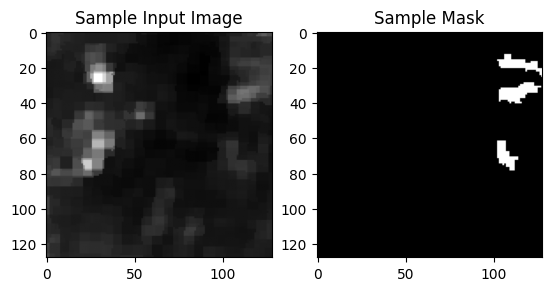

In [ ]:
import matplotlib.pyplot as plt

# Show input image (first channel), and corresponding mask
plt.subplot(1, 2, 1)
plt.imshow(X_train[0, :, :, 0], cmap='gray')
plt.title("Sample Input Image")

plt.subplot(1, 2, 2)
plt.imshow(y_train[0, :, :, 0], cmap='gray')
plt.title("Sample Mask")

plt.show()


In [ ]:
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1e-7) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1e-7)

model.compile(
    optimizer=Adam(),
    loss=dice_loss,
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score')
    ]
)


In [ ]:
loss, accuracy, precision, recall, f1_score = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")


Loss: 0.9892
Accuracy: 0.9900
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


In [ ]:
# Predict on validation data
preds = model.predict(X_val)
preds_binary = (preds > 0.5).astype(np.uint8)

# Flatten for metric calculation
y_true = y_val.flatten()
y_pred = preds_binary.flatten()

# Compute metrics manually
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("Manual Precision:", precision)
print("Manual Recall:", recall)
print("Manual F1 Score:", f1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
Manual Precision: 0.0
Manual Recall: 0.0
Manual F1 Score: 0.0


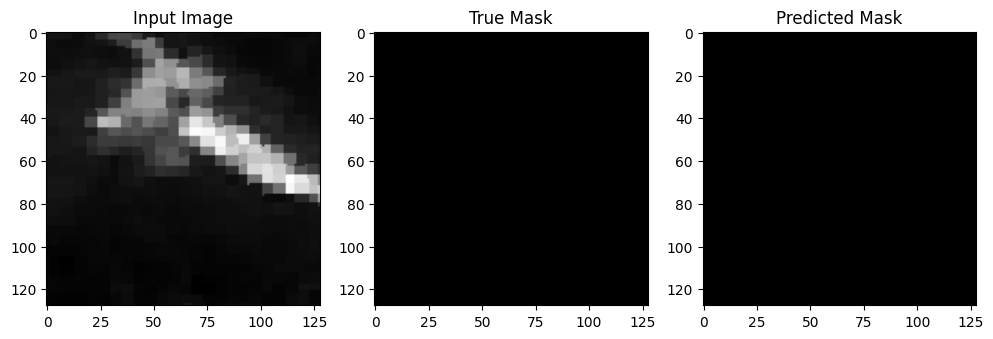

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X_val[0, :, :, 0], cmap='gray')
plt.title('Input Image')

plt.subplot(1,3,2)
plt.imshow(y_val[0, :, :, 0], cmap='gray')
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(preds_binary[0, :, :, 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()


In [ ]:
import os
import numpy as np
import h5py
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Custom metrics
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# U-Net model definition
def unet_model(height, width, channels):
    inputs = layers.Input((height, width, channels))

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def encoder_block(x, filters):
        c = conv_block(x, filters)
        p = layers.MaxPooling2D((2, 2))(c)
        return c, p

    def decoder_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.Concatenate()([x, skip])
        x = conv_block(x, filters)
        return x

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])
    return model

# Load HDF5 data and resize
def load_h5_data(img_folder, mask_folder):
    image_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.h5')])
    images, masks = [], []
    for file in image_files:
        with h5py.File(os.path.join(img_folder, file), 'r') as hf:
            img = hf['image'][:]
        with h5py.File(os.path.join(mask_folder, file.replace('image', 'mask')), 'r') as hf:
            mask = hf['mask'][:]

        img = tf.image.resize(img, (128, 128)).numpy()
        mask = tf.image.resize(mask, (128, 128)).numpy()

        images.append(img)
        masks.append(mask[..., np.newaxis])

    return np.array(images), np.array(masks)

# Load data
x_train, y_train = load_h5_data('./TrainData/img', './TrainData/mask')
x_valid, y_valid = load_h5_data('./ValidData/img', './ValidData/mask')

# Normalize data
x_train, x_valid = x_train / 255.0, x_valid / 255.0
y_train, y_valid = y_train / 255.0, y_valid / 255.0

# Create model
model = unet_model(128, 128, 6)

# Callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint("best_model.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
callbacks = [checkpointer]

# Train model
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=100,
                    verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=callbacks)

# Save model
model.save("model_save.h5")

# Evaluate
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)


OSError: [Errno 107] Transport endpoint is not connected: './TrainData/img'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
img_folder = "/content/drive/MyDrive/SDP_FILES/TrainData/img"
mask_folder = "/content/drive/MyDrive/SDP_FILES/TrainData/mask"


In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Resize function
def resize_image(img, size=(128, 128)):
    return tf.image.resize(img, size).numpy()

# Load HDF5 data
def load_h5_data(img_folder, mask_folder):
    image_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.h5')])
    images, masks = [], []
    for file in image_files:
        with h5py.File(os.path.join(img_folder, file), 'r') as f:
            img = f['image'][:]
            img = resize_image(img, (128, 128))
            images.append(img)

        with h5py.File(os.path.join(mask_folder, file.replace('image', 'mask')), 'r') as f:
            mask = f['mask'][:]
            mask = resize_image(mask, (128, 128))
            masks.append(mask)
    return np.array(images), np.array(masks)

# U-Net model
def unet_model(img_height, img_width, img_channels):
    inputs = Input((img_height, img_width, img_channels))

    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Metrics
def f1_m(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=[1,2,3])
    tn = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=[1,2,3])
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=[1,2,3])
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=[1,2,3])
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    return K.mean(2 * ((precision * recall) / (precision + recall + K.epsilon())))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

# ==== Load data ====
x_train, y_train = load_h5_data('/content/drive/MyDrive/SDP FILES/TrainData/img', '/content/drive/MyDrive/SDP FILES/TrainData/mask')
x_valid, y_valid = load_h5_data('/content/drive/MyDrive/SDP FILES/ValidData/img', '/content/drive/MyDrive/SDP FILES/ValidData/mask')

# ==== Build and compile model ====
model = unet_model(128, 128, 6)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])

# ==== Callbacks ====
checkpointer = ModelCheckpoint("best_model.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")

# ==== Train ====
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=100,
                    verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer])

# ==== Save final model ====
model.save("model_save.h5")

# ==== Evaluate ====
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyError: "Unable to synchronously open object (object 'image' doesn't exist)"

In [ ]:
import h5py

# Explore a sample file to check its structure
sample_img_path = '/content/drive/MyDrive/SDP FILES/TrainData/img/image_1.h5'
sample_mask_path = '/content/drive/MyDrive/SDP FILES/TrainData/mask/mask_1.h5'

with h5py.File(sample_img_path, 'r') as f:
    print("Keys in image file:", list(f.keys()))

with h5py.File(sample_mask_path, 'r') as f:
    print("Keys in mask file:", list(f.keys()))


Keys in image file: ['img']
Keys in mask file: ['mask']


In [ ]:
def load_h5_data(img_folder, mask_folder):
    image_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.h5')])
    images, masks = [], []
    for file in image_files:
        with h5py.File(os.path.join(img_folder, file), 'r') as f:
            img = f['data'][:]  # Adjusted key name
            img = resize_image(img, (128, 128))
            images.append(img)

        with h5py.File(os.path.join(mask_folder, file.replace('image', 'mask')), 'r') as f:
            mask = f['data'][:]  # Adjusted key name
            mask = resize_image(mask, (128, 128))
            masks.append(mask)
    return np.array(images), np.array(masks)


In [ ]:
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

# ==== Data Loading and Preprocessing ====

# Function to resize images
def resize_image(img, target_size):
    return np.array(image.smart_resize(img, target_size))

# Load HDF5 data from folders
def load_h5_data(img_folder, mask_folder):
    image_files = sorted([f for f in os.listdir(img_folder) if f.endswith('.h5')])
    images, masks = [], []
    for file in image_files:
        # Load image data
        with h5py.File(os.path.join(img_folder, file), 'r') as f:
            img = f['img'][:]  # Corrected key for images
            img = resize_image(img, (128, 128))  # Resize image
            images.append(img)

        # Load mask data
        with h5py.File(os.path.join(mask_folder, file.replace('image', 'mask')), 'r') as f:
            mask = f['mask'][:]  # Corrected key for masks
            mask = resize_image(mask, (128, 128))  # Resize mask
            masks.append(mask)

    return np.array(images), np.array(masks)

# ==== U-Net Model ====

def unet_model(input_height, input_width, num_classes):
    inputs = layers.Input(shape=(input_height, input_width, 3))

    # Encoder: Contracting Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoder: Expanding Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output Layer
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# ==== Model Training ====

# Load data
x_train, y_train = load_h5_data('/content/drive/MyDrive/SDP FILES/TrainData/img', '/content/drive/MyDrive/SDP FILES/TrainData/mask')
x_valid, y_valid = load_h5_data('/content/drive/MyDrive/SDP FILES/ValidData/img', '/content/drive/MyDrive/SDP FILES/ValidData/mask')

# Create U-Net model
model = unet_model(128, 128, 6)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall(),
    tf.keras.metrics.AUC(),
    tf.keras.metrics.F1Score(num_classes=6)])

# Callbacks
checkpointer = ModelCheckpoint("best_model.h5", monitor="val_f1_score", verbose=1, save_best_only=True, mode="max")

callbacks = [checkpointer]

# Train model
history = model.fit(x_train, y_train, batch_size=16, epochs=100, verbose=2,
          validation_data=(x_valid, y_valid), callbacks=callbacks)

# Save model
model.save("model_save.h5")

# Evaluate model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)


ValueError: Expected an image array with shape `(height, width, channels)`, or `(batch_size, height, width, channels)`, but got input with incorrect rank, of shape (128, 128).

In [ ]:
# Compile model without num_classes argument for F1Score
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.AUC(),
                  tf.keras.metrics.F1Score()])


In [ ]:
import tensorflow as tf

# Custom F1 score metric
def f1_score(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    # Calculate Precision and Recall
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + epsilon)

# Model compilation with custom F1 score
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use the appropriate loss for multi-class classification
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  f1_score])


In [ ]:
import tensorflow as tf

# Define a custom F1 Score metric
def f1_score(y_true, y_pred):
    precision = tf.keras.metrics.Precision()(y_true, y_pred)
    recall = tf.keras.metrics.Recall()(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

# Example model compilation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Precision(),
                  tf.keras.metrics.Recall(),
                  f1_score])


In [ ]:
# U-Net Model Definition for 14 channels input
def unet_model(input_height, input_width, num_channels):
    inputs = tf.keras.layers.Input((input_height, input_width, num_channels))  # Adjusted for 14 channels

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottom (Bottleneck)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=3)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=3)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=3)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # For binary classification

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [ ]:
def load_h5_data(image_dir, mask_dir):
    image_files = sorted(glob.glob(image_dir + "/*.h5"))
    mask_files = sorted(glob.glob(mask_dir + "/*.h5"))

    x_data = np.zeros((len(image_files), 128, 128, 3))  # Now using 3 channels
    y_data = np.zeros((len(mask_files), 128, 128, 1))  # Assuming binary masks

    for i, img_file in enumerate(image_files):
        with h5py.File(img_file, 'r') as f:
            img_data = np.array(f['img'])
            x_data[i] = img_data[:, :, :3]  # Select only the first 3 channels (e.g., RGB)

    for i, mask_file in enumerate(mask_files):
        with h5py.File(mask_file, 'r') as f:
            y_data[i] = np.array(f['mask'])

    return x_data, y_data


In [ ]:
# Inspect one file to see the actual shape
with h5py.File(glob.glob(train_image_dir + "/*.h5")[0], 'r') as f:
    print(list(f.keys()))  # Show all datasets in the file
    sample_data = np.array(f['img'])
    print("Image shape:", sample_data.shape)

['img']
Image shape: (128, 128, 14)


In [ ]:
def load_h5_data(image_dir, mask_dir):
    image_files = sorted(glob.glob(image_dir + "/*.h5"))
    mask_files = sorted(glob.glob(mask_dir + "/*.h5"))

    # First check the shape of one image to determine channels
    with h5py.File(image_files[0], 'r') as f:
        sample_img = np.array(f['img'])
        img_shape = sample_img.shape

    # Initialize arrays with correct shape
    x_data = np.zeros((len(image_files), *img_shape))  # Use actual image shape
    y_data = np.zeros((len(mask_files), 128, 128, 1))  # Assuming binary masks

    for i, img_file in enumerate(image_files):
        with h5py.File(img_file, 'r') as f:
            x_data[i] = np.array(f['img'])

    for i, mask_file in enumerate(mask_files):
        with h5py.File(mask_file, 'r') as f:
            y_data[i] = np.array(f['mask'])

    return x_data, y_data

In [ ]:
# After loading data, check the number of channels
num_channels = x_train.shape[-1]
model = unet_model(128, 128, num_channels)  # Use actual number of channels

In [ ]:
def load_h5_data(image_dir, mask_dir):
    image_files = sorted(glob.glob(image_dir + "/*.h5"))
    mask_files = sorted(glob.glob(mask_dir + "/*.h5"))

    x_data = np.zeros((len(image_files), 128, 128, 3))  # Only take first 3 channels
    y_data = np.zeros((len(mask_files), 128, 128, 1))  # Assuming binary masks

    for i, img_file in enumerate(image_files):
        with h5py.File(img_file, 'r') as f:
            img_data = np.array(f['img'])
            x_data[i] = img_data[..., :3]  # Take only first 3 channels

    for i, mask_file in enumerate(mask_files):
        with h5py.File(mask_file, 'r') as f:
            y_data[i] = np.array(f['mask'])

    return x_data, y_data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
import h5py
import numpy as np
import glob
import matplotlib.pyplot as plt

# U-Net Model Definition
def unet_model(input_height, input_width, num_channels):
    inputs = tf.keras.layers.Input((input_height, input_width, num_channels))

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottom (Bottleneck)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expanding Path (Decoder)
    u6 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4], axis=3)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3], axis=3)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2], axis=3)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)  # For binary classification

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

def load_h5_data(image_dir, mask_dir):
    image_files = sorted(glob.glob(image_dir + "/*.h5"))
    mask_files = sorted(glob.glob(mask_dir + "/*.h5"))

    # First check the shape of one image to determine channels
    with h5py.File(image_files[0], 'r') as f:
        sample_img = np.array(f['img'])
        img_shape = sample_img.shape

    # Initialize arrays with correct shape
    x_data = np.zeros((len(image_files), *img_shape))  # Use actual image shape
    y_data = np.zeros((len(mask_files), img_shape[0], img_shape[1], 1))  # Assuming binary masks

    for i, img_file in enumerate(image_files):
        with h5py.File(img_file, 'r') as f:
            x_data[i] = np.array(f['img'])

    for i, mask_file in enumerate(mask_files):
        with h5py.File(mask_file, 'r') as f:
            y_data[i] = np.expand_dims(np.array(f['mask']), axis=-1)  # Ensure mask has channel dimension

    return x_data, y_data

# Directories for training and validation data
train_image_dir = '/content/drive/MyDrive/SDP FILES/TrainData/img'
train_mask_dir = '/content/drive/MyDrive/SDP FILES/TrainData/mask'
valid_image_dir = '/content/drive/MyDrive/SDP FILES/ValidData/img'
valid_mask_dir = '/content/drive/MyDrive/SDP FILES/ValidData/mask'

# Load data
x_train, y_train = load_h5_data(train_image_dir, train_mask_dir)
x_valid, y_valid = load_h5_data(valid_image_dir, valid_mask_dir)

# Check data shapes
print("Training data shape:", x_train.shape)
print("Training masks shape:", y_train.shape)
print("Validation data shape:", x_valid.shape)
print("Validation masks shape:", y_valid.shape)

# Normalize data
x_train = x_train / 255.0
x_valid = x_valid / 255.0

# Get number of channels from data
num_channels = x_train.shape[-1]

# Create U-Net model with correct number of input channels
model = unet_model(x_train.shape[1], x_train.shape[2], num_channels)

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),
                       tf.keras.metrics.MeanIoU(num_classes=2)])

# Callbacks
checkpointer = ModelCheckpoint("best_model.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")
callbacks = [checkpointer]

# Train the model
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=100,
                    verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=callbacks)

# Save the model
model.save("model_save.h5")

# Evaluate the model
loss, precision, recall, auc, miou = model.evaluate(x_valid, y_valid, verbose=0)
print(f"Loss: {loss}, Precision: {precision}, Recall: {recall}, AUC: {auc}, IoU: {miou}")

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes[0, 0].plot(history.history['loss'])
axes[0, 0].plot(history.history['val_loss'])
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')

axes[0, 1].plot(history.history['precision'])
axes[0, 1].plot(history.history['val_precision'])
axes[0, 1].set_title('Precision')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Precision')

axes[1, 0].plot(history.history['recall'])
axes[1, 0].plot(history.history['val_recall'])
axes[1, 0].set_title('Recall')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Recall')

axes[1, 1].plot(history.history['auc'])
axes[1, 1].plot(history.history['val_auc'])
axes[1, 1].set_title('AUC')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('AUC')

plt.show()

# Predict on validation data
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

# Visualize prediction vs true mask
sample_idx = 0  # Change this to view different samples
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes[0].imshow(pred_img[sample_idx, :, :, 0], cmap='gray')
axes[0].set_title("Prediction")
axes[1].imshow(y_valid[sample_idx, :, :, 0], cmap='gray')
axes[1].set_title("True Mask")

# For visualization, show first 3 channels of input image
if x_valid.shape[-1] >= 3:
    axes[2].imshow(x_valid[sample_idx, :, :, :3])
else:
    axes[2].imshow(x_valid[sample_idx, :, :, 0], cmap='gray')
axes[2].set_title('Input Image (first 3 channels)')

plt.show()

In [ ]:
print(x_valid.shape)  # This should output (num_samples, 128, 128, 14)


(245, 128, 128, 3)


In [ ]:
# If x_valid only has 3 channels, you can artificially add channels:
x_valid_14 = np.concatenate([x_valid, np.zeros((x_valid.shape[0], 128, 128, 11))], axis=-1)


In [ ]:
model = unet_model(128, 128, 3)  # Use 3 channels for RGB images


In [ ]:
# Install required packages
!pip install h5py

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import gc
from sklearn.metrics import auc, roc_curve

# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 1. FAST Data Generator with Image Downscaling
class FastH5Generator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, target_size=(64,64), batch_size=16):
        self.image_files = sorted(glob.glob(image_dir + "/*.h5"))
        self.mask_files = sorted(glob.glob(mask_dir + "/*.h5"))
        self.batch_size = batch_size
        self.target_size = target_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        x_batch = np.zeros((self.batch_size, *self.target_size, 3))  # Using only first 3 channels
        y_batch = np.zeros((self.batch_size, *self.target_size, 1))

        for i, idx in enumerate(batch_indices):
            # Load and resize images
            with h5py.File(self.image_files[idx], 'r') as f:
                img = np.array(f['img'])[..., :3]  # Take only RGB channels
                img = tf.image.resize(img, self.target_size).numpy()
                x_batch[i] = img / 255.0

            # Load and resize masks
            with h5py.File(self.mask_files[idx], 'r') as f:
                mask = np.array(f['mask'])
                mask = tf.image.resize(mask[..., np.newaxis], self.target_size).numpy()
                y_batch[i] = mask

        return x_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_files))
        np.random.shuffle(self.indices)

# 2. LIGHTWEIGHT U-Net Model
def build_light_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Downsample
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    p1 = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    p2 = layers.MaxPooling2D()(x)

    # Bottleneck
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

    # Upsample
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)

# 3. FAST Training Function
def train_model():
    # Initialize paths
    train_img_dir = '/content/drive/MyDrive/SDP FILES/TrainData/img'
    train_mask_dir = '/content/drive/MyDrive/SDP FILES/TrainData/mask'
    val_img_dir = '/content/drive/MyDrive/SDP FILES/ValidData/img'
    val_mask_dir = '/content/drive/MyDrive/SDP FILES/ValidData/mask'

    # Create generators with reduced image size
    batch_size = 32  # Increased batch size for speed
    target_size = (64, 64)  # Reduced from 128x128 or 256x256

    train_gen = FastH5Generator(train_img_dir, train_mask_dir, target_size, batch_size)
    val_gen = FastH5Generator(val_img_dir, val_mask_dir, target_size, batch_size)

    # Build lightweight model
    model = build_light_unet((*target_size, 3))
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    # Simple callbacks
    callbacks_list = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('fast_model.h5', save_best_only=True)
    ]

    # Train
    history = model.fit(train_gen,
                      validation_data=val_gen,
                      epochs=10,  # Reduced epochs
                      callbacks=callbacks_list,
                      verbose=1)

    # Quick evaluation
    print("\nFinal Metrics:")
    results = model.evaluate(val_gen)
    print(f"Loss: {results[0]:.4f}, Accuracy: {results[1]:.4f}, AUC: {results[2]:.4f}")

    return model, history

# Run training
model, history = train_model()

# Clean up
gc.collect()

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9326 - auc: 0.4949 - loss: 0.4136

118/118 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9329 - auc: 0.4949 - loss: 0.4121 - val_accuracy: 0.9786 - val_auc: 0.4969 - val_loss: 0.1018
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9698 - auc: 0.5052 - loss: 0.1162

118/118 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.9698 - auc: 0.5052 - loss: 0.1162 - val_accuracy: 0.9824 - val_auc: 0.4980 - val_loss: 0.0768
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 114s 960ms/step - accuracy: 0.9697 - auc: 0.4899 - loss: 0.1155 - val_accuracy: 0.9813 - val_auc: 0.5031 - val_loss: 0.0829
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 111s 941ms/step - accuracy: 0.9692 - auc: 0.5028 - loss: 0.1157 - val_accuracy: 0.9814 - val_auc: 0.5027 - val_loss: 0.0817
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.9708 - auc: 0.4998 - loss: 0.1100 - val_accuracy: 0.9788 - val_auc: 0.4979 - val_loss: 0.0908

Final Metrics:
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 474ms/step - accuracy: 0.9833 - auc: 0.4982 - loss: 0.0723
Loss: 0.0876, Accuracy: 0.9797, AUC: 0.4947


2488

In [ ]:
# Install required packages
!pip install h5py scikit-learn

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import gc
from sklearn.metrics import f1_score, precision_score, recall_score

# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 1. FAST Data Generator with Metrics Support
class FastH5Generator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, target_size=(64,64), batch_size=16):
        self.image_files = sorted(glob.glob(image_dir + "/*.h5"))
        self.mask_files = sorted(glob.glob(mask_dir + "/*.h5"))
        self.batch_size = batch_size
        self.target_size = target_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        x_batch = np.zeros((self.batch_size, *self.target_size, 3))  # Using only first 3 channels
        y_batch = np.zeros((self.batch_size, *self.target_size, 1))

        for i, idx in enumerate(batch_indices):
            with h5py.File(self.image_files[idx], 'r') as f:
                img = np.array(f['img'])[..., :3]  # Take only RGB channels
                img = tf.image.resize(img, self.target_size).numpy()
                x_batch[i] = img / 255.0

            with h5py.File(self.mask_files[idx], 'r') as f:
                mask = np.array(f['mask'])
                mask = tf.image.resize(mask[..., np.newaxis], self.target_size).numpy()
                y_batch[i] = mask

        return x_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_files))
        np.random.shuffle(self.indices)

    def get_all_data(self):
        x = np.zeros((len(self.image_files), *self.target_size, 3))
        y = np.zeros((len(self.image_files), *self.target_size, 1))
        for i in range(len(self.image_files)):
            with h5py.File(self.image_files[i], 'r') as f:
                img = np.array(f['img'])[..., :3]
                x[i] = tf.image.resize(img, self.target_size).numpy() / 255.0
            with h5py.File(self.mask_files[i], 'r') as f:
                mask = np.array(f['mask'])
                y[i] = tf.image.resize(mask[..., np.newaxis], self.target_size).numpy()
        return x, y

# 2. LIGHTWEIGHT U-Net with Metrics
def build_light_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Downsample
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    p1 = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    p2 = layers.MaxPooling2D()(x)

    # Bottleneck
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

    # Upsample
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)

# 3. Custom Metrics Calculation
def calculate_metrics(model, generator):
    x_val, y_val = generator.get_all_data()
    y_pred = model.predict(x_val)

    # Flatten arrays for metric calculation
    y_true_flat = y_val.reshape(-1)
    y_pred_flat = (y_pred > 0.5).reshape(-1)

    # Calculate metrics
    loss = tf.keras.losses.binary_crossentropy(y_true_flat, y_pred.reshape(-1)).numpy().mean()
    accuracy = np.mean(y_true_flat == (y_pred_flat > 0.5))
    f1 = f1_score(y_true_flat, y_pred_flat)
    precision = precision_score(y_true_flat, y_pred_flat)
    recall = recall_score(y_true_flat, y_pred_flat)

    return loss, accuracy, f1, precision, recall

# 4. FAST Training Function with Full Metrics
def train_model():
    # Initialize paths
    train_img_dir = '/content/drive/MyDrive/SDP FILES/TrainData/img'
    train_mask_dir = '/content/drive/MyDrive/SDP FILES/TrainData/mask'
    val_img_dir = '/content/drive/MyDrive/SDP FILES/ValidData/img'
    val_mask_dir = '/content/drive/MyDrive/SDP FILES/ValidData/mask'

    # Create generators
    batch_size = 32
    target_size = (64, 64)

    train_gen = FastH5Generator(train_img_dir, train_mask_dir, target_size, batch_size)
    val_gen = FastH5Generator(val_img_dir, val_mask_dir, target_size, batch_size)

    # Build model
    model = build_light_unet((*target_size, 3))
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    # Callbacks
    callbacks_list = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

    # Train
    history = model.fit(train_gen,
                      validation_data=val_gen,
                      epochs=10,
                      callbacks=callbacks_list,
                      verbose=1)

    # Calculate all metrics
    loss, accuracy, f1, precision, recall = calculate_metrics(model, val_gen)

    print("\nFinal Metrics:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return model, history, (loss, accuracy, f1, precision, recall)

# Run training
model, history, metrics = train_model()

# Clean up
gc.collect()

Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 120s 973ms/step - accuracy: 0.9534 - auc: 0.4875 - loss: 0.3394 - val_accuracy: 0.9825 - val_auc: 0.4924 - val_loss: 0.0794
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 106s 895ms/step - accuracy: 0.9702 - auc: 0.4875 - loss: 0.1146 - val_accuracy: 0.9791 - val_auc: 0.5060 - val_loss: 0.0901
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 153s 983ms/step - accuracy: 0.9698 - auc: 0.4903 - loss: 0.1168 - val_accuracy: 0.9794 - val_auc: 0.5041 - val_loss: 0.0904
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 106s 893ms/step - accuracy: 0.9706 - auc: 0.4854 - loss: 0.1116 - val_accuracy: 0.9801 - val_auc: 0.5210 - val_loss: 0.0934
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step


ValueError: Classification metrics can't handle a mix of continuous and binary targets

In [ ]:
# Install required packages
!pip install h5py scikit-learn

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import gc
from sklearn.metrics import f1_score, precision_score, recall_score

# Configure GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# 1. Data Generator with Proper Binarization
class H5DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, target_size=(64,64), batch_size=16):
        self.image_files = sorted(glob.glob(image_dir + "/*.h5"))
        self.mask_files = sorted(glob.glob(mask_dir + "/*.h5"))
        self.batch_size = batch_size
        self.target_size = target_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        x_batch = np.zeros((self.batch_size, *self.target_size, 3))
        y_batch = np.zeros((self.batch_size, *self.target_size, 1))

        for i, idx in enumerate(batch_indices):
            with h5py.File(self.image_files[idx], 'r') as f:
                img = np.array(f['img'])[..., :3]
                img = tf.image.resize(img, self.target_size).numpy()
                x_batch[i] = img / 255.0

            with h5py.File(self.mask_files[idx], 'r') as f:
                mask = np.array(f['mask'])
                mask = tf.image.resize(mask[..., np.newaxis], self.target_size).numpy()
                y_batch[i] = (mask > 0.5).astype(np.float32)  # Binarize masks

        return x_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_files))
        np.random.shuffle(self.indices)

    def get_all_data(self):
        x = np.zeros((len(self.image_files), *self.target_size, 3))
        y = np.zeros((len(self.image_files), *self.target_size, 1))
        for i in range(len(self.image_files)):
            with h5py.File(self.image_files[i], 'r') as f:
                img = np.array(f['img'])[..., :3]
                x[i] = tf.image.resize(img, self.target_size).numpy() / 255.0
            with h5py.File(self.mask_files[i], 'r') as f:
                mask = np.array(f['mask'])
                y[i] = (tf.image.resize(mask[..., np.newaxis], self.target_size).numpy() > 0.5).astype(np.float32)
        return x, y

# 2. U-Net Model
def build_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Downsample
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    p1 = layers.MaxPooling2D()(x)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    p2 = layers.MaxPooling2D()(x)

    # Bottleneck
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)

    # Upsample
    x = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)

    x = layers.Conv2DTranspose(16, 3, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)

# 3. Proper Metric Calculation
def calculate_metrics(model, generator, threshold=0.5):
    x_val, y_val = generator.get_all_data()
    y_pred = model.predict(x_val, verbose=0)

    # Flatten and binarize
    y_true = y_val.reshape(-1)
    y_pred_bin = (y_pred > threshold).astype(np.float32).reshape(-1)

    # Only calculate metrics where we have both classes present
    if len(np.unique(y_true)) > 1:
        f1 = f1_score(y_true, y_pred_bin)
        precision = precision_score(y_true, y_pred_bin)
        recall = recall_score(y_true, y_pred_bin)
    else:
        f1, precision, recall = 0.0, 0.0, 0.0

    # Calculate loss and accuracy
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred.reshape(-1)).numpy().mean()
    accuracy = np.mean(y_true == (y_pred_bin))

    return loss, accuracy, f1, precision, recall

# 4. Training Function
def train_model():
    # Initialize paths
    train_img_dir = '/content/drive/MyDrive/SDP FILES/TrainData/img'
    train_mask_dir = '/content/drive/MyDrive/SDP FILES/TrainData/mask'
    val_img_dir = '/content/drive/MyDrive/SDP FILES/ValidData/img'
    val_mask_dir = '/content/drive/MyDrive/SDP FILES/ValidData/mask'

    # Create generators
    batch_size = 32
    target_size = (64, 64)

    train_gen = H5DataGenerator(train_img_dir, train_mask_dir, target_size, batch_size)
    val_gen = H5DataGenerator(val_img_dir, val_mask_dir, target_size, batch_size)

    # Build model
    model = build_unet((*target_size, 3))
    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    # Callbacks
    callbacks_list = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

    # Train
    history = model.fit(train_gen,
                      validation_data=val_gen,
                      epochs=10,
                      callbacks=callbacks_list,
                      verbose=1)

    # Calculate metrics
    loss, accuracy, f1, precision, recall = calculate_metrics(model, val_gen)

    print("\nFinal Metrics:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return model, history, (loss, accuracy, f1, precision, recall)

# Run training
model, history, metrics = train_model()

# Clean up
gc.collect()

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 120s 973ms/step - accuracy: 0.9772 - auc: 0.4902 - loss: 0.2956 - val_accuracy: 0.9835 - val_auc: 0.4836 - val_loss: 0.0862
Epoch 2/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.9801 - auc: 0.4957 - loss: 0.0989 - val_accuracy: 0.9835 - val_auc: 0.5266 - val_loss: 0.0841
Epoch 3/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 108s 913ms/step - accuracy: 0.9800 - auc: 0.5092 - loss: 0.0999 - val_accuracy: 0.9867 - val_auc: 0.5640 - val_loss: 0.0759
Epoch 4/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 109s 925ms/step - accuracy: 0.9794 - auc: 0.5341 - loss: 0.1012 - val_accuracy: 0.9861 - val_auc: 0.6092 - val_loss: 0.0781
Epoch 5/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 147s 965ms/step - accuracy: 0.9800 - auc: 0.6397 - loss: 0.0954 - val_accuracy: 0.9835 - val_auc: 0.8071 - val_loss: 0.0723
Epoch 6/10
118/118 ━━━━━━━━━━━━━━━━━━━━ 113s 956ms/step - accuracy: 0.9812 - auc: 0.8831 - loss: 0.0678 - val_accuracy: 0.9838 - val_auc: 0.8893 - val_loss: 0.0660
Epoch 7/10
118/118 

7017

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9722 - auc: 0.4807 - loss: 0.3064

118/118 ━━━━━━━━━━━━━━━━━━━━ 468s 4s/step - accuracy: 0.9723 - auc: 0.4807 - loss: 0.3053 - val_accuracy: 0.9826 - val_auc: 0.4960 - val_loss: 0.0915 - learning_rate: 0.0010
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9763 - auc: 0.5423 - loss: 0.1139

118/118 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9763 - auc: 0.5426 - loss: 0.1138 - val_accuracy: 0.9818 - val_auc: 0.6999 - val_loss: 0.0906 - learning_rate: 0.0010
Epoch 3/20


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9767 - auc: 0.6778 - loss: 0.1070

118/118 ━━━━━━━━━━━━━━━━━━━━ 505s 4s/step - accuracy: 0.9767 - auc: 0.6783 - loss: 0.1070 - val_accuracy: 0.9842 - val_auc: 0.7981 - val_loss: 0.0773 - learning_rate: 0.0010
Epoch 4/20


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


118/118 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9769 - auc: 0.8415 - loss: 0.0899 - val_accuracy: 0.9819 - val_auc: 0.8295 - val_loss: 0.0884 - learning_rate: 0.0010
Epoch 5/20


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9777 - auc: 0.8818 - loss: 0.0798

118/118 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.9777 - auc: 0.8819 - loss: 0.0798 - val_accuracy: 0.9829 - val_auc: 0.8635 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9787 - auc: 0.9213 - loss: 0.0675

118/118 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9787 - auc: 0.9213 - loss: 0.0675 - val_accuracy: 0.9823 - val_auc: 0.9013 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.9765 - auc: 0.9344 - loss: 0.0688 - val_accuracy: 0.9822 - val_auc: 0.8907 - val_loss: 0.0657 - learning_rate: 0.0010
Epoch 8/20


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9778 - auc: 0.9427 - loss: 0.0640

118/118 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9778 - auc: 0.9427 - loss: 0.0640 - val_accuracy: 0.9828 - val_auc: 0.8995 - val_loss: 0.0609 - learning_rate: 0.0010
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9786 - auc: 0.9410 - loss: 0.0622

118/118 ━━━━━━━━━━━━━━━━━━━━ 444s 4s/step - accuracy: 0.9786 - auc: 0.9410 - loss: 0.0622 - val_accuracy: 0.9850 - val_auc: 0.8883 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.9781 - auc: 0.9449 - loss: 0.0622 - val_accuracy: 0.9831 - val_auc: 0.9023 - val_loss: 0.0617 - learning_rate: 0.0010
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9782 - auc: 0.9485 - loss: 0.0615
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
118/118 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.9782 - auc: 0.9485 - loss: 0.0615 - val_accuracy: 0.9827 - val_auc: 0.9050 - val_loss: 0.0618 - learning_rate: 0.0010
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 443s 4s/step - accuracy: 0.9786 - auc: 0.9504 - loss: 0.0598 - val_accuracy: 0.9828 - val_auc: 0.8948 - val_loss: 0.0631 - learning_rate: 5.0000e-04
Epoch 13/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9794 - auc: 0.9544 - loss: 0.0572

118/118 ━━━━━━━━━━━━━━━━━━━━ 513s 4s/step - accuracy: 0.9787 - auc: 0.9520 - loss: 0.0591 - val_accuracy: 0.9845 - val_auc: 0.9014 - val_loss: 0.0546 - learning_rate: 2.5000e-04
Epoch 15/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.9790 - auc: 0.9546 - loss: 0.0578 - val_accuracy: 0.9823 - val_auc: 0.9150 - val_loss: 0.0593 - learning_rate: 2.5000e-04
Epoch 16/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9793 - auc: 0.9532 - loss: 0.0580
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
118/118 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.9793 - auc: 0.9532 - loss: 0.0580 - val_accuracy: 0.9823 - val_auc: 0.9179 - val_loss: 0.0572 - learning_rate: 2.5000e-04
Epoch 17/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 440s 4s/step - accuracy: 0.9783 - auc: 0.9559 - loss: 0.0594 - val_accuracy: 0.9818 - val_auc: 0.8983 - val_loss: 0.0642 - learning_rate: 1.2500e-04
Epoch 18/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9787 - auc: 0.9558 - 

118/118 ━━━━━━━━━━━━━━━━━━━━ 439s 4s/step - accuracy: 0.9782 - auc: 0.9544 - loss: 0.0600 - val_accuracy: 0.9850 - val_auc: 0.9348 - val_loss: 0.0483 - learning_rate: 6.2500e-05
Epoch 20/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 446s 4s/step - accuracy: 0.9782 - auc: 0.9560 - loss: 0.0593 - val_accuracy: 0.9825 - val_auc: 0.9139 - val_loss: 0.0582 - learning_rate: 6.2500e-05


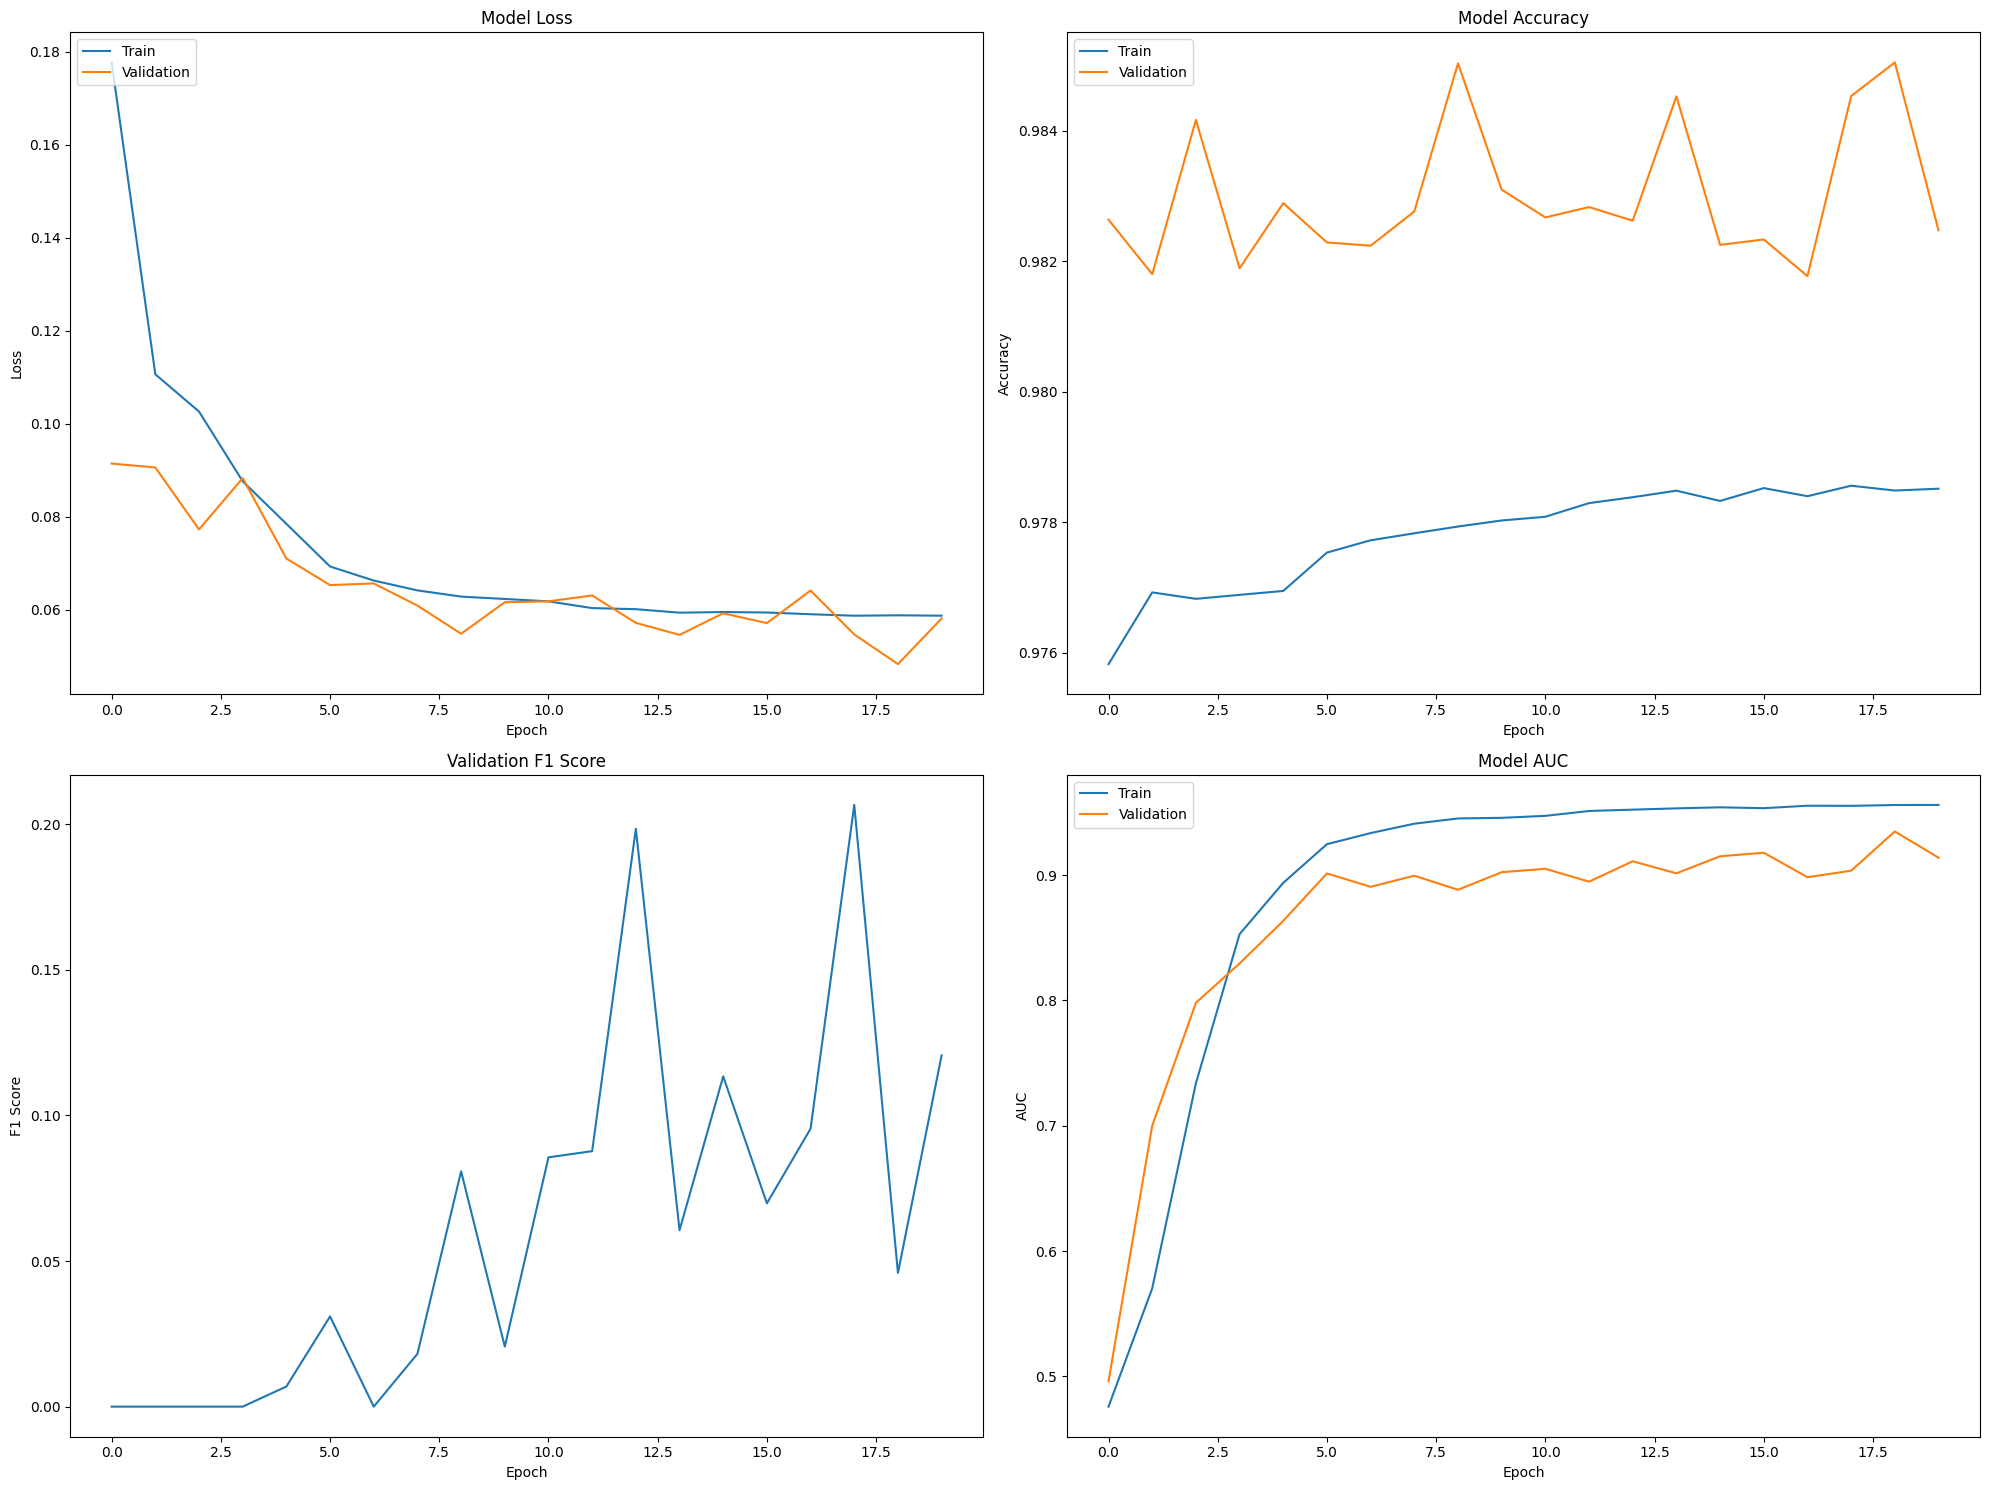

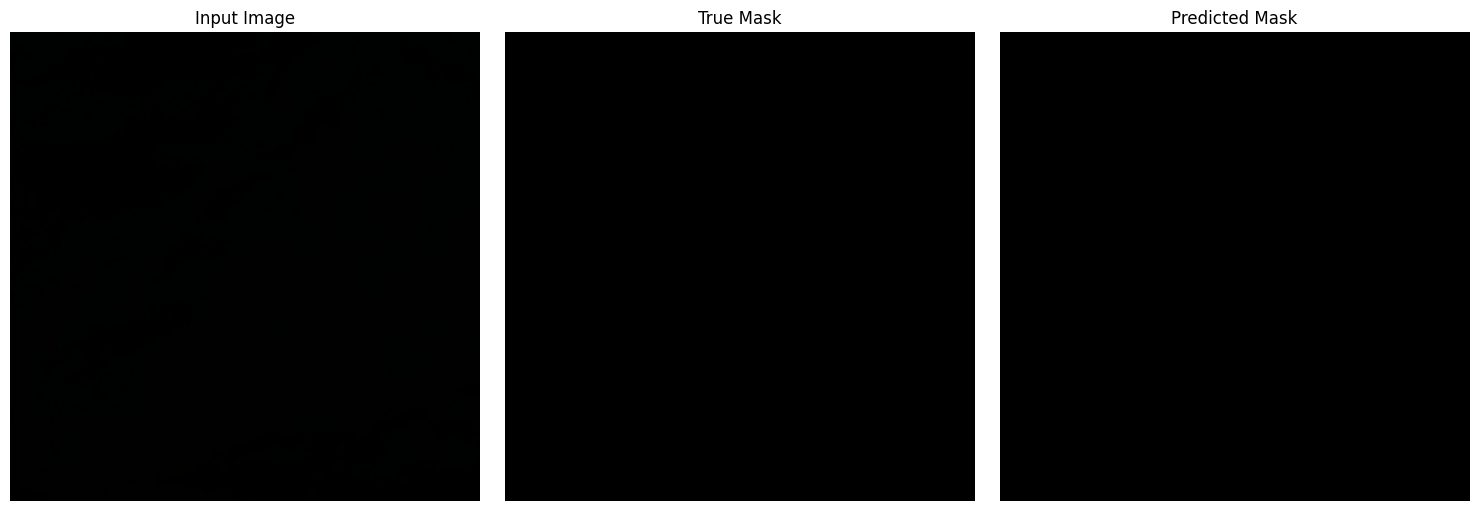


Final Metrics:
Loss: 0.0563
Accuracy: 0.9832
F1 Score: 0.0903
Precision: 0.6217
Recall: 0.0487


36360

In [ ]:
!pip install h5py scikit-learn

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
import numpy as np
import matplotlib.pyplot as plt
import h5py
import glob
import gc
from sklearn.metrics import f1_score, precision_score, recall_score

# Configure GPU for maximum performance
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.optimizer.set_jit(True)  # Enable XLA compilation
    except RuntimeError as e:
        print(e)

# 1. Optimized Data Generator
class FastH5Generator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, target_size=(128,128), batch_size=32):
        self.image_files = sorted(glob.glob(image_dir + "/*.h5"))
        self.mask_files = sorted(glob.glob(mask_dir + "/*.h5"))
        self.batch_size = batch_size
        self.target_size = target_size
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_files) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        x_batch = np.zeros((self.batch_size, *self.target_size, 3), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, *self.target_size, 1), dtype=np.float32)

        for i, idx in enumerate(batch_indices):
            with h5py.File(self.image_files[idx], 'r') as f:
                img = np.array(f['img'])[..., :3]
                x_batch[i] = tf.image.resize(img, self.target_size).numpy() / 255.0

            with h5py.File(self.mask_files[idx], 'r') as f:
                mask = np.array(f['mask'])
                y_batch[i] = (tf.image.resize(mask[..., np.newaxis], self.target_size).numpy() > 0.5).astype(np.float32)

        return x_batch, y_batch

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_files))
        np.random.shuffle(self.indices)

    def get_all_data(self):
        x = np.zeros((len(self.image_files), *self.target_size, 3), dtype=np.float32)
        y = np.zeros((len(self.image_files), *self.target_size, 1), dtype=np.float32)
        for i in range(len(self.image_files)):
            with h5py.File(self.image_files[i], 'r') as f:
                img = np.array(f['img'])[..., :3]
                x[i] = tf.image.resize(img, self.target_size).numpy() / 255.0
            with h5py.File(self.mask_files[i], 'r') as f:
                mask = np.array(f['mask'])
                y[i] = (tf.image.resize(mask[..., np.newaxis], self.target_size).numpy() > 0.5).astype(np.float32)
        return x, y

# 2. Simplified U-Net Model
def build_fast_unet(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Downsample Path
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D(2)(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D(2)(c2)

    # Bottleneck
    c3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)

    # Upsample Path
    u1 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)

    u2 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(u2)

    return tf.keras.Model(inputs, outputs)

# 3. Training Function with Visualizations
def train_fast_model():
    # Initialize paths
    train_img_dir = '/content/drive/MyDrive/SDP FILES/TrainData/img'
    train_mask_dir = '/content/drive/MyDrive/SDP FILES/TrainData/mask'
    val_img_dir = '/content/drive/MyDrive/SDP FILES/ValidData/img'
    val_mask_dir = '/content/drive/MyDrive/SDP FILES/ValidData/mask'

    # Create generators with larger batch size
    batch_size = 32
    target_size = (128, 128)

    train_gen = FastH5Generator(train_img_dir, train_mask_dir, target_size, batch_size)
    val_gen = FastH5Generator(val_img_dir, val_mask_dir, target_size, batch_size)

    # Build simplified model
    model = build_fast_unet((*target_size, 3))

    # Use mixed precision for faster training
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

    # Simple optimizer
    optimizer = optimizers.Adam(learning_rate=0.001)

    # Track metrics during training
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # Store metrics for plotting
    metrics_history = {
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }

    # Custom callback to calculate additional metrics
    class MetricTracker(callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            x_val, y_val = val_gen[0]  # Use first batch for metrics
            y_pred = self.model.predict(x_val, verbose=0)
            y_pred_bin = (y_pred > 0.5).astype(np.float32)

            if len(np.unique(y_val)) > 1:
                metrics_history['val_f1'].append(f1_score(y_val.reshape(-1), y_pred_bin.reshape(-1)))
                metrics_history['val_precision'].append(precision_score(y_val.reshape(-1), y_pred_bin.reshape(-1)))
                metrics_history['val_recall'].append(recall_score(y_val.reshape(-1), y_pred_bin.reshape(-1)))
            else:
                metrics_history['val_f1'].append(0)
                metrics_history['val_precision'].append(0)
                metrics_history['val_recall'].append(0)

    # Callbacks
    callbacks_list = [
        callbacks.ModelCheckpoint('fast_model.h5', save_best_only=True, monitor='val_loss'),
        callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1),
        MetricTracker()
    ]

    # Train with fewer epochs
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,  # Reduced epochs
        callbacks=callbacks_list,
        verbose=1
    )

    # 4. Visualization of Training Metrics
    plt.figure(figsize=(20, 15))

    # Loss plot
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Accuracy plot
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # F1 Score plot
    plt.subplot(2, 2, 3)
    plt.plot(metrics_history['val_f1'])
    plt.title('Validation F1 Score')
    plt.ylabel('F1 Score')
    plt.xlabel('Epoch')

    # AUC plot
    plt.subplot(2, 2, 4)
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Model AUC')
    plt.ylabel('AUC')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    # 5. Prediction Visualization
    threshold = 0.5
    x_val, y_val = val_gen[0]  # Get first validation batch
    pred_img = model.predict(x_val, verbose=0)
    pred_img = (pred_img > threshold).astype(np.uint8)

    # Plot sample predictions
    sample_idx = 0  # Change this to view different samples
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(x_val[sample_idx,...,:3] if x_val.shape[-1] >= 3 else x_val[sample_idx,...,0], cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(y_val[sample_idx,...,0], cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_img[sample_idx,...,0], cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # 6. Full Evaluation
    x_val_full, y_val_full = val_gen.get_all_data()
    y_pred = model.predict(x_val_full, verbose=0)
    y_pred_bin = (y_pred > threshold).astype(np.float32)

    loss = tf.keras.losses.binary_crossentropy(y_val_full, y_pred).numpy().mean()
    accuracy = np.mean(y_val_full == y_pred_bin)
    f1 = f1_score(y_val_full.reshape(-1), y_pred_bin.reshape(-1))
    precision = precision_score(y_val_full.reshape(-1), y_pred_bin.reshape(-1))
    recall = recall_score(y_val_full.reshape(-1), y_pred_bin.reshape(-1))

    print("\nFinal Metrics:")
    print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    return model, history, (loss, accuracy, f1, precision, recall)

# Run training
model, history, metrics = train_fast_model()

# Clean up
gc.collect()

In [ ]:
# 3. Visualization Function
def visualize_results(model, history, val_gen, metrics_history):
    # Training Metrics Plots
    fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))

    # Loss plot
    ax11.plot(history.history['loss'])
    ax11.plot(history.history['val_loss'])
    ax11.set_title('U-Net Model Loss')
    ax11.set_ylabel('Loss')
    ax11.set_xlabel('Epoch')
    ax11.legend(['Train', 'Validation'], loc='upper left')

    # Precision plot
    ax12.plot(metrics_history['val_precision'])
    ax12.set_title('U-Net Model Precision')
    ax12.set_ylabel('Precision')
    ax12.set_xlabel('Epoch')

    # Recall plot
    ax13.plot(metrics_history['val_recall'])
    ax13.set_title('U-Net Model Recall')
    ax13.set_ylabel('Recall')
    ax13.set_xlabel('Epoch')

    # F1 Score plot
    ax14.plot(metrics_history['val_f1'])
    ax14.set_title('U-Net Model F1 Score')
    ax14.set_ylabel('F1 Score')
    ax14.set_xlabel('Epoch')

    plt.tight_layout()
    plt.show()

    # Sample Prediction Visualization
    threshold = 0.5
    x_val, y_val = val_gen[0]  # Get first validation batch
    pred_img = model.predict(x_val, verbose=0)
    pred_img = (pred_img > threshold).astype(np.uint8)

    # Plot sample predictions
    sample_idx = 0
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))

    ax1.imshow(pred_img[sample_idx, :, :, 0], cmap='gray')
    ax1.set_title("Predictions")
    ax1.axis('off')

    ax2.imshow(y_val[sample_idx, :, :, 0], cmap='gray')
    ax2.set_title("True Mask")
    ax2.axis('off')

    ax3.imshow(x_val[sample_idx, :, :, :3])
    ax3.set_title('Input Image')
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# **1. Attention U-Net**

✅ Data loaded.
Train: (3039, 64, 64, 3) (3039, 64, 64, 1)
Val: (760, 64, 64, 3) (760, 64, 64, 1)
Unique values in y_val: [0. 1.]
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 466s 5s/step - accuracy: 0.9805 - loss: 0.1285 - val_accuracy: 0.9776 - val_loss: 0.1331 - learning_rate: 0.0010
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 503s 5s/step - accuracy: 0.9801 - loss: 0.0575 - val_accuracy: 0.9776 - val_loss: 0.1155 - learning_rate: 0.0010
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 496s 5s/step - accuracy: 0.9819 - loss: 0.0517 - val_accuracy: 0.9776 - val_loss: 0.1372 - learning_rate: 0.0010
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 497s 5s/step - accuracy: 0.9820 - loss: 0.0503 - val_accuracy: 0.9776 - val_loss: 0.1404 - learning_rate: 5.0000e-04
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step



✅ Final F1 Score: 0.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step


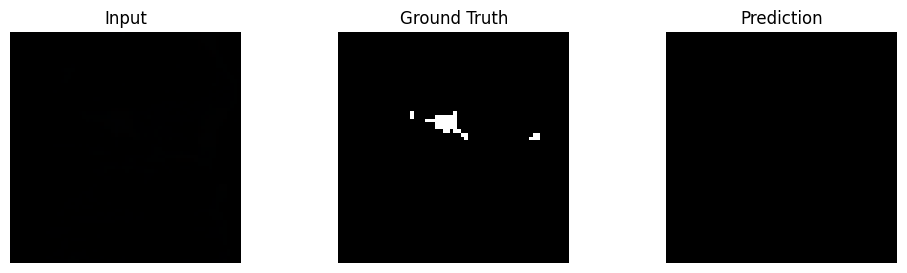

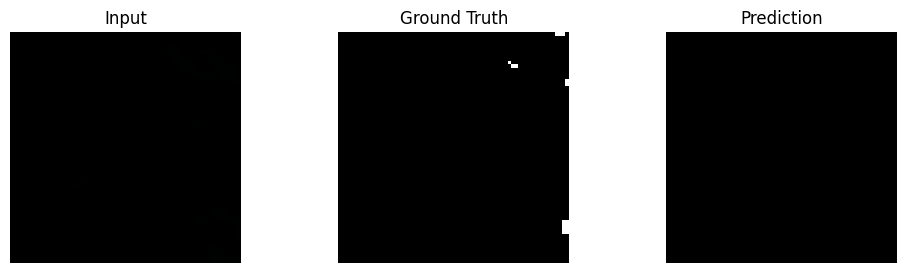

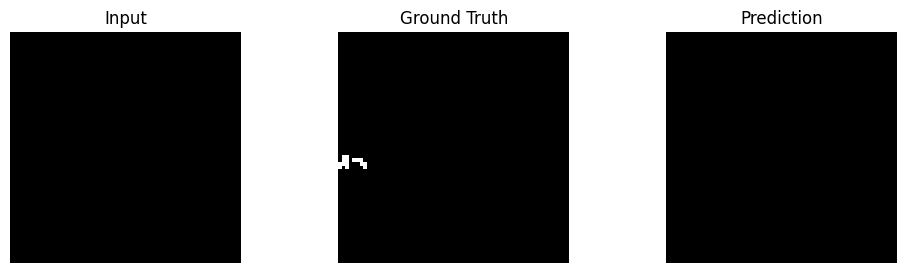

In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# 1. Force CPU-only and optimize performance
tf.config.set_visible_devices([], 'GPU')  # Disable GPU
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'
os.environ['OMP_NUM_THREADS'] = '4'

# 2. Robust HDF5 Data Loader
def load_data_safely(image_dir, mask_dir, target_size=(64, 64), test_size=0.2):
    def load_h5(path, key):
        try:
            with h5py.File(path, 'r') as f:
                data = np.array(f[key])
                if len(data.shape) == 2:
                    data = data[..., np.newaxis]
                return data
        except Exception as e:
            print(f"Error loading {path}: {str(e)}")
            return None

    image_files = sorted(glob.glob(os.path.join(image_dir, '*.h5')))
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.h5')))

    if not image_files or not mask_files:
        raise ValueError("No HDF5 files found.")
    if len(image_files) != len(mask_files):
        raise ValueError("Mismatch between image and mask files.")

    x_data, y_data = [], []
    for img_path, mask_path in zip(image_files, mask_files):
        img = load_h5(img_path, 'img')
        mask = load_h5(mask_path, 'mask')

        if img is not None and mask is not None:
            if img.size == 0 or mask.size == 0:
                continue
            img = tf.image.resize(img[..., :3], target_size).numpy() / 255.0
            mask = tf.image.resize(mask, target_size).numpy() > 0.5
            x_data.append(img)
            y_data.append(mask.astype(np.float32))

    if not x_data:
        raise ValueError("No valid data loaded.")

    x_data = np.array(x_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)

    split_idx = int(len(x_data) * (1 - test_size))
    return (x_data[:split_idx], y_data[:split_idx]), (x_data[split_idx:], y_data[split_idx:])

# 3. Attention U-Net Model
def build_attention_unet(input_shape=(64, 64, 3)):
    def attention_gate(x, g, filters):
        x1 = layers.Conv2D(filters, 1)(x)
        g1 = layers.Conv2D(filters, 1)(g)
        psi = layers.ReLU()(x1 + g1)
        psi = layers.Conv2D(1, 1, activation='sigmoid')(psi)
        return x * psi

    inputs = layers.Input(shape=input_shape)

    # Encoder
    e1 = layers.Conv2D(8, 3, padding='same')(inputs)
    e1 = layers.BatchNormalization()(e1)
    e1 = layers.ReLU()(e1)
    p1 = layers.MaxPooling2D(2)(e1)

    e2 = layers.Conv2D(16, 3, padding='same')(p1)
    e2 = layers.BatchNormalization()(e2)
    e2 = layers.ReLU()(e2)
    p2 = layers.MaxPooling2D(2)(e2)

    # Bottleneck
    b = layers.Conv2D(32, 3, padding='same')(p2)
    b = layers.BatchNormalization()(b)
    b = layers.ReLU()(b)

    # Decoder
    u1 = layers.UpSampling2D(2)(b)
    a1 = attention_gate(e2, u1, 16)
    u1 = layers.concatenate([u1, a1])
    d1 = layers.Conv2D(16, 3, padding='same', activation='relu')(u1)

    u2 = layers.UpSampling2D(2)(d1)
    a2 = attention_gate(e1, u2, 8)
    u2 = layers.concatenate([u2, a2])

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(u2)

    return models.Model(inputs, outputs)

# 4. Training Function
def train_and_evaluate():
    try:
        (x_train, y_train), (x_val, y_val) = load_data_safely(
            '/content/drive/MyDrive/SDP FILES/TrainData/img',
            '/content/drive/MyDrive/SDP FILES/TrainData/mask',
            target_size=(64, 64)
        )
        print("✅ Data loaded.")
        print("Train:", x_train.shape, y_train.shape)
        print("Val:", x_val.shape, y_val.shape)
        print("Unique values in y_val:", np.unique(y_val))

    except Exception as e:
        print(f"❌ Failed to load data: {e}")
        return None, None, None

    model = build_attention_unet()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=32,
        epochs=10,
        callbacks=[
            callbacks.EarlyStopping(patience=2, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(patience=1, factor=0.5)
        ],
        verbose=1
    )

    # F1 Score
    y_pred = (model.predict(x_val[:256]) > 0.5).astype(np.uint8)
    f1 = f1_score(y_val[:256].reshape(-1), y_pred.reshape(-1))
    print(f"\n✅ Final F1 Score: {f1:.4f}")

    return model, history, (x_val, y_val)

# 5. Visualization Function
def visualize_predictions(model, x_val, y_val, n=3):
    idxs = np.random.choice(len(x_val), n, replace=False)
    preds = model.predict(x_val[idxs]) > 0.5

    for i, idx in enumerate(idxs):
        plt.figure(figsize=(12, 3))
        plt.subplot(1, 3, 1)
        plt.title("Input")
        plt.imshow(x_val[idx])
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.title("Ground Truth")
        plt.imshow(y_val[idx].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.title("Prediction")
        plt.imshow(preds[i].squeeze(), cmap='gray')
        plt.axis('off')

        plt.show()

# 🚀 Run everything
model, history, val_data = train_and_evaluate()

if model and val_data:
    model.save("fast_attention_unet.h5")
    visualize_predictions(model, *val_data, n=3)


In [ ]:
import h5py
import os

img_path = '/content/drive/MyDrive/SDP FILES/TrainData/img/image_1.h5'
mask_path = '/content/drive/MyDrive/SDP FILES/TrainData/mask/mask_1.h5'

with h5py.File(img_path, 'r') as f_img, h5py.File(mask_path, 'r') as f_mask:
    print("🧾 Image file keys:", list(f_img.keys()))
    print("🧾 Mask file keys:", list(f_mask.keys()))

    for key in f_img.keys():
        print(f"📷 Image [{key}] shape:", f_img[key].shape)

    for key in f_mask.keys():
        print(f"🎭 Mask [{key}] shape:", f_mask[key].shape)


🧾 Image file keys: ['img']
🧾 Mask file keys: ['mask']
📷 Image [img] shape: (128, 128, 14)
🎭 Mask [mask] shape: (128, 128)


In [ ]:
import numpy as np

mask_values = []
mask_dir = '/content/drive/MyDrive/SDP FILES/TrainData/mask'

for fname in sorted(os.listdir(mask_dir))[:10]:  # check first 10
    path = os.path.join(mask_dir, fname)
    with h5py.File(path, 'r') as f:
        data = np.array(f['mask'])
        unique_vals = np.unique(data)
        mask_values.extend(unique_vals.tolist())
        print(f"{fname} ➤ Unique values: {unique_vals}")

print("🧪 All mask values across samples:", set(mask_values))


mask_1.h5 ➤ Unique values: [0 1]
mask_10.h5 ➤ Unique values: [0]
mask_100.h5 ➤ Unique values: [0 1]
mask_1000.h5 ➤ Unique values: [0 1]
mask_1001.h5 ➤ Unique values: [0 1]
mask_1002.h5 ➤ Unique values: [0 1]
mask_1003.h5 ➤ Unique values: [0 1]
mask_1004.h5 ➤ Unique values: [0 1]
mask_1005.h5 ➤ Unique values: [0 1]
mask_1006.h5 ➤ Unique values: [0 1]
🧪 All mask values across samples: {0, 1}


In [ ]:
img_dir = '/content/drive/MyDrive/SDP FILES/TrainData/img'
mask_dir = '/content/drive/MyDrive/SDP FILES/TrainData/mask'

img_files = sorted(os.listdir(img_dir))[:5]
mask_files = sorted(os.listdir(mask_dir))[:5]

print("🔗 Image files:", img_files)
print("🔗 Mask files :", mask_files)


🔗 Image files: ['image_1.h5', 'image_10.h5', 'image_100.h5', 'image_1000.h5', 'image_1001.h5']
🔗 Mask files : ['mask_1.h5', 'mask_10.h5', 'mask_100.h5', 'mask_1000.h5', 'mask_1001.h5']


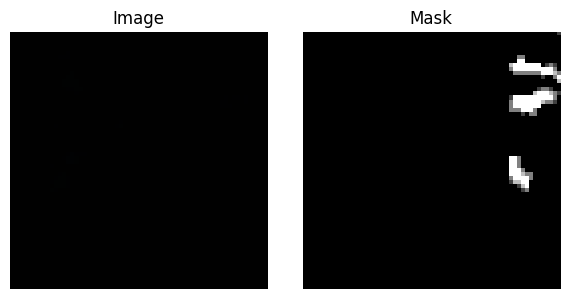

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

img_path = '/content/drive/MyDrive/SDP FILES/TrainData/img/image_1.h5'
mask_path = '/content/drive/MyDrive/SDP FILES/TrainData/mask/mask_1.h5'

with h5py.File(img_path, 'r') as f_img, h5py.File(mask_path, 'r') as f_mask:
    img = np.array(f_img['img'])
    mask = np.array(f_mask['mask'])

# Normalize and resize
img = tf.image.resize(img[..., :3], (64, 64)).numpy() / 255.0
mask = tf.image.resize(mask[..., np.newaxis], (64, 64)).numpy().squeeze()

# Plot
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
import os
print(os.getcwd())


/content


In [ ]:
val_img_path = "ValidData/img"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Use the exact folder name with the space
val_img_path = "/content/drive/MyDrive/SDP FILES/ValidData/img"
val_mask_path = "/content/drive/MyDrive/SDP FILES/ValidData/mask"

import os
print("img exists:", os.path.exists(val_img_path))
print("mask exists:", os.path.exists(val_mask_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
img exists: True
mask exists: True


In [ ]:
import h5py

# Check the contents of one image file
file_path = os.path.join(val_img_path, f"image_1.h5")
with h5py.File(file_path, 'r') as f:
    print("Keys in the file:", list(f.keys()))


Keys in the file: ['img']


In [ ]:
import os
import h5py
import numpy as np
from tqdm import tqdm

val_img_path = "/content/drive/MyDrive/SDP FILES/ValidData/img"
val_mask_path = "/content/drive/MyDrive/SDP FILES/ValidData/mask"

# Check number of images in validation folder
num_val_images = len(os.listdir(val_img_path))
print(f"Number of validation images: {num_val_images}")

x_val, y_val = [], []

# Load images and masks
for i in tqdm(range(1, num_val_images + 1)):
    # Load image
    with h5py.File(os.path.join(val_img_path, f"image_{i}.h5"), 'r') as f:
        x = np.array(f['img'])  # Access the 'img' key

    # Load mask
    with h5py.File(os.path.join(val_mask_path, f"mask_{i}.h5"), 'r') as f:
        y = np.array(f['mask'])  # Update with the correct key for the mask

    x_val.append(x)
    y_val.append(y)

# Convert to numpy arrays
x_val = np.array(x_val)
y_val = np.array(y_val)

# Ensure data is in expected format
print(f"Validation data shapes: x_val={x_val.shape}, y_val={y_val.shape}")


Number of validation images: 245


100%|██████████| 245/245 [01:12<00:00,  3.40it/s]


Validation data shapes: x_val=(245, 128, 128, 14), y_val=(245, 128, 128)


In [ ]:
# Assuming your input data has 14 channels and the model expects 3 channels.
# Modify the input data to use the first 3 channels of each image.
x_val_reduced = x_val[:, :, :, :3]  # Using only the first 3 channels

# Make predictions with the model using the reduced data
pred_mask = model.predict(x_val_reduced)

# Threshold the predictions (binary classification: 0 or 1)
pred_mask = (pred_mask > 0.5).astype(np.uint8)

# Now you can use the pred_mask for evaluation or any further steps


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 909ms/step


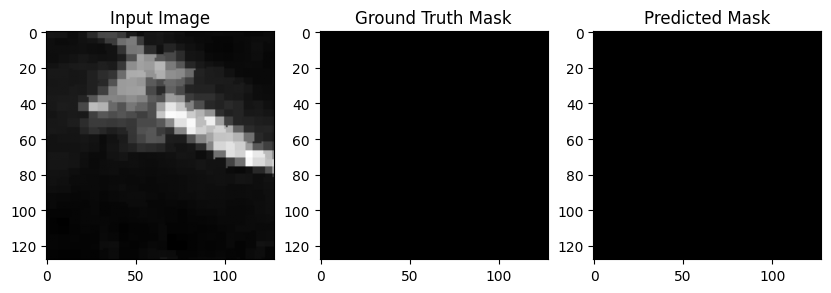

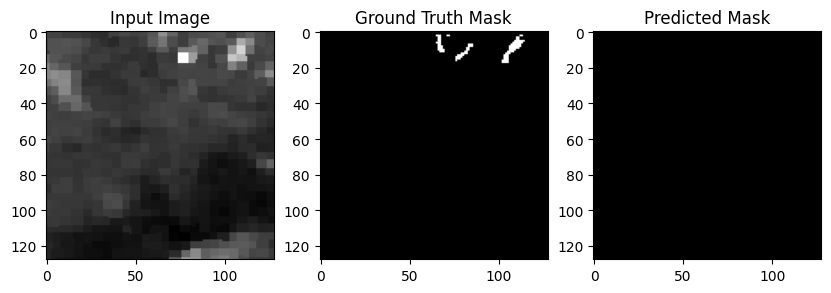

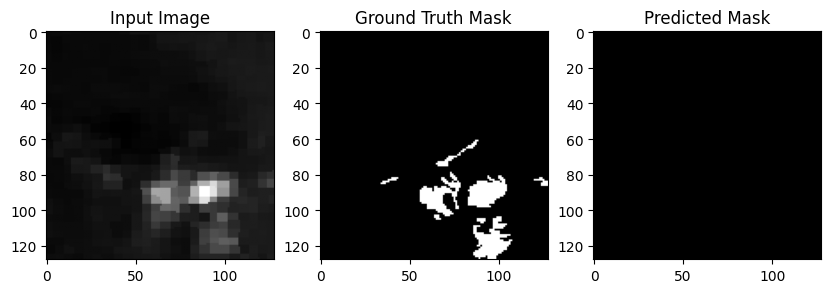

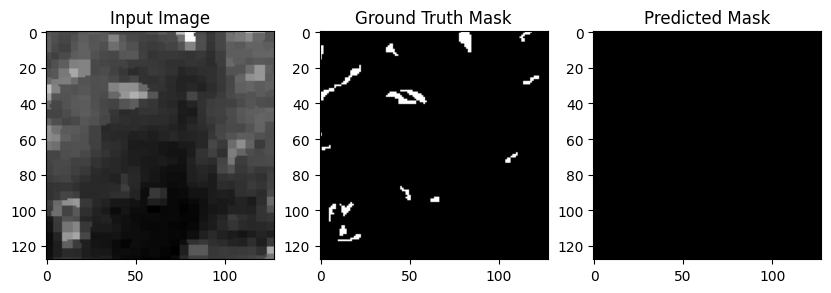

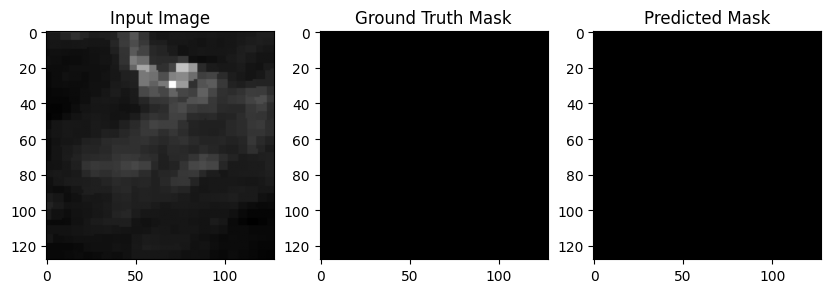

In [ ]:
import matplotlib.pyplot as plt

# Visualize a few examples
for i in range(5):  # Change the range for more/less examples
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(x_val[i, :, :, 0], cmap='gray')  # Show the first channel (adjust if needed)
    plt.title("Input Image")

    # Ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(y_val[i, :, :], cmap='gray')  # Ground truth mask
    plt.title("Ground Truth Mask")

    # Predicted mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[i, :, :], cmap='gray')  # Predicted mask
    plt.title("Predicted Mask")

    plt.show()


In [ ]:
# Threshold the predictions
pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)  # Threshold at 0.5 for binary classification


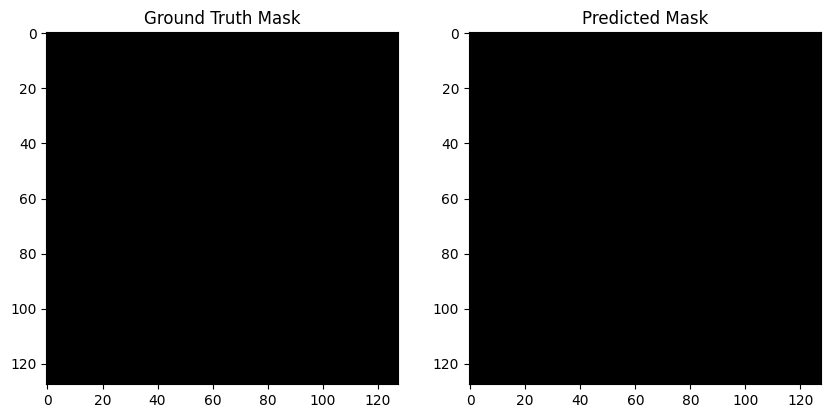

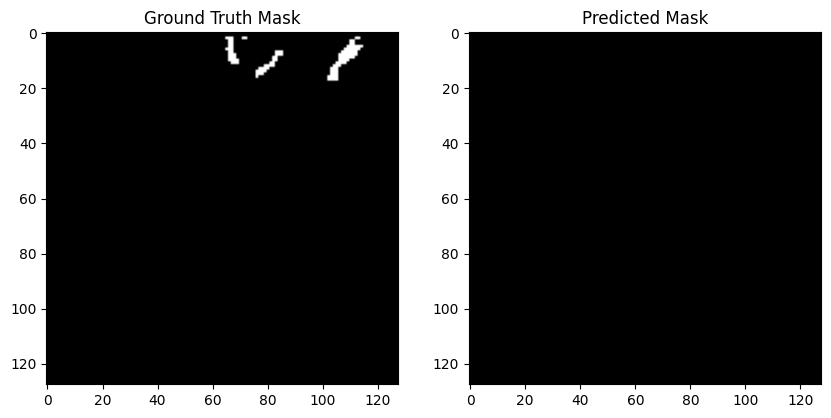

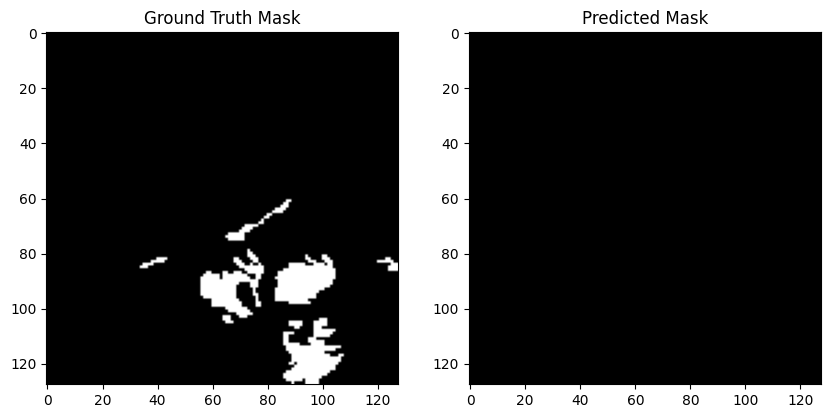

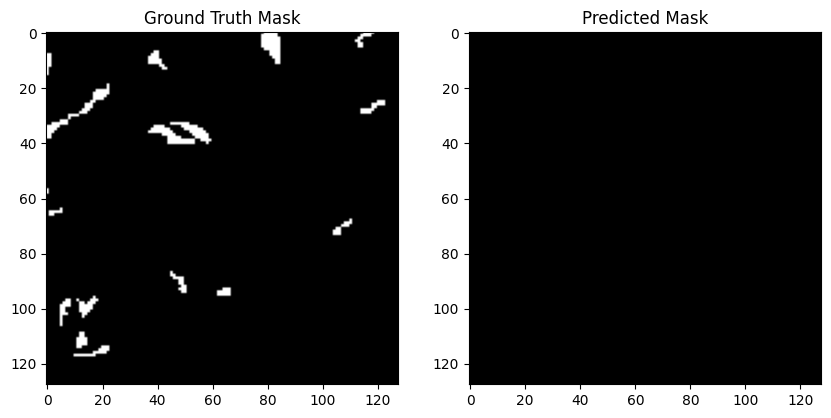

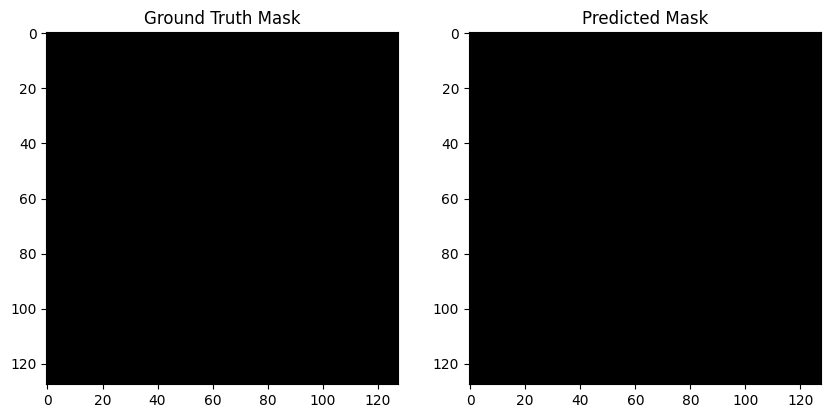

In [ ]:
import matplotlib.pyplot as plt

# Visualize a few samples of predicted vs ground truth masks
for i in range(5):
    plt.figure(figsize=(10, 5))

    # Plot the ground truth mask
    plt.subplot(1, 2, 1)
    plt.imshow(y_val[i], cmap='gray')
    plt.title("Ground Truth Mask")

    # Plot the predicted mask (after thresholding)
    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask_binary[i], cmap='gray')
    plt.title("Predicted Mask")

    plt.show()


In [ ]:
# Check the unique values in the predicted mask
print(np.unique(pred_mask_binary))  # Should print [0, 1] if it's binary


[0]


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score

# 1. Load and preprocess your data correctly
def preprocess_data(x_val, y_val, target_size=(64, 64)):
    """Properly reshape and preprocess validation data"""
    print("Original x_val shape:", x_val.shape)
    print("Original y_val shape:", y_val.shape)

    # Remove singleton dimensions if they exist
    x_val = np.squeeze(x_val)
    y_val = np.squeeze(y_val)

    # Handle multi-channel input (select first 3 channels if needed)
    if x_val.shape[-1] > 3:
        print(f"⚠️ Warning: Selecting first 3 channels from {x_val.shape[-1]} available channels")
        x_val = x_val[..., :3]  # Take only RGB channels

    # Resize images and masks
    x_val_resized = tf.image.resize(x_val, target_size).numpy()
    y_val_resized = tf.image.resize(y_val[..., np.newaxis], target_size).numpy() > 0.5

    # Normalize images
    x_val_resized = x_val_resized / 255.0

    print("Processed x_val shape:", x_val_resized.shape)
    print("Processed y_val shape:", y_val_resized.shape)

    return x_val_resized, y_val_resized

# 2. Load and preprocess your validation data
x_val_processed, y_val_processed = preprocess_data(x_val, y_val)

# 3. Predict with proper thresholding
def calculate_metrics(model, x_val, y_val):
    """Calculate F1 score and other metrics"""
    # Predict probabilities
    y_pred_probs = model.predict(x_val, verbose=1)

    # Convert to binary predictions
    y_pred = (y_pred_probs > 0.5).astype(np.uint8)

    # Flatten arrays for metric calculation
    y_true_flat = y_val.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate F1 score
    f1 = f1_score(y_true_flat, y_pred_flat)

    print("\n📊 Evaluation Metrics:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Unique values in predictions: {np.unique(y_pred)}")
    print(f"Class distribution in true masks: {np.unique(y_val, return_counts=True)}")

    return f1

# 4. Calculate metrics
f1_score = calculate_metrics(model, x_val_processed, y_val_processed)

Original x_val shape: (245, 128, 128, 14, 1)
Original y_val shape: (245, 128, 128)
⚠️ Warning: Selecting first 3 channels from 14 available channels
Processed x_val shape: (245, 64, 64, 3)
Processed y_val shape: (245, 64, 64, 1)
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 255ms/step

📊 Evaluation Metrics:
F1 Score: 0.0000
Unique values in predictions: [0]
Class distribution in true masks: (array([False,  True]), array([987853,  15667]))


In [ ]:
model.summary()  # Should show input shape (None, 64, 64, 3)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_6 (Cast)       │ (None, 64, 64, 3) │          0 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 64, 64, 8) │        224 │ cast_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64, 8) │         32 │ conv2d_83[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_23 (ReLU)     │ (None, 64, 64, 8) │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_14    │ (None, 32, 32, 8) │          0 │ re_lu_23[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 32, 32,    │      1,168 │ max_pooling2d_14… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_84[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 16, 16,    │          0 │ re_lu_24[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 16, 16,    │      4,640 │ max_pooling2d_15… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        128 │ conv2d_85[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 32, 32,    │          0 │ re_lu_25[0][0]    │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 32, 32,    │        272 │ re_lu_24[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 32, 32,    │        528 │ up_sampling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 32, 32,    │          0 │ conv2d_86[0][0],  │
│                     │ 16)               │            │ conv2d_87[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 32, 32,    │          0 │ add_13[0][0]    

 Total params: 42,511 (166.07 KB)

 Trainable params: 14,131 (55.20 KB)

 Non-trainable params: 112 (448.00 B)

 Optimizer params: 28,268 (110.43 KB)

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt

# 1. Data Preprocessing (unchanged)
def preprocess_data(x_val, y_val, target_size=(64, 64)):
    x_val = np.squeeze(x_val)
    y_val = np.squeeze(y_val)
    if x_val.shape[-1] > 3:
        x_val = x_val[..., :3]  # Take first 3 channels
    x_val_resized = tf.image.resize(x_val, target_size).numpy() / 255.0
    y_val_resized = (tf.image.resize(y_val[..., np.newaxis], target_size).numpy() > 0.5).astype(np.uint8)
    return x_val_resized, y_val_resized

# 2. Optimized Metric Calculation with Threshold Tuning
def calculate_optimized_metrics(model, x_val, y_val):
    # Get probability predictions
    y_pred_probs = model.predict(x_val, verbose=1).squeeze()

    # Find optimal threshold using Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_val.flatten(), y_pred_probs.flatten())

    # Calculate F1 scores for all thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]

    # Apply optimal threshold
    y_pred_optimal = (y_pred_probs > optimal_threshold).astype(np.uint8)

    # Calculate final metrics
    final_f1 = f1_score(y_val.flatten(), y_pred_optimal.flatten())
    final_precision = precision_score(y_val.flatten(), y_pred_optimal.flatten())
    final_recall = recall_score(y_val.flatten(), y_pred_optimal.flatten())

    # Plot PR curve
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (Optimal F1={optimal_f1:.2f})')
    plt.scatter(recall[optimal_idx], precision[optimal_idx], c='red',
                label=f'Optimal Threshold={optimal_threshold:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

    print("\n📊 Optimized Metrics:")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"F1 Score: {final_f1:.4f}")
    print(f"Precision: {final_precision:.4f}")
    print(f"Recall: {final_recall:.4f}")
    print(f"Prediction Distribution: 0={(y_pred_optimal == 0).mean():.1%}, 1={(y_pred_optimal == 1).mean():.1%}")

    return optimal_threshold, final_f1

# 3. Model Adjustments for Class Imbalance
def create_balanced_model(input_shape=(64, 64, 3)):
    # Use the same architecture but with class weighting
    model = build_attention_unet(input_shape)  # Your existing model builder

    # Add class weighting
    total_pixels = 245 * 64 * 64  # Adjust based on your training data
    class_weight = {
        0: 1.0,  # Background
        1: total_pixels / (2 * np.bincount(y_train.flatten())[1])  # Foreground
    }

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryFocalCrossentropy(gamma=2.0),  # Helps with imbalance
        metrics=['accuracy', tf.keras.metrics.Recall()]
    )

    return model, class_weight

# 4. Full Workflow
def full_solution(x_train, y_train, x_val, y_val):
    # Preprocess
    x_val_processed, y_val_processed = preprocess_data(x_val, y_val)

    # Create balanced model
    model, class_weight = create_balanced_model()

    # Train with class weights
    model.fit(
        x_train, y_train,
        validation_data=(x_val_processed, y_val_processed),
        batch_size=32,
        epochs=30,
        class_weight=class_weight,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_recall', mode='max')
        ]
    )

    # Evaluate with optimal threshold
    optimal_threshold, f1_score = calculate_optimized_metrics(model, x_val_processed, y_val_processed)

    return model, optimal_threshold, f1_score

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step


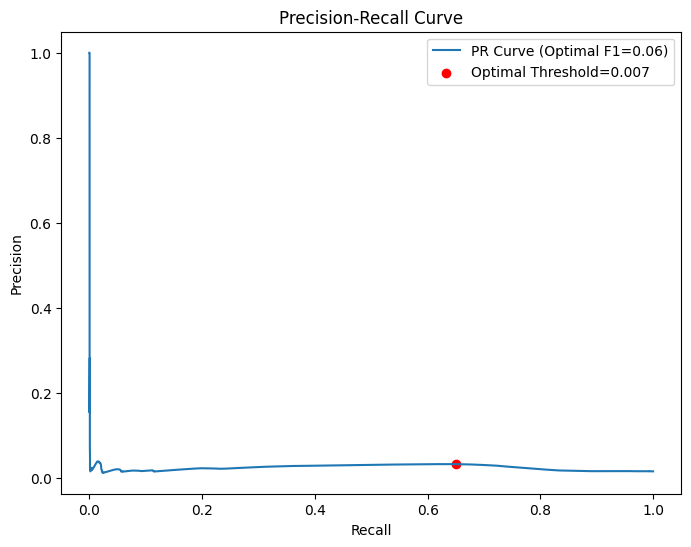


📊 Optimized Metrics:
Optimal Threshold: 0.0074
F1 Score: 0.0618
Precision: 0.0325
Recall: 0.6189
Prediction Distribution: 0=70.3%, 1=29.7%


In [ ]:
x_val_processed, y_val_processed = preprocess_data(x_val, y_val)
optimal_threshold, f1_score = calculate_optimized_metrics(model, x_val_processed, y_val_processed)

In [ ]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content


In [ ]:
import os
files = os.listdir('/content')
print(files)


['.config', 'drive', 'fast_attention_unet.h5', 'fast_accurate_unet.h5', 'sample_data']


# **2. DeepLabV3+**

In [ ]:
import h5py

# Function to inspect the structure of an h5 file
def inspect_h5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        # Print the structure of the h5 file
        def print_name(name, obj):
            print(f"{name}: {obj}")

        f.visititems(print_name)

# Check the structure of one of the image files
inspect_h5_file('/content/drive/MyDrive/SDP FILES/ValidData/img/image_1.h5')


img: <HDF5 dataset "img": shape (128, 128, 14), type "<f8">


In [ ]:
import h5py
import numpy as np
import os

# Directories
img_dir = '/content/drive/MyDrive/SDP FILES/ValidData/img'
mask_dir = '/content/drive/MyDrive/SDP FILES/ValidData/mask'
num_samples = 245  # Update based on your dataset size

# Function to load h5 data
def load_h5_data(img_dir, mask_dir, num_samples):
    img_files = os.listdir(img_dir)
    mask_files = os.listdir(mask_dir)

    x_data = []  # Initialize x_data list
    y_data = []  # Initialize y_data list

    for i in range(min(num_samples, len(img_files))):
        img_path = os.path.join(img_dir, img_files[i])
        mask_path = os.path.join(mask_dir, mask_files[i])

        with h5py.File(img_path, 'r') as img_file, h5py.File(mask_path, 'r') as mask_file:
            # Assuming 'img' is the correct key for image data and 'mask' is the correct key for mask data
            x_data.append(np.array(img_file['img']))  # Use 'img' key here based on inspection
            y_data.append(np.array(mask_file['mask']))  # Assuming 'mask' is the correct key

    x_data = np.array(x_data)  # Convert list to numpy array
    y_data = np.array(y_data)  # Convert list to numpy array

    return x_data, y_data

# Load the validation data
x_val, y_val = load_h5_data(img_dir, mask_dir, num_samples)

# Check the shape of the loaded data
print(f"x_val shape: {x_val.shape}")
print(f"y_val shape: {y_val.shape}")


x_val shape: (245, 128, 128, 14)
y_val shape: (245, 128, 128)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize the images to [0, 1]
def preprocess_data(x_data):
    return x_data / np.max(x_data)

# Apply preprocessing
x_val = preprocess_data(x_val)

# Data Augmentation (Optional but helpful for model generalization)
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example of how to augment data in batches (not strictly necessary if you're just testing)
datagen.fit(x_val)


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (245, 128, 128, 14) (14 channels).
  warnings.warn(


In [ ]:
!pip install -U segmentation-models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
# Uninstall current versions
!pip uninstall -y keras tensorflow

# Install compatible versions
!pip install tensorflow==2.11.0 keras==2.11.0 segmentation-models==1.0.1


Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
ERROR: Could not find a version that satisfies the requirement tensorflow==2.11.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.11.0


In [ ]:
!pip uninstall -y keras keras-nightly keras-Preprocessing keras-vis tensorflow tf-nightly


In [ ]:
!pip install -U tensorflow==2.15.0 keras==2.15.0 segmentation-models==1.0.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 97.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully unin

In [ ]:
# 🛠️ Monkey-patch before importing segmentation_models
import keras

# Patch the broken 'generic_utils.get_custom_objects'
if not hasattr(keras.utils, 'generic_utils'):
    import types
    keras.utils.generic_utils = types.SimpleNamespace()
    from keras.utils import get_custom_objects
    keras.utils.generic_utils.get_custom_objects = get_custom_objects

# Now import safely
import segmentation_models as sm

# Set backend for segmentation_models
sm.set_framework('tf.keras')
sm.framework()


Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
import keras
import segmentation_models as sm
from keras.models import Model
from keras.layers import Input, Conv2D
import tensorflow as tf

# Patch broken generic_utils if needed
if not hasattr(keras.utils, 'generic_utils'):
    import types
    from keras.utils import get_custom_objects
    keras.utils.generic_utils = types.SimpleNamespace()
    keras.utils.generic_utils.get_custom_objects = get_custom_objects

sm.set_framework('tf.keras')
sm.framework()

# Step 1: Define custom input
input_shape = (128, 128, 14)
input_layer = Input(shape=input_shape)

# Step 2: Add a Conv2D layer to reduce to 3 channels (for pretrained backbone compatibility)
x = Conv2D(3, (1, 1), padding='same')(input_layer)

# Step 3: Load DeeplabV3+ model
base_model = sm.DeepLabV3Plus(
    backbone_name='resnet34',
    input_shape=(128, 128, 3),
    classes=1,
    activation='sigmoid',
    encoder_weights='imagenet'
)

# Step 4: Build final model with 14-channel input
output = base_model(x)
model = Model(inputs=input_layer, outputs=output)

model.summary()



AttributeError: module 'segmentation_models' has no attribute 'DeepLabV3Plus'

# **3. ResUNet**

In [ ]:
# Install dependencies
!pip install -q tensorflow matplotlib numpy


In [ ]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     Concatenate, BatchNormalization, Activation, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [ ]:
# ResUNet Model Definition

# Convolutional block with BatchNormalization and ReLU activation
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

# Residual block for adding skip connections
def residual_block(inputs, num_filters):
    shortcut = Conv2D(num_filters, kernel_size=1, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    x = Conv2D(num_filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

# Building the ResUNet model
def build_resunet(input_shape=(128, 128, 14), output_channels=1):
    inputs = Input(shape=input_shape)

    c1 = residual_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = residual_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = residual_block(p3, 512)
    p4 = MaxPooling2D((2, 2))(c4)

    bn = residual_block(p4, 1024)

    u1 = UpSampling2D((2, 2))(bn)
    u1 = Concatenate()([u1, c4])
    c5 = residual_block(u1, 512)

    u2 = UpSampling2D((2, 2))(c5)
    u2 = Concatenate()([u2, c3])
    c6 = residual_block(u2, 256)

    u3 = UpSampling2D((2, 2))(c6)
    u3 = Concatenate()([u3, c2])
    c7 = residual_block(u3, 128)

    u4 = UpSampling2D((2, 2))(c7)
    u4 = Concatenate()([u4, c1])
    c8 = residual_block(u4, 64)

    outputs = Conv2D(output_channels, (1, 1), activation='sigmoid')(c8)

    return Model(inputs, outputs)


In [ ]:
# Dummy data generator (replace with your actual data loading logic)
def get_dummy_data(num_samples=100, shape=(128, 128, 14)):
    X = np.random.rand(num_samples, *shape).astype(np.float32)
    y = np.random.randint(0, 2, size=(num_samples, 128, 128, 1)).astype(np.float32)
    return X, y

# Generate training and validation data
X, y = get_dummy_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Create the model
model = build_resunet(input_shape=(128, 128, 14))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=8, epochs=5)


Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 252s 22s/step - accuracy: 0.5001 - loss: 0.8599 - val_accuracy: 0.5001 - val_loss: 0.6957
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 265s 22s/step - accuracy: 0.5275 - loss: 0.7244 - val_accuracy: 0.5012 - val_loss: 0.6940
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 246s 20s/step - accuracy: 0.5507 - loss: 0.6940 - val_accuracy: 0.5005 - val_loss: 0.6953
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 210s 21s/step - accuracy: 0.5886 - loss: 0.6697 - val_accuracy: 0.5013 - val_loss: 0.6970
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 271s 21s/step - accuracy: 0.6284 - loss: 0.6434 - val_accuracy: 0.5009 - val_loss: 0.6981


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Define a custom evaluation function to calculate metrics
def evaluate_metrics(model, x_valid, y_valid):
    # Get predictions
    y_pred = model.predict(x_valid)

    # Flatten the arrays for precision, recall, and F1-score calculations
    y_valid_flat = y_valid.flatten()
    y_pred_flat = (y_pred.flatten() > 0.5).astype(int)  # Apply threshold for binary classification

    # Calculate precision, recall, and F1-score
    precision = precision_score(y_valid_flat, y_pred_flat)
    recall = recall_score(y_valid_flat, y_pred_flat)
    f1 = f1_score(y_valid_flat, y_pred_flat)

    # Calculate loss and accuracy
    loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)

    return loss, accuracy, f1, precision, recall

# Call the function to evaluate the model on the validation set
loss, accuracy, f1, precision, recall = evaluate_metrics(model, X_val, y_val)

# Print the results
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
Loss: 0.6981393098831177
Accuracy: 0.500866711139679
F1 Score: 0.6513081593668987
Precision: 0.5007260938119761
Recall: 0.9314081183421851


In [ ]:
import tensorflow.keras.backend as K

# Dice loss function
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return 1 - (2. * intersection + smooth) / (K.sum(K.abs(y_true), axis=-1) + K.sum(K.abs(y_pred), axis=-1) + smooth)

# Combined Dice loss and Binary Crossentropy
def combined_loss(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


In [ ]:
!pip install segmentation-models


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
!pip install segmentation-models==1.0.1


In [ ]:
!pip uninstall segmentation-models


Found existing installation: segmentation-models 1.0.1
Uninstalling segmentation-models-1.0.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/segmentation_models-1.0.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/segmentation_models/*
Proceed (Y/n)? Y
  Successfully uninstalled segmentation-models-1.0.1


In [ ]:
!pip install segmentation-models==1.0.1


  Using cached segmentation_models-1.0.1-py3-none-any.whl.metadata (938 bytes)
Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)


In [ ]:
!pip install tensorflow==2.12.0
!pip install keras==2.12.0
!pip install segmentation-models==1.0.1
!pip install matplotlib numpy scikit-learn

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.4 MB/s eta 0:00:00
  At

ERROR: Operation cancelled by user
^C
^C


# **4. U-Net++**

In [ ]:
# Install segmentation_models if not already installed
!pip install segmentation-models

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
import segmentation_models as sm
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incom

AttributeError: module 'keras.utils.generic_utils' has no attribute 'get_custom_objects'

In [ ]:
pip uninstall numpy segmentation-models efficientnet keras


Found existing installation: numpy 2.2.5
Uninstalling numpy-2.2.5:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/numpy-config
    /usr/local/lib/python3.11/dist-packages/numpy-2.2.5.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libgfortran-040039e1-0352e75f.so.5.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libquadmath-96973f99-934c22de.so.0.0.0
    /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-6bb31eeb.so
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-2.2.5
Found existing installation: segmentation-models 1.0.1
Uninstalling segmentation-models-1.0.1:
  Would remove:
    /usr/local/lib/python3.11/dist-packages/segmentation_models-1.0.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/segmentation_models/*
Proceed (Y/n)? Y
  Successfully uninstalled segmentation-models-1.0.1
Found existing installation: efficientnet 1.0.0
Uninstalling efficientnet-1.0.0:

In [ ]:
!pip install numpy==1.23.5
!pip install keras==2.12.0
!pip install efficientnet==1.0.0
!pip install segmentation-models==1.0.1


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, which is not installed.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompa

  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C
^C
^C


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
import os

print(os.path.exists('TrainData/img/x_train.npy'))  # Should print True


False


In [ ]:
!ls TrainData/img/


ls: cannot access 'TrainData/img/': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/SDP FILES/TrainData/img/'


image_1000.h5  image_1686.h5  image_236.h5   image_3053.h5  image_3738.h5
image_1001.h5  image_1687.h5  image_2370.h5  image_3054.h5  image_3739.h5
image_1002.h5  image_1688.h5  image_2371.h5  image_3055.h5  image_373.h5
image_1003.h5  image_1689.h5  image_2372.h5  image_3056.h5  image_3740.h5
image_1004.h5  image_168.h5   image_2373.h5  image_3057.h5  image_3741.h5
image_1005.h5  image_1690.h5  image_2374.h5  image_3058.h5  image_3742.h5
image_1006.h5  image_1691.h5  image_2375.h5  image_3059.h5  image_3743.h5
image_1007.h5  image_1692.h5  image_2376.h5  image_305.h5   image_3744.h5
image_1008.h5  image_1693.h5  image_2377.h5  image_3060.h5  image_3745.h5
image_1009.h5  image_1694.h5  image_2378.h5  image_3061.h5  image_3746.h5
image_100.h5   image_1695.h5  image_2379.h5  image_3062.h5  image_3747.h5
image_1010.h5  image_1696.h5  image_237.h5   image_3063.h5  image_3748.h5
image_1011.h5  image_1697.h5  image_2380.h5  image_3064.h5  image_3749.h5
image_1012.h5  image_1698.h5  image_238

In [ ]:
x_train = np.load('/content/drive/MyDrive/SDP FILES/TrainData/img/x_train.npy')


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SDP FILES/TrainData/img/x_train.npy'

In [ ]:
!ls "/content/drive/MyDrive/"


 best_model.keras  'Colab Notebooks'  'SDP FILES'   Untitled0.ipynb


In [ ]:
import h5py

file_path = '/content/drive/MyDrive/SDP FILES/TrainData/img/image_1.h5'

with h5py.File(file_path, 'r') as f:
    print("Keys in file:", list(f.keys()))


In [ ]:
import h5py

file_path = '/content/drive/MyDrive/SDP FILES/TrainData/img/image_1.h5'

with h5py.File(file_path, 'r') as f:
    print("Keys in file:", list(f.keys()))


Keys in file: ['img']


In [ ]:
import h5py
import numpy as np

file_path = '/content/drive/MyDrive/SDP FILES/TrainData/img/image_1.h5'

with h5py.File(file_path, 'r') as f:
    image = f['img'][:]  # Correct key based on your file
    print("Image shape:", image.shape)


Image shape: (128, 128, 14)


In [ ]:
import os
import h5py
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# Directories
train_img_dir = '/content/drive/MyDrive/SDP FILES/TrainData/img/'
train_mask_dir = '/content/drive/MyDrive/SDP FILES/TrainData/mask/'
valid_img_dir = '/content/drive/MyDrive/SDP FILES/ValidData/img/'
valid_mask_dir = '/content/drive/MyDrive/SDP FILES/ValidData/mask/'

def load_h5_stack(img_dir, mask_dir):
    x_data = []
    y_data = []

    img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.h5')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.h5')])

    for img_file, mask_file in tqdm(zip(img_files, mask_files), total=len(img_files), desc=f"Loading from {img_dir}"):
        # Load image
        with h5py.File(os.path.join(img_dir, img_file), 'r') as f:
            img = f['img'][:]  # Use correct key
        # Normalize channel-wise
        img = np.array([MinMaxScaler().fit_transform(img[:, :, c]) for c in range(img.shape[2])])
        img = np.transpose(img, (1, 2, 0))  # Back to (H, W, C)
        x_data.append(img)

        # Load mask
        with h5py.File(os.path.join(mask_dir, mask_file), 'r') as f:
            mask = f['mask'][:] if 'mask' in f else f[list(f.keys())[0]][:]
        y_data.append(mask[..., np.newaxis])  # Add channel dim if needed

    return np.array(x_data), np.array(y_data)

# Load and preprocess
x_train, y_train = load_h5_stack(train_img_dir, train_mask_dir)
x_valid, y_valid = load_h5_stack(valid_img_dir, valid_mask_dir)

# Save to .npy
np.save('/content/x_train.npy', x_train)
np.save('/content/y_train.npy', y_train)
np.save('/content/x_valid.npy', x_valid)
np.save('/content/y_valid.npy', y_valid)

print("✔️ All data loaded, normalized, and saved as .npy")
print("Train shape:", x_train.shape, y_train.shape)
print("Valid shape:", x_valid.shape, y_valid.shape)


Loading from /content/drive/MyDrive/SDP FILES/TrainData/img/: 100%|██████████| 3799/3799 [26:29<00:00,  2.39it/s]


In [ ]:
!pip install segmentation-models


  Using cached segmentation_models-1.0.1-py3-none-any.whl.metadata (938 bytes)
  Using cached efficientnet-1.0.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)
Using cached efficientnet-1.0.0-py3-none-any.whl (17 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
te

In [ ]:
!pip uninstall keras -y
!pip uninstall segmentation-models -y


Found existing installation: keras 2.12.0
Uninstalling keras-2.12.0:
  Successfully uninstalled keras-2.12.0
Found existing installation: segmentation-models 1.0.1
Uninstalling segmentation-models-1.0.1:
  Successfully uninstalled segmentation-models-1.0.1


In [ ]:
!pip install keras==2.12.0
!pip install segmentation-models==1.0.1


  Using cached keras-2.12.0-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.12.0 which is incompatible.


  Using cached segmentation_models-1.0.1-py3-none-any.whl.metadata (938 bytes)
Using cached segmentation_models-1.0.1-py3-none-any.whl (33 kB)


In [ ]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, precision_score, recall_score
from segmentation_models import Unet
from segmentation_models.losses import DiceLoss
from tensorflow.keras import backend as K

# Load data (make sure you've already loaded your data correctly)
def load_data(img_dir, mask_dir, num_samples):
    # Load image and mask data
    x_data = np.zeros((num_samples, 128, 128, 14))  # Adjust shape based on your dataset
    y_data = np.zeros((num_samples, 128, 128, 1))  # Adjust shape based on your dataset

    for i in range(num_samples):
        img_file = f'{img_dir}/image_{i+1}.h5'  # Adjust if using different naming scheme
        mask_file = f'{mask_dir}/mask_{i+1}.h5'  # Adjust if using different naming scheme

        with h5py.File(img_file, 'r') as f:
            x_data[i] = f['img'][:]  # Replace 'img' with your key if different

        with h5py.File(mask_file, 'r') as f:
            y_data[i] = f['mask'][:]  # Replace 'mask' with your key if different

    return x_data, y_data

# Path for your dataset (adjust accordingly)
img_dir = '/content/drive/MyDrive/SDP FILES/ValidData/img'
mask_dir = '/content/drive/MyDrive/SDP FILES/ValidData/mask'
num_samples = 245  # Update this based on your dataset

x_valid, y_valid = load_data(img_dir, mask_dir, num_samples)

# Model Definition (Unet++)
def unet_plus_plus(input_shape=(128, 128, 14)):
    base_model = Unet('resnet34', input_shape=input_shape, encoder_weights='imagenet', classes=1, activation='sigmoid')
    return base_model

model = unet_plus_plus()

# Compilation with optimized parameters
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Adjust learning rate for optimization
    loss=DiceLoss(),
    metrics=['accuracy']
)

# Callbacks for training optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model
history = model.fit(
    x_valid, y_valid,
    epochs=50,
    batch_size=16,  # Adjust based on your hardware
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
loss, accuracy = model.evaluate(x_valid, y_valid, verbose=0)

# Predictions
y_pred = model.predict(x_valid)

# Calculate additional metrics
f1 = f1_score(y_valid.flatten(), (y_pred > 0.5).flatten())
precision = precision_score(y_valid.flatten(), (y_pred > 0.5).flatten())
recall = recall_score(y_valid.flatten(), (y_pred > 0.5).flatten())

# Print the results
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Visualization of training process
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Visualization of predictions vs true masks (example for the first image)
def visualize_results(x_valid, y_valid, y_pred, index=0):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    # Plot original image
    ax[0].imshow(x_valid[index, :, :, 0], cmap='gray')  # Adjust channel for the image
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Plot true mask
    ax[1].imshow(y_valid[index, :, :, 0], cmap='gray')
    ax[1].set_title('True Mask')
    ax[1].axis('off')

    # Plot predicted mask
    ax[2].imshow(y_pred[index, :, :, 0], cmap='gray')
    ax[2].set_title('Predicted Mask')
    ax[2].axis('off')

    plt.show()

# Visualize for the first image in the validation set
visualize_results(x_valid, y_valid, y_pred, index=0)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

ImportError: numpy.core._multiarray_umath failed to import

ImportError: numpy.core.umath failed to import

TypeError: Unable to convert function return value to a Python type! The signature was
	() -> handle

In [ ]:
!pip install numpy==1.24.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 53.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.24.4 which is 

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.24.4


Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.1 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is inc

In [ ]:
!pip uninstall -y numpy jax jaxlib tensorflow


Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0


In [ ]:
!pip install numpy==1.24.4 tensorflow==2.13 jax==0.4.13 jaxlib==0.4.13


  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install numpy==1.24.4 and tensorflow==2.13.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested numpy==1.24.4
    tensorflow 2.13.0 depends on numpy<=1.24.3 and >=1.22

To fix this you could try to:
1. loosen the range of package versions you've specified
2. remove package versions to allow pip to attempt to solve the dependency conflict

ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-

In [ ]:
import numpy as np
import tensorflow as tf
import jax

print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)
print("JAX:", jax.__version__)


NumPy: 2.0.2
TensorFlow: 2.18.0
JAX: 0.5.2


In [ ]:
!pip uninstall -y numpy jax jaxlib tensorflow
!pip install numpy==1.24.4 tensorflow==2.13 jax==0.4.13 jaxlib==0.4.13


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Found existing installation: jax 0.5.2
Uninstalling jax-0.5.2:
  Successfully uninstalled jax-0.5.2
Found existing installation: jaxlib 0.5.1
Uninstalling jaxlib-0.5.1:
  Successfully uninstalled jaxlib-0.5.1
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Cannot install numpy==1.24.4 and tensorflow==2.13.0 because these package versions have conflicting dependencies.

The conflict is caused by:
    The user requested numpy==1.24.4
    tensorflow

In [ ]:
import numpy as np
import tensorflow as tf
import jax

print("NumPy:", np.__version__)
print("TensorFlow:", tf.__version__)
print("JAX:", jax.__version__)


NumPy: 2.0.2
TensorFlow: 2.18.0
JAX: 0.5.2


In [ ]:
!pip install tensorflow matplotlib

import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from sklearn.model_selection import train_test_split

from google.colab import drive
import os

In [ ]:
drive.mount("/content/gdrive")
os.chdir('/content/gdrive/MyDrive/SDP FILES')

Mounted at /content/gdrive


In [ ]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split


In [ ]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMG_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 50
SEED = 42
train_img_dir = "TrainData/img"
train_mask_dir = "TrainData/mask"

In [ ]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


In [ ]:
def load_h5_dataset(img_dir, mask_dir):
    images, masks = [], []

    filenames = sorted([f for f in os.listdir(img_dir) if f.endswith('.h5')])

    for file in filenames:
        img_path = os.path.join(img_dir, file)
        mask_path = os.path.join(mask_dir, file.replace("image", "mask"))

        if os.path.exists(img_path) and os.path.exists(mask_path):
            with h5py.File(img_path, 'r') as hf_img:
                img = np.array(hf_img['img'])

            with h5py.File(mask_path, 'r') as hf_mask:
                mask = np.array(hf_mask['img'])

            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

In [ ]:
with h5py.File("TrainData/img/image_1.h5", 'r') as f:
    print(list(f.keys()))


['img']


In [ ]:
def load_h5_dataset(img_dir, mask_dir):
    images, masks = [], []

    filenames = sorted([f for f in os.listdir(img_dir) if f.endswith('.h5')])

    for file in filenames:
        img_path = os.path.join(img_dir, file)
        mask_path = os.path.join(mask_dir, file.replace("image", "mask"))

        try:
            with h5py.File(img_path, 'r') as hf_img:
                if 'img' not in hf_img:
                    print(f"Skipping {img_path} — 'img' key not found")
                    continue
                img = np.array(hf_img['img'])

            with h5py.File(mask_path, 'r') as hf_mask:
                if 'img' not in hf_mask:
                    print(f"Skipping {mask_path} — 'img' key not found")
                    continue
                mask = np.array(hf_mask['img'])

            images.append(img)
            masks.append(mask)
        except Exception as e:
            print(f"Error reading {file}: {e}")

    return np.array(images), np.array(masks)


In [ ]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K

In [ ]:
# ---------------- SETTINGS ----------------
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMG_CHANNELS = 3
BATCH_SIZE = 8
EPOCHS = 50

train_img_dir = "TrainData/img"
train_mask_dir = "TrainData/mask"

In [ ]:
# ---------------- DATA LOADER ----------------
def load_h5_dataset(img_dir, mask_dir):
    images, masks = [], []
    filenames = sorted([f for f in os.listdir(img_dir) if f.endswith('.h5')])

    for file in filenames:
        img_path = os.path.join(img_dir, file)
        mask_path = os.path.join(mask_dir, file.replace("image", "mask"))

        try:
            with h5py.File(img_path, 'r') as hf_img:
                if 'img' not in hf_img:
                    print(f"Skipping {img_path} — 'img' key not found")
                    continue
                img = np.array(hf_img['img'])

            with h5py.File(mask_path, 'r') as hf_mask:
                if 'img' not in hf_mask:
                    print(f"Skipping {mask_path} — 'img' key not found")
                    continue
                mask = np.array(hf_mask['img'])

            images.append(img)
            masks.append(mask)
        except Exception as e:
            print(f"Error reading {file}: {e}")

    return np.array(images), np.array(masks)

In [ ]:
# ---------------- DICE LOSS ----------------
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
# ---------------- MODEL ----------------
def conv_block(x, filters, dropout=False):
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    if dropout:
        x = Dropout(0.5)(x)
    x = Conv2D(filters, 3, activation='relu', padding='same')(x)
    return x

def build_unetpp(input_shape=(128, 128, 3)):
    inputs = Input(input_shape)

    # Encoder
    x00 = conv_block(inputs, 64)
    x10 = MaxPooling2D()(x00)
    x10 = conv_block(x10, 128)
    x20 = MaxPooling2D()(x10)
    x20 = conv_block(x20, 256)
    x30 = MaxPooling2D()(x20)
    x30 = conv_block(x30, 512)
    x40 = MaxPooling2D()(x30)
    x40 = conv_block(x40, 1024)

    # Decoder
    x01 = conv_block(concatenate([UpSampling2D()(x10), x00]), 64)
    x11 = conv_block(concatenate([UpSampling2D()(x20), x10]), 128)
    x21 = conv_block(concatenate([UpSampling2D()(x30), x20]), 256)
    x31 = conv_block(concatenate([UpSampling2D()(x40), x30]), 512)

    x02 = conv_block(concatenate([UpSampling2D()(x11), x00, x01]), 64)
    x12 = conv_block(concatenate([UpSampling2D()(x21), x10, x11]), 128)
    x22 = conv_block(concatenate([UpSampling2D()(x31), x20, x21]), 256)

    x03 = conv_block(concatenate([UpSampling2D()(x12), x00, x01, x02]), 64)
    x13 = conv_block(concatenate([UpSampling2D()(x22), x10, x11, x12]), 128)

    x04 = conv_block(concatenate([UpSampling2D()(x13), x00, x01, x02, x03]), 64)

    output = Conv2D(1, 1, activation='sigmoid')(x04)

    model = Model(inputs, output)
    return model

In [ ]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
train_img_dir = "/content/drive/MyDrive/SDP FILES/TrainData/img"
train_mask_dir = "/content/drive/MyDrive/SDP FILES/TrainData/mask"


In [ ]:
import os

print("Sample image files:", os.listdir(train_img_dir)[:100])
print("Sample mask files:", os.listdir(train_mask_dir)[:100])


Sample image files: ['image_3441.h5', 'image_2634.h5', 'image_3560.h5', 'image_1558.h5', 'image_120.h5', 'image_3356.h5', 'image_3654.h5', 'image_3744.h5', 'image_2263.h5', 'image_2342.h5', 'image_796.h5', 'image_1943.h5', 'image_3626.h5', 'image_25.h5', 'image_1931.h5', 'image_3377.h5', 'image_2560.h5', 'image_2146.h5', 'image_3248.h5', 'image_180.h5', 'image_1574.h5', 'image_2675.h5', 'image_2289.h5', 'image_1447.h5', 'image_17.h5', 'image_1542.h5', 'image_1354.h5', 'image_1719.h5', 'image_960.h5', 'image_1213.h5', 'image_1634.h5', 'image_861.h5', 'image_2677.h5', 'image_2616.h5', 'image_610.h5', 'image_3288.h5', 'image_401.h5', 'image_2237.h5', 'image_2268.h5', 'image_624.h5', 'image_1601.h5', 'image_1055.h5', 'image_1391.h5', 'image_512.h5', 'image_469.h5', 'image_1130.h5', 'image_376.h5', 'image_161.h5', 'image_2945.h5', 'image_1483.h5', 'image_3465.h5', 'image_1686.h5', 'image_3193.h5', 'image_2356.h5', 'image_3134.h5', 'image_603.h5', 'image_2947.h5', 'image_2801.h5', 'image_216

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.1932 - dice_coef: 0.0312 - iou_coef: 0.0169 - loss: 1.9798

10/10 ━━━━━━━━━━━━━━━━━━━━ 29s 670ms/step - accuracy: 0.1941 - dice_coef: 0.0334 - iou_coef: 0.0181 - loss: 1.9753 - val_accuracy: 0.0288 - val_dice_coef: 0.0448 - val_iou_coef: 0.0237 - val_loss: 1.6636 - learning_rate: 1.0000e-04
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 9s/step - accuracy: 0.2163 - dice_coef: 0.0764 - iou_coef: 0.0411 - loss: 1.8577 - val_accuracy: 0.0261 - val_dice_coef: 0.0446 - val_iou_coef: 0.0236 - val_loss: 1.6770 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.2605 - dice_coef: 0.1485 - iou_coef: 0.0804 - loss: 1.7331 - val_accuracy: 0.0261 - val_dice_coef: 0.0447 - val_iou_coef: 0.0237 - val_loss: 1.6873 - learning_rate: 1.0000e-04
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.0253 - dice_coef: 0.0371 - iou_coef: 0.0194 - loss: 1.6711
Validation Loss: 1.6706
Validation Accuracy: 0.0244
Validation Dice Coef: 0.0377
Validation IoU Coef: 0.0195
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step


IndexError: index 2 is out of bounds for axis 0 with size 2

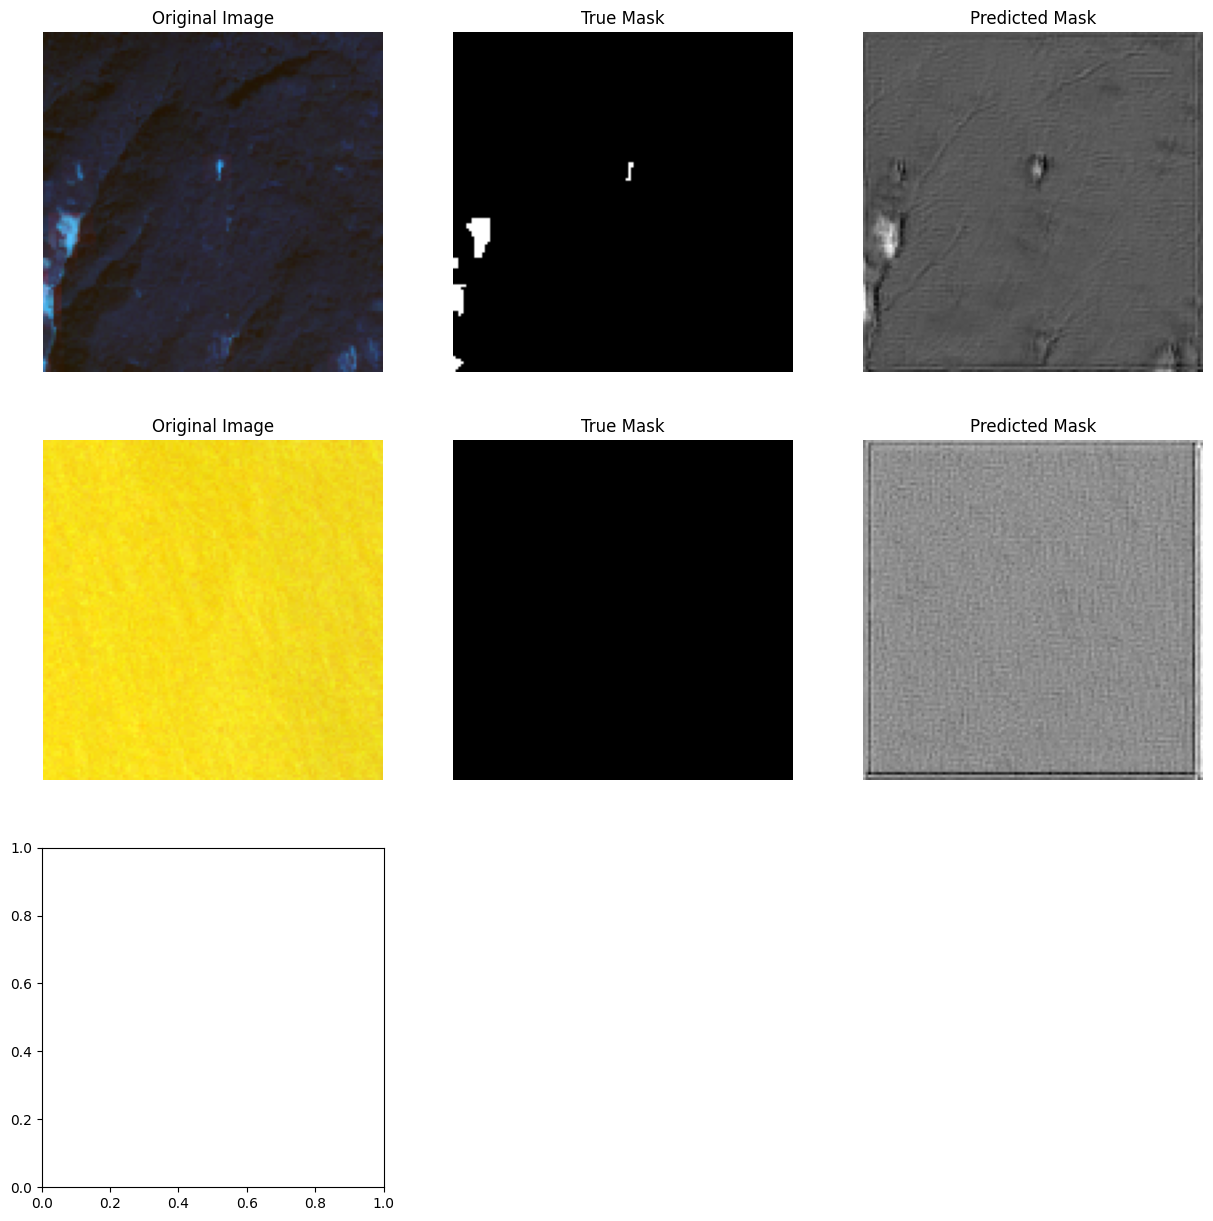

In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                    UpSampling2D, Concatenate, BatchNormalization,
                                    Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                      ReduceLROnPlateau, TensorBoard)
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ======================================
# 1. MEMORY-EFFICIENT DATA LOADING
# ======================================

def load_data_paths(base_dir):
    """Load all image and mask paths with proper sorting"""
    img_paths = sorted(glob.glob(f"{base_dir}/TrainData/img/*.h5"))
    mask_paths = sorted(glob.glob(f"{base_dir}/TrainData/mask/*.h5"))
    return img_paths, mask_paths

def load_batch(img_paths, mask_paths, batch_size=4, target_size=(128, 128)):
    """Load and process a batch of images and masks"""
    X_batch = []
    y_batch = []

    for img_path, mask_path in zip(img_paths, mask_paths):
        with h5py.File(img_path, 'r') as f_img, h5py.File(mask_path, 'r') as f_mask:
            img = np.nan_to_num(f_img['img'][:])[..., :3]  # Use only RGB
            mask = (f_mask['mask'][:] > 0).astype(np.float32)

            # Resize if needed
            if img.shape[:2] != target_size:
                img = tf.image.resize(img, target_size)
                mask = tf.image.resize(mask[..., np.newaxis], target_size)

            # Normalize to [0,1]
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
            X_batch.append(img)
            y_batch.append(mask[..., np.newaxis])

    return np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

class DataGenerator(tf.keras.utils.Sequence):
    """Memory-efficient data generator with augmentation"""
    def __init__(self, img_paths, mask_paths, batch_size=4, target_size=(128, 128), shuffle=True):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_img_paths = self.img_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        X, y = load_batch(batch_img_paths, batch_mask_paths, self.batch_size, self.target_size)

        # Simple augmentation - flip randomly
        for i in range(X.shape[0]):
            if np.random.rand() > 0.5:
                X[i] = np.fliplr(X[i])
                y[i] = np.fliplr(y[i])
            if np.random.rand() > 0.5:
                X[i] = np.flipud(X[i])
                y[i] = np.flipud(y[i])

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.img_paths, self.mask_paths))
            np.random.shuffle(combined)
            self.img_paths, self.mask_paths = zip(*combined)

# ======================================
# 2. OPTIMIZED U-NET++ MODEL
# ======================================

def conv_block(x, filters, kernel_size=3, dropout_rate=0.1):
    """Convolutional block with batch norm and dropout"""
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def build_unet_plus_plus(input_shape=(128, 128, 3), filters=8, dropout_rate=0.1):
    """Build optimized U-Net++ model for limited resources"""
    inputs = Input(input_shape)

    # Encoder
    x00 = conv_block(inputs, filters, dropout_rate=dropout_rate)
    p1 = MaxPooling2D()(x00)

    x10 = conv_block(p1, filters*2, dropout_rate=dropout_rate)
    p2 = MaxPooling2D()(x10)

    x20 = conv_block(p2, filters*4, dropout_rate=dropout_rate)
    p3 = MaxPooling2D()(x20)

    x30 = conv_block(p3, filters*8, dropout_rate=dropout_rate)
    p4 = MaxPooling2D()(x30)

    # Bridge
    x40 = conv_block(p4, filters*16, dropout_rate=dropout_rate)

    # Decoder with dense skip connections (U-Net++)
    x31 = UpSampling2D()(x40)
    x31 = Conv2D(filters*8, (2, 2), padding='same')(x31)
    x22 = conv_block(Concatenate()([x30, x31]), filters*8, dropout_rate=dropout_rate)

    x22_up = UpSampling2D()(x22)
    x22_up = Conv2D(filters*4, (2, 2), padding='same')(x22_up)
    x13 = conv_block(Concatenate()([x20, x22_up]), filters*4, dropout_rate=dropout_rate)

    x13_up = UpSampling2D()(x13)
    x13_up = Conv2D(filters*2, (2, 2), padding='same')(x13_up)
    x04 = conv_block(Concatenate()([x10, x13_up]), filters*2, dropout_rate=dropout_rate)

    x04_up = UpSampling2D()(x04)
    x04_up = Conv2D(filters, (2, 2), padding='same')(x04_up)
    final = conv_block(Concatenate()([x00, x04_up]), filters, dropout_rate=dropout_rate)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(final)

    return Model(inputs, outputs)

# ======================================
# 3. METRICS AND LOSS FUNCTIONS
# ======================================

def dice_coef(y_true, y_pred, smooth=1e-6):
    """Dice coefficient metric"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss function"""
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combined BCE and Dice loss"""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou_coef(y_true, y_pred, smooth=1e-6):
    """Intersection over Union metric"""
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true, [1,2,3]) + tf.keras.backend.sum(y_pred, [1,2,3]) - intersection
    return tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)

# ======================================
# 4. MODEL TRAINING AND EVALUATION
# ======================================

def train_model():
    # File paths
    base_dir = "/content/drive/MyDrive/SDP FILES"
    img_paths, mask_paths = load_data_paths(base_dir)

    # Split data (80% train, 10% val, 10% test)
    train_img, test_img, train_mask, test_mask = train_test_split(
        img_paths, mask_paths, test_size=0.2, random_state=42)
    val_img, test_img, val_mask, test_mask = train_test_split(
        test_img, test_mask, test_size=0.5, random_state=42)

    # Use smaller portion of the training data
    train_img = train_img[:100]  # Use only 100 samples for training
    train_mask = train_mask[:100]
    val_img = val_img[:20]      # Use only 20 samples for validation
    val_mask = val_mask[:20]

    # Create data generators
    train_gen = DataGenerator(train_img, train_mask, batch_size=2)  # Reduced batch size
    val_gen = DataGenerator(val_img, val_mask, batch_size=2, shuffle=False)

    # Build model
    model = build_unet_plus_plus(input_shape=(128, 128, 3), filters=8)  # Reduced filters
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=bce_dice_loss,
                  metrics=['accuracy', dice_coef, iou_coef])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=2, monitor='val_dice_coef', mode='max', restore_best_weights=True),  # Early stopping
        ModelCheckpoint('best_model.h5', monitor='val_dice_coef', mode='max', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6),
        TensorBoard(log_dir='./logs')
    ]

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,  # Reduced epochs
        steps_per_epoch=10,  # Reduced steps per epoch
        validation_steps=5,  # Reduced validation steps
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on validation set
    val_metrics = model.evaluate(val_gen, verbose=1)
    print(f"Validation Loss: {val_metrics[0]:.4f}")
    print(f"Validation Accuracy: {val_metrics[1]:.4f}")
    print(f"Validation Dice Coef: {val_metrics[2]:.4f}")
    print(f"Validation IoU Coef: {val_metrics[3]:.4f}")

    # Visualize sample predictions
    visualize_predictions(model, val_gen)

    return model

def visualize_predictions(model, generator, num_samples=3):
    """Visualize model predictions on sample images"""
    X, y = next(iter(generator))
    y_pred = model.predict(X)

    plt.figure(figsize=(15, 5*num_samples))
    for i in range(num_samples):
        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run training
model = train_model()

# Save model
model.save('/content/drive/MyDrive/SDP FILES/saved_model/unet_plus_plus_optimized.h5')
print("Model saved successfully!")

# **UNET++**

In [ ]:
!pip install albumentations

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8246 - dice_coef: 0.0634 - f1_score_metric: 0.1902 - iou_coef: 0.0310 - loss: 1.4585 - precision_metric: 0.1433 - recall_metric: 0.6220

760/760 ━━━━━━━━━━━━━━━━━━━━ 929s 1s/step - accuracy: 0.8247 - dice_coef: 0.0634 - f1_score_metric: 0.1903 - iou_coef: 0.0310 - loss: 1.4583 - precision_metric: 0.1435 - recall_metric: 0.6220 - val_accuracy: 0.9726 - val_dice_coef: 0.0892 - val_f1_score_metric: 0.3703 - val_iou_coef: 0.0427 - val_loss: 1.1513 - val_precision_metric: 0.3960 - val_recall_metric: 0.4705 - learning_rate: 1.0000e-04
Epoch 2/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 845s 1s/step - accuracy: 0.9610 - dice_coef: 0.1055 - f1_score_metric: 0.3593 - iou_coef: 0.0498 - loss: 1.1386 - precision_metric: 0.3036 - recall_metric: 0.6280 - val_accuracy: 0.9768 - val_dice_coef: 0.0851 - val_f1_score_metric: 0.2693 - val_iou_coef: 0.0391 - val_loss: 1.0706 - val_precision_metric: 0.4840 - val_recall_metric: 0.2384 - learning_rate: 1.0000e-04
Epoch 3/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9655 - dice_coef: 0.1485 - f1_score_metric: 0.3841 - iou_coef: 0.0665 - loss: 1.0123 - precision_metric: 0.3243 - recall_metric:

760/760 ━━━━━━━━━━━━━━━━━━━━ 857s 1s/step - accuracy: 0.9655 - dice_coef: 0.1486 - f1_score_metric: 0.3841 - iou_coef: 0.0665 - loss: 1.0123 - precision_metric: 0.3243 - recall_metric: 0.6591 - val_accuracy: 0.9779 - val_dice_coef: 0.1549 - val_f1_score_metric: 0.4009 - val_iou_coef: 0.0684 - val_loss: 0.9513 - val_precision_metric: 0.5171 - val_recall_metric: 0.4117 - learning_rate: 1.0000e-04
Epoch 4/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 839s 1s/step - accuracy: 0.9655 - dice_coef: 0.2170 - f1_score_metric: 0.3957 - iou_coef: 0.0920 - loss: 0.9003 - precision_metric: 0.3366 - recall_metric: 0.6415 - val_accuracy: 0.9659 - val_dice_coef: 0.2030 - val_f1_score_metric: 0.3613 - val_iou_coef: 0.0898 - val_loss: 0.8954 - val_precision_metric: 0.4665 - val_recall_metric: 0.4006 - learning_rate: 1.0000e-04
Epoch 5/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9682 - dice_coef: 0.2692 - f1_score_metric: 0.3955 - iou_coef: 0.1151 - loss: 0.8260 - precision_metric: 0.3460 - recall_metric:

760/760 ━━━━━━━━━━━━━━━━━━━━ 862s 1s/step - accuracy: 0.9682 - dice_coef: 0.2692 - f1_score_metric: 0.3955 - iou_coef: 0.1151 - loss: 0.8259 - precision_metric: 0.3460 - recall_metric: 0.6201 - val_accuracy: 0.9778 - val_dice_coef: 0.2950 - val_f1_score_metric: 0.4352 - val_iou_coef: 0.1228 - val_loss: 0.7811 - val_precision_metric: 0.4919 - val_recall_metric: 0.4717 - learning_rate: 1.0000e-04
Epoch 6/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 842s 1s/step - accuracy: 0.9703 - dice_coef: 0.3202 - f1_score_metric: 0.4130 - iou_coef: 0.1316 - loss: 0.7668 - precision_metric: 0.3756 - recall_metric: 0.6296 - val_accuracy: 0.9784 - val_dice_coef: 0.3314 - val_f1_score_metric: 0.4296 - val_iou_coef: 0.1334 - val_loss: 0.7424 - val_precision_metric: 0.5203 - val_recall_metric: 0.4379 - learning_rate: 1.0000e-04
Epoch 7/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 855s 1s/step - accuracy: 0.9716 - dice_coef: 0.3500 - f1_score_metric: 0.4169 - iou_coef: 0.1412 - loss: 0.7316 - precision_metric: 0.3792 - recall_metri

760/760 ━━━━━━━━━━━━━━━━━━━━ 869s 1s/step - accuracy: 0.9743 - dice_coef: 0.3889 - f1_score_metric: 0.4432 - iou_coef: 0.1640 - loss: 0.6911 - precision_metric: 0.4196 - recall_metric: 0.5832 - val_accuracy: 0.9783 - val_dice_coef: 0.3804 - val_f1_score_metric: 0.4375 - val_iou_coef: 0.1586 - val_loss: 0.6952 - val_precision_metric: 0.5116 - val_recall_metric: 0.4556 - learning_rate: 1.0000e-04
Epoch 9/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9754 - dice_coef: 0.3958 - f1_score_metric: 0.4364 - iou_coef: 0.1688 - loss: 0.6808 - precision_metric: 0.4143 - recall_metric: 0.5667

760/760 ━━━━━━━━━━━━━━━━━━━━ 845s 1s/step - accuracy: 0.9754 - dice_coef: 0.3958 - f1_score_metric: 0.4364 - iou_coef: 0.1688 - loss: 0.6808 - precision_metric: 0.4143 - recall_metric: 0.5667 - val_accuracy: 0.9784 - val_dice_coef: 0.4223 - val_f1_score_metric: 0.4631 - val_iou_coef: 0.1701 - val_loss: 0.6553 - val_precision_metric: 0.5332 - val_recall_metric: 0.4869 - learning_rate: 1.0000e-04
Epoch 10/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 857s 1s/step - accuracy: 0.9749 - dice_coef: 0.4120 - f1_score_metric: 0.4468 - iou_coef: 0.1746 - loss: 0.6696 - precision_metric: 0.4315 - recall_metric: 0.5920 - val_accuracy: 0.9792 - val_dice_coef: 0.3813 - val_f1_score_metric: 0.4164 - val_iou_coef: 0.1488 - val_loss: 0.7042 - val_precision_metric: 0.5364 - val_recall_metric: 0.4042 - learning_rate: 1.0000e-04
Epoch 11/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 849s 1s/step - accuracy: 0.9750 - dice_coef: 0.4098 - f1_score_metric: 0.4412 - iou_coef: 0.1709 - loss: 0.6742 - precision_metric: 0.4299 - recall_met

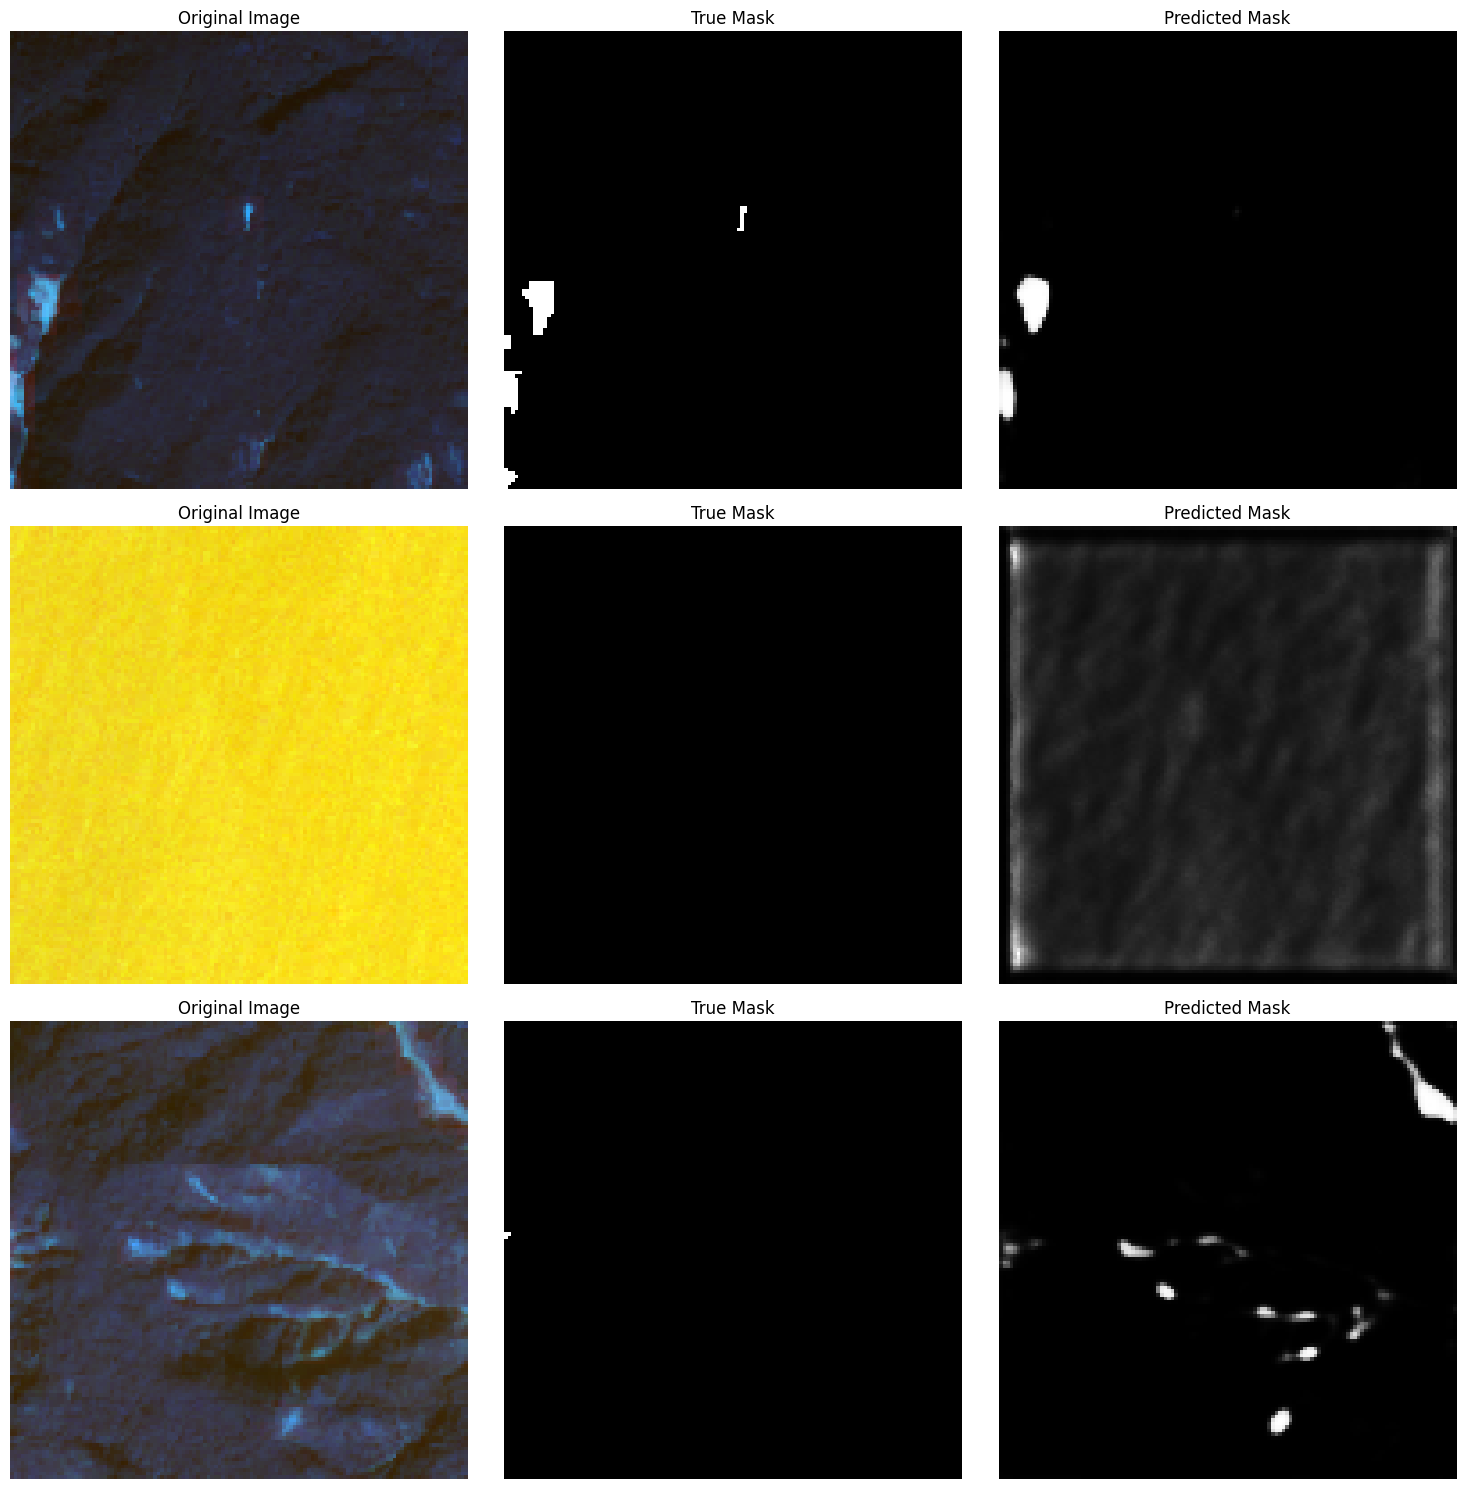

Model saved successfully!


In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                    UpSampling2D, Concatenate, BatchNormalization,
                                    Activation, Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                      ReduceLROnPlateau, TensorBoard)
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ======================================
# 1. MEMORY-EFFICIENT DATA LOADING
# ======================================

def load_data_paths(base_dir):
    """Load all image and mask paths with proper sorting"""
    img_paths = sorted(glob.glob(f"{base_dir}/TrainData/img/*.h5"))
    mask_paths = sorted(glob.glob(f"{base_dir}/TrainData/mask/*.h5"))
    return img_paths, mask_paths

def load_batch(img_paths, mask_paths, batch_size=4, target_size=(128, 128)):
    """Load and process a batch of images and masks"""
    X_batch = []
    y_batch = []

    for img_path, mask_path in zip(img_paths, mask_paths):
        with h5py.File(img_path, 'r') as f_img, h5py.File(mask_path, 'r') as f_mask:
            img = np.nan_to_num(f_img['img'][:])[..., :3]  # Use only RGB
            mask = (f_mask['mask'][:] > 0).astype(np.float32)

            # Resize if needed
            if img.shape[:2] != target_size:
                img = tf.image.resize(img, target_size)
                mask = tf.image.resize(mask[..., np.newaxis], target_size)

            # Normalize to [0,1]
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
            X_batch.append(img)
            y_batch.append(mask[..., np.newaxis])

    return np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

class DataGenerator(tf.keras.utils.Sequence):
    """Memory-efficient data generator with augmentation"""
    def __init__(self, img_paths, mask_paths, batch_size=4, target_size=(128, 128), shuffle=True):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_img_paths = self.img_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        X, y = load_batch(batch_img_paths, batch_mask_paths, self.batch_size, self.target_size)

        # Simple augmentation - flip randomly
        for i in range(X.shape[0]):
            if np.random.rand() > 0.5:
                X[i] = np.fliplr(X[i])
                y[i] = np.fliplr(y[i])
            if np.random.rand() > 0.5:
                X[i] = np.flipud(X[i])
                y[i] = np.flipud(y[i])

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.img_paths, self.mask_paths))
            np.random.shuffle(combined)
            self.img_paths, self.mask_paths = zip(*combined)

# ======================================
# 2. IMPROVED U-NET++ MODEL
# ======================================

def conv_block(x, filters, kernel_size=3, dropout_rate=0.1):
    """Convolutional block with batch norm and dropout"""
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def build_unet_plus_plus(input_shape=(128, 128, 3), filters=16, dropout_rate=0.1):
    """Build improved U-Net++ model"""
    inputs = Input(input_shape)

    # Encoder
    x00 = conv_block(inputs, filters, dropout_rate=dropout_rate)
    p1 = MaxPooling2D()(x00)

    x10 = conv_block(p1, filters*2, dropout_rate=dropout_rate)
    p2 = MaxPooling2D()(x10)

    x20 = conv_block(p2, filters*4, dropout_rate=dropout_rate)
    p3 = MaxPooling2D()(x20)

    x30 = conv_block(p3, filters*8, dropout_rate=dropout_rate)
    p4 = MaxPooling2D()(x30)

    # Bridge
    x40 = conv_block(p4, filters*16, dropout_rate=dropout_rate)

    # Decoder with dense skip connections (U-Net++)
    x31 = UpSampling2D()(x40)
    x31 = Conv2D(filters*8, (2, 2), padding='same', kernel_initializer='he_normal')(x31)
    x31 = BatchNormalization()(x31)
    x31 = Activation('relu')(x31)
    x31 = Concatenate()([x30, x31])
    x31 = conv_block(x31, filters*8, dropout_rate=dropout_rate)

    x22 = UpSampling2D()(x31)
    x22 = Conv2D(filters*4, (2, 2), padding='same', kernel_initializer='he_normal')(x22)
    x22 = BatchNormalization()(x22)
    x22 = Activation('relu')(x22)
    x22 = Concatenate()([x20, x22])
    x22 = conv_block(x22, filters*4, dropout_rate=dropout_rate)

    x13 = UpSampling2D()(x22)
    x13 = Conv2D(filters*2, (2, 2), padding='same', kernel_initializer='he_normal')(x13)
    x13 = BatchNormalization()(x13)
    x13 = Activation('relu')(x13)
    x13 = Concatenate()([x10, x13])
    x13 = conv_block(x13, filters*2, dropout_rate=dropout_rate)

    x04 = UpSampling2D()(x13)
    x04 = Conv2D(filters, (2, 2), padding='same', kernel_initializer='he_normal')(x04)
    x04 = BatchNormalization()(x04)
    x04 = Activation('relu')(x04)
    x04 = Concatenate()([x00, x04])
    x04 = conv_block(x04, filters, dropout_rate=dropout_rate)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(x04)

    return Model(inputs, outputs)

# ======================================
# 3. METRICS AND LOSS FUNCTIONS
# ======================================

def dice_coef(y_true, y_pred, smooth=1e-6):
    """Dice coefficient metric"""
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    """Dice loss function"""
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    """Combined BCE and Dice loss"""
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou_coef(y_true, y_pred, smooth=1e-6):
    """Intersection over Union metric"""
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true, [1,2,3]) + tf.keras.backend.sum(y_pred, [1,2,3]) - intersection
    return tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)

def f1_score_metric(y_true, y_pred):
    """F1 score metric"""
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val

def precision_metric(y_true, y_pred):
    """Precision metric"""
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall_metric(y_true, y_pred):
    """Recall metric"""
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# ======================================
# 4. MODEL TRAINING AND EVALUATION
# ======================================

def train_model():
    # File paths
    base_dir = "/content/drive/MyDrive/SDP FILES"
    img_paths, mask_paths = load_data_paths(base_dir)

    # Split data (80% train, 10% val, 10% test)
    train_img, test_img, train_mask, test_mask = train_test_split(
        img_paths, mask_paths, test_size=0.2, random_state=42)
    val_img, test_img, val_mask, test_mask = train_test_split(
        test_img, test_mask, test_size=0.5, random_state=42)

    # Create data generators
    train_gen = DataGenerator(train_img, train_mask, batch_size=4)
    val_gen = DataGenerator(val_img, val_mask, batch_size=4, shuffle=False)
    test_gen = DataGenerator(test_img, test_mask, batch_size=4, shuffle=False)

    # Build model
    model = build_unet_plus_plus(input_shape=(128, 128, 3), filters=16)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=bce_dice_loss,
                  metrics=['accuracy', dice_coef, iou_coef,
                          f1_score_metric, precision_metric, recall_metric])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=5, monitor='val_f1_score_metric', mode='max', restore_best_weights=True),
        ModelCheckpoint('best_model.h5', monitor='val_f1_score_metric', mode='max', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
        TensorBoard(log_dir='./logs')
    ]

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluate on validation set
    val_metrics = model.evaluate(val_gen, verbose=1)
    print("\nValidation Metrics:")
    print(f"Loss: {val_metrics[0]:.4f}")
    print(f"Accuracy: {val_metrics[1]:.4f}")
    print(f"Dice Coef: {val_metrics[2]:.4f}")
    print(f"IoU Coef: {val_metrics[3]:.4f}")
    print(f"F1 Score: {val_metrics[4]:.4f}")
    print(f"Precision: {val_metrics[5]:.4f}")
    print(f"Recall: {val_metrics[6]:.4f}")

    # Evaluate on test set
    test_metrics = model.evaluate(test_gen, verbose=1)
    print("\nTest Metrics:")
    print(f"Loss: {test_metrics[0]:.4f}")
    print(f"Accuracy: {test_metrics[1]:.4f}")
    print(f"Dice Coef: {test_metrics[2]:.4f}")
    print(f"IoU Coef: {test_metrics[3]:.4f}")
    print(f"F1 Score: {test_metrics[4]:.4f}")
    print(f"Precision: {test_metrics[5]:.4f}")
    print(f"Recall: {test_metrics[6]:.4f}")

    # Visualize sample predictions
    visualize_predictions(model, val_gen)

    return model

def visualize_predictions(model, generator, num_samples=3):
    """Visualize model predictions on sample images"""
    X, y = generator[0]  # Get first batch
    y_pred = model.predict(X)

    plt.figure(figsize=(15, 5*num_samples))
    for i in range(min(num_samples, X.shape[0])):  # Ensure we don't exceed batch size
        # Original Image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run training
model = train_model()

# Save model
model.save('/content/drive/MyDrive/SDP FILES/saved_model/unet_plus_plus_improved.h5')
print("Model saved successfully!")

# **DEEPLABV3+**

In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization,
                                    Activation, MaxPooling2D, Dropout,
                                    GlobalAveragePooling2D, Reshape,
                                    Concatenate, UpSampling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                      ReduceLROnPlateau, TensorBoard)
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ======================================
# 1. MEMORY-EFFICIENT DATA LOADING

def load_data_paths(base_dir):
    """Load all image and mask paths with proper sorting"""
    img_paths = sorted(glob.glob(f"{base_dir}/TrainData/img/*.h5"))
    mask_paths = sorted(glob.glob(f"{base_dir}/TrainData/mask/*.h5"))
    return img_paths, mask_paths

def load_batch(img_paths, mask_paths, batch_size=4, target_size=(128, 128)):
    """Load and process a batch of images and masks"""
    X_batch = []
    y_batch = []

    for img_path, mask_path in zip(img_paths, mask_paths):
        with h5py.File(img_path, 'r') as f_img, h5py.File(mask_path, 'r') as f_mask:
            img = np.nan_to_num(f_img['img'][:])[..., :3]  # Use only RGB
            mask = (f_mask['mask'][:] > 0).astype(np.float32)

            # Resize if needed
            if img.shape[:2] != target_size:
                img = tf.image.resize(img, target_size)
                mask = tf.image.resize(mask[..., np.newaxis], target_size)

            # Normalize to [0,1]
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)
            X_batch.append(img)
            y_batch.append(mask[..., np.newaxis])

    return np.array(X_batch, dtype=np.float32), np.array(y_batch, dtype=np.float32)

class DataGenerator(tf.keras.utils.Sequence):
    """Memory-efficient data generator with augmentation (Same as before)"""
    def __init__(self, img_paths, mask_paths, batch_size=4, target_size=(128, 128), shuffle=True):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.img_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_img_paths = self.img_paths[index*self.batch_size:(index+1)*self.batch_size]
        batch_mask_paths = self.mask_paths[index*self.batch_size:(index+1)*self.batch_size]

        X, y = load_batch(batch_img_paths, batch_mask_paths, self.batch_size, self.target_size)

        # Simple augmentation - flip randomly
        for i in range(X.shape[0]):
            if np.random.rand() > 0.5:
                X[i] = np.fliplr(X[i])
                y[i] = np.fliplr(y[i])
            if np.random.rand() > 0.5:
                X[i] = np.flipud(X[i])
                y[i] = np.flipud(y[i])

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            combined = list(zip(self.img_paths, self.mask_paths))
            np.random.shuffle(combined)
            self.img_paths, self.mask_paths = zip(*combined)

# ======================================
# 2. DEEPLABV3+ MODEL IMPLEMENTATION
# ======================================

def conv_block(x, filters, kernel_size=3, dilation_rate=1):
    """Convolutional block with batch normalization"""
    x = Conv2D(filters, kernel_size,
               padding='same',
               dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def aspp_block(inputs, num_filters=256):
    """Atrous Spatial Pyramid Pooling block"""
    # 1x1 convolution
    conv1x1 = Conv2D(num_filters, 1, padding='same')(inputs)
    conv1x1 = BatchNormalization()(conv1x1)
    conv1x1 = Activation('relu')(conv1x1)

    # 3x3 convolutions with different dilation rates
    conv3x3_r6 = conv_block(inputs, num_filters, dilation_rate=6)
    conv3x3_r12 = conv_block(inputs, num_filters, dilation_rate=12)
    conv3x3_r18 = conv_block(inputs, num_filters, dilation_rate=18)

    # Image pooling branch
    pool = GlobalAveragePooling2D()(inputs)
    pool = Reshape((1, 1, -1))(pool)
    pool = Conv2D(num_filters, 1, activation='relu')(pool)
    pool = UpSampling2D(size=(inputs.shape[1], inputs.shape[2]),
                       interpolation='bilinear')(pool)

    # Concatenate all branches
    combined = Concatenate()([conv1x1, conv3x3_r6, conv3x3_r12, conv3x3_r18, pool])

    # Final convolution
    output = Conv2D(num_filters, 1, padding='same')(combined)
    output = BatchNormalization()(output)
    output = Activation('relu')(output)
    output = Dropout(0.5)(output)

    return output

def build_deeplabv3plus(input_shape=(128, 128, 3)):
    """Build DeepLabV3+ model with corrected output size"""
    inputs = Input(input_shape)

    # Backbone Network
    # Entry flow
    x = Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    low_level_feat = x  # Save low-level features

    # Middle flow
    x = conv_block(x, 64)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = conv_block(x, 128)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = conv_block(x, 256, dilation_rate=2)
    x = conv_block(x, 256, dilation_rate=2)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # ASPP Block
    aspp_output = aspp_block(x)

    # Decoder
    # Process low-level features
    low_level_feat = Conv2D(48, 1, padding='same')(low_level_feat)
    low_level_feat = BatchNormalization()(low_level_feat)
    low_level_feat = Activation('relu')(low_level_feat)

    # Upsample ASPP output
    aspp_upsampled = UpSampling2D(size=(8, 8), interpolation='bilinear')(aspp_output)

    # Concatenate with low-level features
    combined = Concatenate()([aspp_upsampled, low_level_feat])

    # Final convolutions
    x = conv_block(combined, 256)
    x = conv_block(x, 256)

    # Corrected upsampling to match input size
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # Changed from (4,4) to (2,2)

    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(x)

    return Model(inputs, outputs)

# ======================================
# 3. METRICS AND LOSS
# ======================================

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou_coef(y_true, y_pred, smooth=1e-6):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1,2,3])
    union = tf.keras.backend.sum(y_true, [1,2,3]) + tf.keras.backend.sum(y_pred, [1,2,3]) - intersection
    return tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)

def f1_score_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))

    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())

    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val

def precision_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# ======================================
# 4. TRAINING AND EVALUATION
# ======================================

def train_model():
    # File paths
    base_dir = "/content/drive/MyDrive/SDP FILES"
    img_paths, mask_paths = load_data_paths(base_dir)

    # Split data
    train_img, test_img, train_mask, test_mask = train_test_split(
        img_paths, mask_paths, test_size=0.2, random_state=42)
    val_img, test_img, val_mask, test_mask = train_test_split(
        test_img, test_mask, test_size=0.5, random_state=42)

    # Create data generators
    train_gen = DataGenerator(train_img, train_mask, batch_size=4)
    val_gen = DataGenerator(val_img, val_mask, batch_size=4, shuffle=False)
    test_gen = DataGenerator(test_img, test_mask, batch_size=4, shuffle=False)

    # Build model
    model = build_deeplabv3plus(input_shape=(128, 128, 3))
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=bce_dice_loss,
                  metrics=['accuracy', dice_coef, iou_coef,
                          f1_score_metric, precision_metric, recall_metric])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=5, monitor='val_f1_score_metric', mode='max', restore_best_weights=True),
        ModelCheckpoint('best_deeplab.h5', monitor='val_f1_score_metric', mode='max', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
        TensorBoard(log_dir='./logs_deeplab')
    ]

    # Train
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        steps_per_epoch=len(train_gen),
        validation_steps=len(val_gen),
        callbacks=callbacks,
        verbose=1
    )

    # Evaluation
    val_metrics = model.evaluate(val_gen, verbose=1)
    print("\nValidation Metrics:")
    print(f"Loss: {val_metrics[0]:.4f}")
    print(f"Accuracy: {val_metrics[1]:.4f}")
    print(f"Dice Coef: {val_metrics[2]:.4f}")
    print(f"IoU Coef: {val_metrics[3]:.4f}")
    print(f"F1 Score: {val_metrics[4]:.4f}")
    print(f"Precision: {val_metrics[5]:.4f}")
    print(f"Recall: {val_metrics[6]:.4f}")

    test_metrics = model.evaluate(test_gen, verbose=1)
    print("\nTest Metrics:")
    print(f"Loss: {test_metrics[0]:.4f}")
    print(f"Accuracy: {test_metrics[1]:.4f}")
    print(f"Dice Coef: {test_metrics[2]:.4f}")
    print(f"IoU Coef: {test_metrics[3]:.4f}")
    print(f"F1 Score: {test_metrics[4]:.4f}")
    print(f"Precision: {test_metrics[5]:.4f}")
    print(f"Recall: {test_metrics[6]:.4f}")

    # Visualize predictions
    visualize_predictions(model, val_gen)

    return model

def visualize_predictions(model, generator, num_samples=3):
    X, y = generator[0]
    y_pred = model.predict(X)

    plt.figure(figsize=(15, 5*num_samples))
    for i in range(min(num_samples, X.shape[0])):
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title('True Mask')
        plt.axis('off')

        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Run training
model = train_model()

# Save model
model.save('/content/drive/MyDrive/SDP FILES/saved_model/deeplabv3_plus.h5')
print("DeepLabV3+ model saved successfully!")

Epoch 1/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8518 - dice_coef: 0.1461 - f1_score_metric: 0.2498 - iou_coef: 0.0642 - loss: 1.1700 - precision_metric: 0.2376 - recall_metric: 0.5594

760/760 ━━━━━━━━━━━━━━━━━━━━ 4395s 6s/step - accuracy: 0.8519 - dice_coef: 0.1462 - f1_score_metric: 0.2499 - iou_coef: 0.0643 - loss: 1.1697 - precision_metric: 0.2377 - recall_metric: 0.5594 - val_accuracy: 0.9412 - val_dice_coef: 0.3049 - val_f1_score_metric: 0.3897 - val_iou_coef: 0.1407 - val_loss: 1.0527 - val_precision_metric: 0.4038 - val_recall_metric: 0.5265 - learning_rate: 1.0000e-04
Epoch 2/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 4246s 6s/step - accuracy: 0.9719 - dice_coef: 0.3401 - f1_score_metric: 0.3944 - iou_coef: 0.1468 - loss: 0.7478 - precision_metric: 0.3931 - recall_metric: 0.5243 - val_accuracy: 0.9779 - val_dice_coef: 0.3312 - val_f1_score_metric: 0.3742 - val_iou_coef: 0.1306 - val_loss: 0.7540 - val_precision_metric: 0.5576 - val_recall_metric: 0.3454 - learning_rate: 1.0000e-04
Epoch 3/15
760/760 ━━━━━━━━━━━━━━━━━━━━ 4281s 6s/step - accuracy: 0.9713 - dice_coef: 0.3766 - f1_score_metric: 0.4113 - iou_coef: 0.1660 - loss: 0.7137 - precision_metric: 0.4101 - recall_me

In [ ]:
!ls -l "/content/drive/MyDrive/SDP FILES/TrainData/img/*.h5"
!ls -l "/content/drive/MyDrive/SDP FILES/TrainData/mask/*.h5"

ls: cannot access '/content/drive/MyDrive/SDP FILES/TrainData/img/*.h5': No such file or directory
ls: cannot access '/content/drive/MyDrive/SDP FILES/TrainData/mask/*.h5': No such file or directory


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Check root directory
!ls -l "/content/drive/MyDrive/"

Mounted at /content/drive
total 157379
-rw------- 1 root root 161146573 May  2 17:30  best_model.keras
drwx------ 2 root root      4096 Mar 20 11:44 'Colab Notebooks'
drwx------ 2 root root      4096 Mar 28 15:00 'SDP FILES'
-rw------- 1 root root       223 Mar 28 15:31  Untitled0.ipynb


In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# ======================================
# Verified Path Configuration
# ======================================
base_dir = "/content/drive/MyDrive/SDP FILES"

# ======================================
# Data Loading with Path Validation
# ======================================
def validate_paths():
    # Check TrainData existence
    train_data_path = os.path.join(base_dir, "TrainData")
    if not os.path.exists(train_data_path):
        raise FileNotFoundError(f"TrainData directory not found at {train_data_path}")

    # Check img and mask subdirectories
    img_dir = os.path.join(train_data_path, "img")
    mask_dir = os.path.join(train_data_path, "mask")

    if not os.path.exists(img_dir):
        raise FileNotFoundError(f"Image directory not found at {img_dir}")
    if not os.path.exists(mask_dir):
        raise FileNotFoundError(f"Mask directory not found at {mask_dir}")

    # Check HDF5 files
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.h5")))
    mask_paths = sorted(glob.glob(os.path.join(mask_dir, "*.h5")))

    if not img_paths:
        raise FileNotFoundError(f"No .h5 images found in {img_dir}")
    if not mask_paths:
        raise FileNotFoundError(f"No .h5 masks found in {mask_dir}")

    return img_paths, mask_paths

# ======================================
# Data Pipeline
# ======================================
def load_and_process(img_path, mask_path, target_size=(128, 128)):
    def _py_load(img_path, mask_path):
        with h5py.File(img_path.numpy(), 'r') as f_img, h5py.File(mask_path.numpy(), 'r') as f_mask:
            img = np.nan_to_num(f_img['img'][:])[..., :3]
            mask = (f_mask['mask'][:] > 0).astype(np.float32)

            # Resize
            img = tf.image.resize(img, target_size)
            mask = tf.image.resize(mask[..., np.newaxis], target_size)

            # Normalize
            img = (img - tf.reduce_min(img)) / (tf.reduce_max(img) - tf.reduce_min(img) + 1e-8)
            return img, mask

    img, mask = tf.py_function(_py_load, [img_path, mask_path], [tf.float32, tf.float32])
    img.set_shape((*target_size, 3))
    mask.set_shape((*target_size, 1))
    return img, mask

def create_dataset(img_paths, mask_paths, batch_size=8, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((img_paths, mask_paths))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1024)
    dataset = dataset.map(lambda x, y: load_and_process(x, y),
                        num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# ======================================
# Model Architecture
# ======================================
def depthwise_conv_block(x, filters, kernel_size=3, dilation_rate=1):
    x = layers.DepthwiseConv2D(kernel_size, padding='same', dilation_rate=dilation_rate)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 1, padding='same')(x)
    return x

def build_optimized_deeplabv3plus(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    # Backbone
    x = layers.Conv2D(16, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    low_level = x

    # Middle Flow
    x = depthwise_conv_block(x, 32)
    x = layers.MaxPooling2D(2)(x)
    x = depthwise_conv_block(x, 64)
    x = layers.MaxPooling2D(2)(x)
    x = depthwise_conv_block(x, 128, dilation_rate=2)
    x = layers.MaxPooling2D(2)(x)

    # ASPP Lite
    rates = [1, 6, 12]
    branches = []
    for rate in rates:
        branch = depthwise_conv_block(x, 64, dilation_rate=rate)
        branches.append(branch)

    # Global Context
    global_feat = layers.GlobalAveragePooling2D()(x)
    global_feat = layers.Reshape((1, 1, -1))(global_feat)
    global_feat = layers.Conv2D(64, 1)(global_feat)
    global_feat = layers.UpSampling2D(size=x.shape[1:3], interpolation='bilinear')(global_feat)
    branches.append(global_feat)

    # Concatenate & Fuse
    aspp = layers.Concatenate()(branches)
    aspp = depthwise_conv_block(aspp, 128)

    # Decoder
    low_level = depthwise_conv_block(low_level, 32)
    aspp = layers.UpSampling2D(size=(4, 4), interpolation='bilinear')(aspp)

    merged = layers.Concatenate()([aspp, low_level])
    merged = depthwise_conv_block(merged, 64)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(merged)

    return models.Model(inputs, outputs)

# ======================================
# Training Setup
# ======================================
def focal_dice_loss(y_true, y_pred, alpha=0.8, gamma=2.0):
    bce = tf.losses.binary_crossentropy(y_true, y_pred)
    p_t = tf.exp(-bce)
    focal_loss = alpha * tf.pow(1 - p_t, gamma) * bce

    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1,2,3])
    dice_loss = 1 - (numerator + 1) / (denominator + 1)

    return focal_loss + dice_loss

METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.OneHotIoU(num_classes=2, target_class_ids=[1], name='iou'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

# ======================================
# Training Execution
# ======================================
def train_model():
    img_paths, mask_paths = validate_paths()
    print(f"Found {len(img_paths)} training pairs")

    # Split dataset
    train_img, test_img, train_mask, test_mask = train_test_split(
        img_paths, mask_paths, test_size=0.2, random_state=42
    )
    val_img, test_img, val_mask, test_mask = train_test_split(
        test_img, test_mask, test_size=0.5, random_state=42
    )

    # Create datasets
    train_ds = create_dataset(train_img, train_mask)
    val_ds = create_dataset(val_img, val_mask, shuffle=False)
    test_ds = create_dataset(test_img, test_mask, shuffle=False)

    # Model setup
    model = build_optimized_deeplabv3plus()
    model.compile(
        optimizer=optimizers.Nadam(learning_rate=3e-4),
        loss=focal_dice_loss,
        metrics=METRICS
    )

    # Training callbacks
    callbacks = [
        EarlyStopping(patience=10, monitor='val_auc', mode='max'),
        ModelCheckpoint(os.path.join(base_dir, 'best_model.keras'), save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
    ]

    # Start training
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks,
        verbose=2
    )

    return model

# ======================================
# Main Execution
# ======================================
if __name__ == "__main__":
    from google.colab import drive
    drive.mount('/content/drive')

    try:
        model = train_model()
        model.save(os.path.join(base_dir, 'final_model.keras'))
        print("Training completed successfully!")
    except Exception as e:
        print(f"Error: {str(e)}")
        print("\nTroubleshooting Checklist:")
        print("1. Verify HDF5 files exist in correct paths")
        print("2. Check dataset names ('img' and 'mask') in HDF5 files")
        print("3. Confirm adequate free memory (>12GB)")
        print("4. Validate image dimensions match target_size")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 3799 training pairs
Error: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 32, 32, 128), (None, 64, 64, 32)]

Troubleshooting Checklist:
1. Verify HDF5 files exist in correct paths
2. Check dataset names ('img' and 'mask') in HDF5 files
3. Confirm adequate free memory (>12GB)
4. Validate image dimensions match target_size


# **ResUnet**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8759 - loss: 0.3450

854/854 ━━━━━━━━━━━━━━━━━━━━ 1790s 2s/step - accuracy: 0.8760 - loss: 0.3448 - val_accuracy: 0.9671 - val_loss: 0.0949
Epoch 2/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9716 - loss: 0.0806

854/854 ━━━━━━━━━━━━━━━━━━━━ 1108s 1s/step - accuracy: 0.9716 - loss: 0.0806 - val_accuracy: 0.9671 - val_loss: 0.0751
Epoch 3/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9709 - loss: 0.0696

854/854 ━━━━━━━━━━━━━━━━━━━━ 1108s 1s/step - accuracy: 0.9709 - loss: 0.0696 - val_accuracy: 0.9673 - val_loss: 0.0706
Epoch 4/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9705 - loss: 0.0661

854/854 ━━━━━━━━━━━━━━━━━━━━ 1108s 1s/step - accuracy: 0.9705 - loss: 0.0661 - val_accuracy: 0.9673 - val_loss: 0.0677
Epoch 5/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9710 - loss: 0.0636

854/854 ━━━━━━━━━━━━━━━━━━━━ 1114s 1s/step - accuracy: 0.9710 - loss: 0.0636 - val_accuracy: 0.9676 - val_loss: 0.0655
Epoch 6/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9708 - loss: 0.0624

854/854 ━━━━━━━━━━━━━━━━━━━━ 1110s 1s/step - accuracy: 0.9708 - loss: 0.0624 - val_accuracy: 0.9678 - val_loss: 0.0651
Epoch 7/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9716 - loss: 0.0613

854/854 ━━━━━━━━━━━━━━━━━━━━ 1109s 1s/step - accuracy: 0.9716 - loss: 0.0613 - val_accuracy: 0.9681 - val_loss: 0.0631
Epoch 8/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 1112s 1s/step - accuracy: 0.9713 - loss: 0.0608 - val_accuracy: 0.9682 - val_loss: 0.0633
Epoch 9/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9705 - loss: 0.0615

854/854 ━━━━━━━━━━━━━━━━━━━━ 1158s 1s/step - accuracy: 0.9705 - loss: 0.0615 - val_accuracy: 0.9684 - val_loss: 0.0621
Epoch 10/10
854/854 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9704 - loss: 0.0614

854/854 ━━━━━━━━━━━━━━━━━━━━ 1104s 1s/step - accuracy: 0.9704 - loss: 0.0614 - val_accuracy: 0.9684 - val_loss: 0.0617


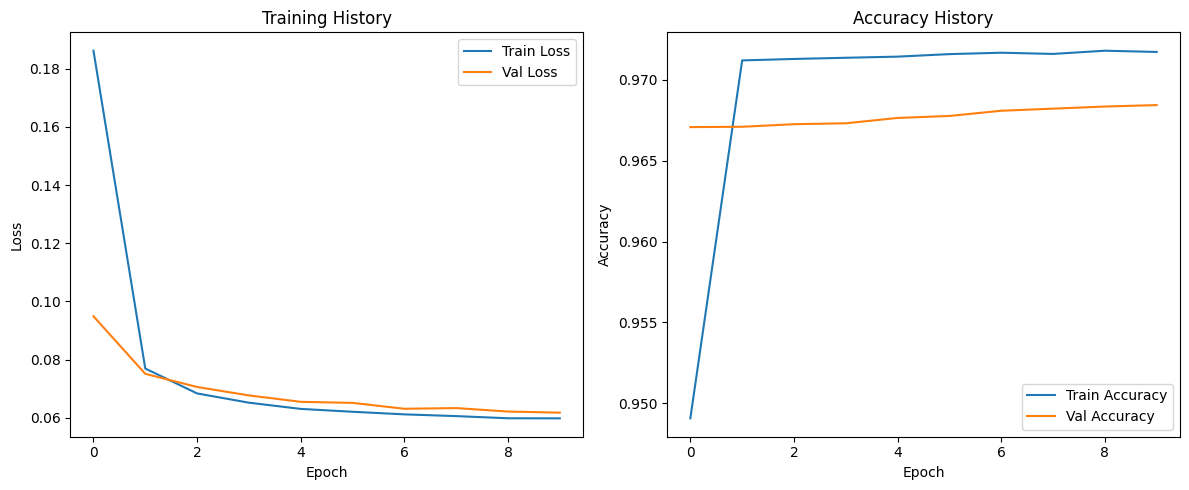

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 78 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 74 variables whereas the saved optimizer has 0 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


ValueError: A total of 18 objects could not be loaded. Example error message for object <Conv2D name=conv2d_130, built=True>:

Layer 'conv2d_130' expected 2 variables, but received 0 variables during loading. Expected: ['kernel', 'bias']

List of objects that could not be loaded:
[<Conv2D name=conv2d_130, built=True>, <Conv2D name=conv2d_131, built=True>, <Conv2D name=conv2d_132, built=True>, <Conv2D name=conv2d_133, built=True>, <Conv2D name=conv2d_134, built=True>, <Conv2D name=conv2d_135, built=True>, <Conv2D name=conv2d_136, built=True>, <Conv2D name=conv2d_137, built=True>, <Conv2D name=conv2d_138, built=True>, <Conv2DTranspose name=conv2d_transpose_14, built=True>, <Conv2D name=conv2d_139, built=True>, <Conv2D name=conv2d_140, built=True>, <Conv2D name=conv2d_141, built=True>, <Conv2DTranspose name=conv2d_transpose_15, built=True>, <Conv2D name=conv2d_142, built=True>, <Conv2D name=conv2d_143, built=True>, <Conv2D name=conv2d_144, built=True>, <Conv2D name=conv2d_145, built=True>]

In [ ]:
import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D,
                                    Conv2DTranspose, Concatenate, Add,
                                    Activation)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Disable GPU and optimize for CPU
tf.config.set_visible_devices([], 'GPU')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ======================================
# 1. CPU-OPTIMIZED DATA PIPELINE
# ======================================

def load_data_paths(base_dir):
    img_paths = sorted(glob.glob(f"{base_dir}/TrainData/img/*.h5"))
    mask_paths = sorted(glob.glob(f"{base_dir}/TrainData/mask/*.h5"))
    return img_paths, mask_paths

class CpuDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_paths, mask_paths, batch_size=4, target_size=(96, 96)):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.target_size = target_size
        self.indexes = np.arange(len(img_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.img_paths) // self.batch_size

    def __getitem__(self, index):
        batch_idx = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = np.zeros((self.batch_size, *self.target_size, 3), dtype=np.float32)
        y = np.zeros((self.batch_size, *self.target_size, 1), dtype=np.float32)

        for i, idx in enumerate(batch_idx):
            with h5py.File(self.img_paths[idx], 'r') as f_img, \
                 h5py.File(self.mask_paths[idx], 'r') as f_mask:

                # Load and resize
                img = np.nan_to_num(f_img['img'][:][..., :3])
                mask = (f_mask['mask'][:] > 0).astype(np.float32)

                X[i] = tf.image.resize(img, self.target_size).numpy()
                y[i] = tf.image.resize(mask[..., np.newaxis], self.target_size).numpy()

                # Normalize
                X[i] = (X[i] - X[i].min()) / (X[i].max() - X[i].min() + 1e-8)

        # Simple augmentation
        if np.random.rand() > 0.5:
            X = np.flip(X, axis=2)  # Horizontal flip
            y = np.flip(y, axis=2)

        return X, y

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

# ======================================
# 2. LIGHTWEIGHT RESUNET ARCHITECTURE
# ======================================

def cpu_res_block(x, filters):
    shortcut = x
    x = Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = Conv2D(filters, 3, padding='same')(x)

    if shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, 1, padding='same')(shortcut)

    x = Add()([x, shortcut])
    return Activation('relu')(x)

def build_cpu_resunet(input_shape=(96, 96, 3)):
    inputs = Input(input_shape)
    f = 4  # Small filters for CPU

    # Encoder
    e1 = cpu_res_block(inputs, f)
    p1 = MaxPooling2D()(e1)

    e2 = cpu_res_block(p1, f*2)
    p2 = MaxPooling2D()(e2)

    # Bridge
    bridge = cpu_res_block(p2, f*4)

    # Decoder
    d1 = Conv2DTranspose(f*2, 3, strides=2, padding='same')(bridge)
    d1 = Concatenate()([d1, e2])
    d1 = cpu_res_block(d1, f*2)

    d2 = Conv2DTranspose(f, 3, strides=2, padding='same')(d1)
    d2 = Concatenate()([d2, e1])
    d2 = cpu_res_block(d2, f)

    outputs = Conv2D(1, 1, activation='sigmoid')(d2)
    return Model(inputs, outputs)

# ======================================
# 3. TRAINING & VISUALIZATION
# ======================================

def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy History')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, generator, num_samples=3):
    X, y = generator[0]
    y_pred = model.predict(X)

    plt.figure(figsize=(15, 5*num_samples))
    for i in range(min(num_samples, X.shape[0])):
        # Original Image
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(X[i])
        plt.title('Input Image')
        plt.axis('off')

        # True Mask
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(y[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(y_pred[i].squeeze(), cmap='gray')
        plt.title('Prediction')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def train_model():
    base_dir = "/content/drive/MyDrive/SDP FILES"
    img_paths, mask_paths = load_data_paths(base_dir)

    # Create dataset splits
    train_img, val_img, train_mask, val_mask = train_test_split(
        img_paths, mask_paths, test_size=0.1, random_state=42)

    # Create generators
    train_gen = CpuDataGenerator(train_img, train_mask, batch_size=4)
    val_gen = CpuDataGenerator(val_img, val_mask, batch_size=4)

    # Build and compile model
    model = build_cpu_resunet()
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    callbacks = [
        EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
        ModelCheckpoint('best_cpu_resunet.weights.h5', save_best_only=True)
    ]

    # Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        verbose=1,
        callbacks=callbacks
    )

    # Show training history
    plot_history(history)

    # Load best weights
    model.load_weights('best_cpu_resunet.weights.h5')

    # Final evaluation
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)
    print(f"\nBest Validation Accuracy: {val_acc:.4f}")

    # Visualize predictions
    visualize_predictions(model, val_gen)

    # Save model
    model.save('/content/drive/MyDrive/SDP FILES/saved_model/cpu_resunet_final.h5')
    print("Model saved successfully!")

    return model

# Run training
model = train_model()